In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
%%R
data_folder = './'
setwd(data_folder)

In [4]:
msstat_data = pd.read_csv("./PXD007145.sdrf_openms_design_msstats_in.csv")

msstat_data[msstat_data["ProteinName"].str.contains("YEAST")].head()

ProteinName                          PeptideSequence  \
50  sp|P38085|TAT1_YEAST  .(Acetyl)M(Oxidation)DDS(Phospho)VSFIAK   
51  sp|P38085|TAT1_YEAST  .(Acetyl)M(Oxidation)DDS(Phospho)VSFIAK   
52  sp|P38085|TAT1_YEAST  .(Acetyl)M(Oxidation)DDS(Phospho)VSFIAK   
53  sp|P38085|TAT1_YEAST  .(Acetyl)M(Oxidation)DDS(Phospho)VSFIAK   
54  sp|P38085|TAT1_YEAST  .(Acetyl)M(Oxidation)DDS(Phospho)VSFIAK   

    PrecursorCharge  FragmentIon  ProductCharge IsotopeLabelType  \
50                2          NaN              0                L   
51                2          NaN              0                L   
52                2          NaN              0                L   
53                2          NaN              0                L   
54                2          NaN              0                L   

                    Condition  BioReplicate  Run    Intensity  \
50   SP=Yeast;CT=Mixture;QY=4             2   10   43403300.0   
51   SP=Yeast;CT=Mixture;QY=4             2   11   37567730.0   
52   SP=Yeast;CT=Mixture;QY=4             2   12   42184520.0   
53  SP=Yeast;CT=Mixture;QY=10             3   13  126704300.0   
54  SP=Yeast;CT=Mixture;QY=10             3   14  133648300.0   

                                            Reference  
50   20171106_LUMOS1_nLC13_AH_TechBench2_LFQ_4_4.mzML  
51   20171106_LUMOS1_nLC13_AH_TechBench2_LFQ_4_5.mzML  
52   20171106_LUMOS1_nLC13_AH_TechBench2_LFQ_4_6.mzML  
53  20171106_LUMOS1_nLC13_AH_TechBench2_LFQ_10_1.mzML  
54  20171106_LUMOS1_nLC13_AH_TechBench2_LFQ_10_2.mzML

In [5]:
import re
out_msstats = pd.read_csv("./PXD007145.sdrf_openms_design_msstats_in.csv")
def sub_mod(peptide):
    peptide = peptide.replace(".", "")
    peptide = re.sub("\(.*?\)", "", peptide)
    return peptide
    
print(len(out_msstats))
out_msstats["sequence"] = out_msstats.apply(lambda x: sub_mod(x["PeptideSequence"]), axis=1)
filtered_df = out_msstats.groupby('sequence').filter(lambda x: len(set(x["ProteinName"])) == 1)
filtered_df = filtered_df.groupby('ProteinName').filter(lambda x: len(set(x["sequence"])) >= 2)
filtered_df = filtered_df[-filtered_df["ProteinName"].str.contains(";")]
filtered_df.drop("sequence", axis=1, inplace=True)
print(len(filtered_df))
filtered_df.to_csv("./out_msstats_filter.csv", index=False)

232163
199292


In [27]:
%%R -w 800 -h 600

library('MSstats', warn.conflicts = F, quietly = T, verbose = F)

protein_expression = './protein_expression.csv'

raw.om <- read.csv('./out_msstats_filter.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om <- OpenMStoMSstatsFormat(raw.om)
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                        normalization = 'equalizeMedians',
                                        summaryMethod = 'TMP',
                                        censoredInt = "NA",
                                        MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP', 'SUBJECT', 'originalRUN')]
head(Protein.Expression)
write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2022-09-26 20:14:01] ** Raw data from OpenMS imported successfully.
INFO  [2022-09-26 20:14:02] ** Raw data from OpenMS cleaned successfully.
INFO  [2022-09-26 20:14:02] ** Using annotation extracted from quantification data.
INFO  [2022-09-26 20:14:02] ** Run labels were standardized to remove symbols such as '.' or '%'.
INFO  [2022-09-26 20:14:02] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements across runs will be removed.
INFO  [2022-09-26 20:14:02] ** Features with all missing measurements across runs are removed.
INFO  [2022-09-26 20:14:02] ** Shared peptides are removed.
INFO  [2022-09-26 20:14:02] ** Multiple measurements in a feature and a run are summarized by summaryforMultipleRows: max
INFO  [2022-09-26 20:14:02] ** Features with one or two meas

In [7]:
%%R

ac_groups = levels(quantms.proposed$FeatureLevelData$GROUP)
groups = levels(quantms.proposed$ProteinLevelData$GROUP)
print(ac_groups)

[1] "SP=Yeast;CT=Mixture;QY=1"  "SP=Yeast;CT=Mixture;QY=10"
[3] "SP=Yeast;CT=Mixture;QY=4" 


In [8]:
%%R

comparison_matrix = c(-1, -1, 0, 1, 1, 0)
comparison <- matrix(comparison_matrix, nrow=2)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- c("4vs1", "10vs1")

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)
write.csv(ResultComparison$ComparisonResult, './filter_em_comparison_res.csv', row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2022-09-26 19:26:47]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2022-09-26 19:27:13]  == Comparisons for all proteins are done.


In [28]:
%%R -w 800 -h 600

protein_expression = './quantile_protein_expression.csv'

raw.om <- read.csv('./out_msstats_filter.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om <- OpenMStoMSstatsFormat(raw.om)
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = 'quantile',
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP', 'SUBJECT', 'originalRUN')]
head(Protein.Expression)
write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2022-09-26 20:15:51] ** Raw data from OpenMS imported successfully.
INFO  [2022-09-26 20:15:51] ** Raw data from OpenMS cleaned successfully.
INFO  [2022-09-26 20:15:51] ** Using annotation extracted from quantification data.
INFO  [2022-09-26 20:15:51] ** Run labels were standardized to remove symbols such as '.' or '%'.
INFO  [2022-09-26 20:15:51] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements across runs will be removed.
INFO  [2022-09-26 20:15:52] ** Features with all missing measurements across runs are removed.
INFO  [2022-09-26 20:15:52] ** Shared peptides are removed.
INFO  [2022-09-26 20:15:52] ** Multiple measurements in a feature and a run are summarized by summaryforMultipleRows: max
INFO  [2022-09-26 20:15:52] ** Features with one or two meas

In [10]:
%%R

comparison_matrix = c(-1, -1, 0, 1, 1, 0)
comparison <- matrix(comparison_matrix, nrow=2)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- c("4vs1", "10vs1")

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)
write.csv(ResultComparison$ComparisonResult, './quantile_comparison_res_filter.csv', row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2022-09-26 19:30:03]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2022-09-26 19:30:30]  == Comparisons for all proteins are done.


In [29]:
%%R -w 800 -h 600

protein_expression = './no_normalization_protein_expression.csv'

raw.om <- read.csv('./out_msstats_filter.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om <- OpenMStoMSstatsFormat(raw.om)
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = FALSE,
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP', 'SUBJECT', 'originalRUN')]
head(Protein.Expression)
write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2022-09-26 20:16:59] ** Raw data from OpenMS imported successfully.
INFO  [2022-09-26 20:16:59] ** Raw data from OpenMS cleaned successfully.
INFO  [2022-09-26 20:16:59] ** Using annotation extracted from quantification data.
INFO  [2022-09-26 20:16:59] ** Run labels were standardized to remove symbols such as '.' or '%'.
INFO  [2022-09-26 20:16:59] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements across runs will be removed.
INFO  [2022-09-26 20:16:59] ** Features with all missing measurements across runs are removed.
INFO  [2022-09-26 20:16:59] ** Shared peptides are removed.
INFO  [2022-09-26 20:17:00] ** Multiple measurements in a feature and a run are summarized by summaryforMultipleRows: max
INFO  [2022-09-26 20:17:00] ** Features with one or two meas

In [12]:
%%R

comparison_matrix = c(-1, -1, 0, 1, 1, 0)
comparison <- matrix(comparison_matrix, nrow=2)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- c("4vs1", "10vs1")

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)
write.csv(ResultComparison$ComparisonResult, './no_normalization_comparison_res_filter.csv', row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2022-09-26 19:31:34]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2022-09-26 19:32:00]  == Comparisons for all proteins are done.


### Proteus

In [16]:
import re
from collections import Counter

def clean_PeptideSequence(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    pep_seq = pep_seq.replace(".", "")
    return pattern.sub("", pep_seq)

def modified_PeptideSequence(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    t_pep_seq = pep_seq.replace(".", "").replace("Acetyl", "ac").replace("Carbamidomethyl", "ca").replace("Oxidation", "ox")
    t_pep_seq = "_" + t_pep_seq + "_"
    return t_pep_seq

def get_modifications(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    t = ""
    modifications = re.findall(pattern, pep_seq)
    if len(modifications) == 0:
        return "Unmodified"
    c = Counter(modifications)
    for key, value in c.items():
        if value == 1:
            c[key] = ""
        else:
            c[key] = str(c[key]) + " "
    modifications = ",".join(modifications)
    if "(Acetyl)" in c:
        modifications = modifications.replace("(Acetyl)", c["(Acetyl)"] + "Acetyl (Protein N-term)")
    if "(Carbamidomethyl)" in c:
        modifications = modifications.replace("(Carbamidomethyl)", c["(Carbamidomethyl)"] + "Carbamidomethyl (C)")
    if "(Oxidation)" in c:
        modifications = modifications.replace("(Oxidation)", c["(Oxidation)"] + "Oxidation (M)")
    if "(Phospho)" in c:
         modifications = modifications.replace("(Phospho)", c["(Phospho)"] + "Phospho (STY)")
    
    return modifications

def get_experiment(row):
    return row['Reference'].split(".")[0].split("_")[-2] + "_" +"TechRep" + str(row['Reference'].split(".")[0].split("_")[-1])
    
    
evi = pd.DataFrame(None, columns=['sequence', 'modified_sequence', 'modifications', 'protein_group', 
                                  'protein', 'experiment', 'charge', 'reverse', 'contaminant', 'intensity'])
quantms = pd.read_csv("./out_msstats_filter.csv", sep=',', header=0)
quantms = quantms[-quantms['ProteinName'].str.contains("DECOY_")]
evi['sequence'] = quantms.apply(lambda x: clean_PeptideSequence(x['PeptideSequence']), axis=1)
evi['modified_sequence'] = quantms.apply(lambda x: modified_PeptideSequence(x['PeptideSequence']), axis=1)
evi['modifications'] = quantms.apply(lambda x: get_modifications(x['PeptideSequence']), axis=1)
evi['protein_group'] = quantms['ProteinName']
evi['protein'] = quantms['ProteinName']
evi['experiment'] = quantms.apply(lambda x: get_experiment(x), axis=1)
evi['charge'] = quantms['PrecursorCharge']
evi['intensity'] = quantms['Intensity']
evi.to_csv("./evi.txt", sep='\t', index=False)

metadata = pd.DataFrame(None, columns=['experiment', 'measure', 'sample', 'condition', 'replicate'])
metadata['experiment'] = ["1_TechRep1", "1_TechRep2", "1_TechRep3", "1_TechRep4", "1_TechRep5", "1_TechRep6", 
                          "4_TechRep1", "4_TechRep2", "4_TechRep3", "4_TechRep4", "4_TechRep5", "4_TechRep6",
                          "10_TechRep1", "10_TechRep2", "10_TechRep3", "10_TechRep4", "10_TechRep5", "10_TechRep6"]
metadata['measure'] = ['Intensity'] * 18
metadata['sample'] = ["1_TechRep1", "1_TechRep2", "1_TechRep3", "1_TechRep4", "1_TechRep5", "1_TechRep6", 
                          "4_TechRep1", "4_TechRep2", "4_TechRep3", "4_TechRep4", "4_TechRep5", "4_TechRep6",
                          "10_TechRep1", "10_TechRep2", "10_TechRep3", "10_TechRep4", "10_TechRep5", "10_TechRep6"]

metadata['condition'] = ["1"]*6 + ["4"]*6 + ["10"]*6
metadata['replicate'] = [1, 2, 3, 4, 5, 6] * 3
metadata.to_csv("./metadata.txt", sep="\t", index=False)


In [17]:
%%R
library(proteus)

evi = read.csv("./evi.txt", sep="\t", header=TRUE)
meta = read.csv("./metadata.txt", sep="\t", header=TRUE)
pepdat <- makePeptideTable(evi, meta)

In [18]:
%%R
summary(pepdat)


*** Basic statistics ***

  content = peptide
  experiment type = label-free
  number of samples = 18
  number of conditions = 3
  number of peptides = 11355
  samples = 1_TechRep1, 1_TechRep2, 1_TechRep3, 1_TechRep4, 1_TechRep5, 1_TechRep6, 4_TechRep1, 4_TechRep2, 4_TechRep3, 4_TechRep4, 4_TechRep5, 4_TechRep6, 10_TechRep1, 10_TechRep2, 10_TechRep3, 10_TechRep4, 10_TechRep5, 10_TechRep6
  conditions = 1, 10, 4

*** Data processing ***

  evidence columns used = Intensity
  sequence = 'Sequence'
  protein = 'Leading razor protein'
  normalization = identity


In [19]:
%%R
prodat <- makeProteinTable(pepdat)
head(prodat$tab)

                      1_TechRep1 1_TechRep2 1_TechRep3 1_TechRep4 1_TechRep5
sp|A0AVK6|E2F8_HUMAN          NA    4583910    5021548    5178967         NA
sp|A0FGR8|ESYT2_HUMAN   20784645   43478909   70632218   39597855   45965110
sp|A0JNW5|UH1BL_HUMAN    6846592    8645136    8379891    9526787    6451784
sp|A0MZ66|SHOT1_HUMAN   56493097   77315883   81827267   79896427   81340837
sp|A1L390|PKHG3_HUMAN   23178734   19247295   20394935   18261297   21090285
sp|A2A2Y4|FRMD3_HUMAN   19572480   29050818   36574347   33008105   33311375
                      1_TechRep6 4_TechRep1 4_TechRep2 4_TechRep3 4_TechRep4
sp|A0AVK6|E2F8_HUMAN          NA    4307177    2975110         NA         NA
sp|A0FGR8|ESYT2_HUMAN   45360856   69845538   70786228   57826788   52399657
sp|A0JNW5|UH1BL_HUMAN    8505769    7950252    6844478    8382098   10036711
sp|A0MZ66|SHOT1_HUMAN   83787397   79055483   81102447   84139710   82192878
sp|A1L390|PKHG3_HUMAN         NA   18122070   19923700   16804020   14629534

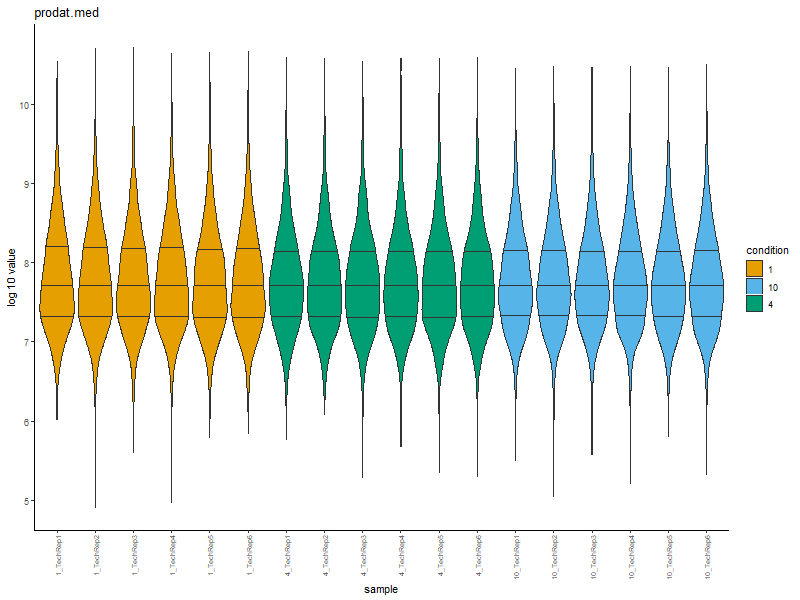

In [21]:
%%R -w 800 -h 600

prodat.med <- normalizeData(prodat)
prodat.quant <- normalizeData(prodat, norm.fun=limma::normalizeQuantiles)
plotSampleDistributions(prodat.med, title="prodat.med", fill="condition", method="violin")


In [22]:
%%R

write.csv(prodat.med$tab, file="./prodatmed.csv")
write.csv(prodat.quant$tab, file="./prodatquantile.csv")
write.csv(prodat$tab, file="./prodat.csv")

In [24]:
%%R
res <- limmaDE(prodat, sig.level=0.05, conditions=c("4", "1"))
write.csv(res, file="./prodat_comp_res_filter_4fc.csv")

res <- limmaDE(prodat.med, sig.level=0.05, conditions=c("4", "1"))
write.csv(res, file="./prodat_med_comp_res_filter_4fc.csv")

res <- limmaDE(prodat.quant, sig.level=0.05, conditions=c("4", "1"))
write.csv(res, file="./prodat_quantile_comp_res_filter_4fc.csv")

head(res)

                protein       logFC  AveExpr          t      P.Value
1  sp|A0AVK6|E2F8_HUMAN -0.89972562 22.32438 -3.4236167 0.0210054070
2 sp|A0FGR8|ESYT2_HUMAN  0.03879596 25.75343  0.1948219 0.8488868750
3 sp|A0JNW5|UH1BL_HUMAN -0.15691892 23.29203 -0.8858468 0.3936094447
4 sp|A0MZ66|SHOT1_HUMAN -0.25481241 26.42765 -4.1083867 0.0015394265
5 sp|A1L390|PKHG3_HUMAN -0.70198895 24.39680 -4.4028141 0.0011416355
6 sp|A2A2Y4|FRMD3_HUMAN -0.43245370 25.08849 -5.3082725 0.0002050062
    adj.P.Val           B significant   mean_4   mean_1 ngood_4 ngood_1
1 0.050187283 -3.70869272       FALSE 21.78454 22.68427       2       3
2 0.889226541 -7.66509424       FALSE 25.77283 25.73403       6       6
3 0.509699587 -7.27420854       FALSE 23.21358 23.37049       6       6
4 0.006614235 -2.03910183        TRUE 26.30025 26.55506       6       6
5 0.005329735 -1.62186499        TRUE 24.07771 24.77970       6       5
6 0.001393273  0.05917773        TRUE 24.87227 25.30472       6       6


In [25]:
%%R
res <- limmaDE(prodat, sig.level=0.05, conditions=c("10", "1"))
write.csv(res, file="./prodat_comp_res_filter_10fc.csv")

res <- limmaDE(prodat.med, sig.level=0.05, conditions=c("10", "1"))
write.csv(res, file="./prodat_med_comp_res_filter_10fc.csv")

res <- limmaDE(prodat.quant, sig.level=0.05, conditions=c("10", "1"))
write.csv(res, file="./prodat_quantile_comp_res_filter_10fc.csv")

head(res)

                protein      logFC  AveExpr         t      P.Value    adj.P.Val
1  sp|A0AVK6|E2F8_HUMAN         NA 22.68427        NA           NA           NA
2 sp|A0FGR8|ESYT2_HUMAN -1.2682512 25.09990 -5.836115 8.800317e-05 2.778110e-04
3 sp|A0JNW5|UH1BL_HUMAN -0.3189814 23.21100 -1.410929 1.842558e-01 2.329800e-01
4 sp|A0MZ66|SHOT1_HUMAN -0.5803590 26.26488 -8.238388 3.254389e-06 1.849066e-05
5 sp|A1L390|PKHG3_HUMAN  0.2779270 24.93130  0.951401 3.623600e-01 4.196448e-01
6 sp|A2A2Y4|FRMD3_HUMAN -0.6056386 25.00190 -6.557136 3.026467e-05 1.132543e-04
           B significant  mean_10   mean_1 ngood_10 ngood_1
1         NA          NA       NA 22.68427        0       3
2  0.8003578        TRUE 24.46578 25.73403        6       6
3 -6.8410626       FALSE 23.05151 23.37049        6       6
4  4.2897916        TRUE 25.97470 26.55506        6       6
5 -7.3154122       FALSE 25.05763 24.77970        6       5
6  1.9269675        TRUE 24.69908 25.30472        6       6


In [184]:
quantms_em_protein_expression = pd.read_csv("./protein_expression.csv", header=0, sep=",")

msstats_em_cv = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'TechRep4', 'TechRep5', 'TechRep6', 'Type', "CV[%]", "Condition"])
for condition, group_condition in quantms_em_protein_expression.groupby("GROUP"):
    for protein, t_sum in group_condition.groupby("Protein"):
        if len(t_sum) <= 3:
            continue
        TechRep1 = np.NaN
        TechRep2 = np.NaN
        TechRep3 = np.NaN
        TechRep4 = np.NaN
        TechRep5 = np.NaN
        TechRep6 = np.NaN
        for _, row in t_sum.iterrows():
            if row["originalRUN"] == 1 or row["originalRUN"] == 7 or row["originalRUN"] == 13:
                TechRep1 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 2 or row["originalRUN"] == 8 or row["originalRUN"] == 14:
                TechRep2 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 3 or row["originalRUN"] == 9 or row["originalRUN"] == 15:
                TechRep3 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 4 or row["originalRUN"] == 10 or row["originalRUN"] == 16:
                TechRep4 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 5 or row["originalRUN"] == 11 or row["originalRUN"] == 17:
                TechRep5 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 6 or row["originalRUN"] == 12 or row["originalRUN"] == 18:
                TechRep6 = np.exp2(row["LogIntensities"])
        condition = condition.replace("SP=Yeast;CT=Mixture;QY=", "")
        mean = np.nanmean([TechRep1, TechRep2, TechRep3, TechRep4, TechRep5, TechRep6])
        std = np.nanstd([TechRep1, TechRep2, TechRep3, TechRep4, TechRep5, TechRep6])
        msstats_em_cv = msstats_em_cv.append({'ProteinName': protein,'TechRep1':TechRep1, 
                       'TechRep2': TechRep2, 'TechRep3': TechRep3, "TechRep4": TechRep4, "TechRep5": TechRep5, "TechRep6": TechRep6,
                                        "CV[%]": 100 * (std / mean), "Type": "MSstats", "Condition": condition}, ignore_index=True)

In [185]:
import re

prodatmed = pd.read_csv("./prodatmed.csv", index_col=0)

def return_techrep(row):
    return row["MS runs"].replace("TechRep", "").split("_")[-1]

prodatmed = prodatmed.reset_index() #将索引转化为Series
prodatmed_long = prodatmed.melt(id_vars=["index"])
prodatmed_long.rename(columns={"index": "ProteinName", "variable": "MS runs", "value": "Intensity"}, inplace=True)
prodatmed_long.dropna(how="any", inplace=True)
prodatmed_long["LogIntensities"] = prodatmed_long.apply(lambda x: np.log2(x["Intensity"]), axis=1)
prodatmed_long["TechRep"] = prodatmed_long.apply(lambda x: return_techrep(x), axis=1)
prodatmed_long["Condition"] = prodatmed_long.apply(lambda x: x["MS runs"].split("_")[0], axis=1)

In [186]:
prodatmed_long

ProteinName      MS runs     Intensity  LogIntensities  \
1      sp|A0FGR8|ESYT2_HUMAN   1_TechRep1  3.796020e+07       25.177984   
2      sp|A0JNW5|UH1BL_HUMAN   1_TechRep1  1.250433e+07       23.575924   
3      sp|A0MZ66|SHOT1_HUMAN   1_TechRep1  1.031766e+08       26.620541   
4      sp|A1L390|PKHG3_HUMAN   1_TechRep1  4.233266e+07       25.335268   
5      sp|A2A2Y4|FRMD3_HUMAN   1_TechRep1  3.574635e+07       25.091293   
...                      ...          ...           ...             ...   
49909  sp|Q9Y6W5|WASF2_HUMAN  10_TechRep6  1.055590e+08       26.653474   
49910   sp|Q9Y6X8|ZHX2_HUMAN  10_TechRep6  6.399946e+06       22.609628   
49911  sp|Q9Y6X9|MORC2_HUMAN  10_TechRep6  4.360257e+07       25.377910   
49912  sp|Q9Y6Y0|NS1BP_HUMAN  10_TechRep6  2.405960e+08       27.842038   
49913  sp|Q9Y6Y8|S23IP_HUMAN  10_TechRep6  8.630230e+07       26.362896   

      TechRep Condition  
1           1         1  
2           1         1  
3           1         1  
4           1         1  
5           1         1  
...       ...       ...  
49909       6        10  
49910       6        10  
49911       6        10  
49912       6        10  
49913       6        10  

[44455 rows x 6 columns]

In [187]:
for condition, group_condition in prodatmed_long.groupby("Condition"):
    for protein, t_sum in group_condition.groupby("ProteinName"):
        if len(t_sum) <= 3:
            continue
        TechRep1 = np.NaN
        TechRep2 = np.NaN
        TechRep3 = np.NaN
        TechRep4 = np.NaN
        TechRep5 = np.NaN
        TechRep6 = np.NaN
        for _, row in t_sum.iterrows():
            if str(row["TechRep"]) == "1":
                TechRep1 = row["Intensity"]
            elif str(row["TechRep"]) == "2":
                TechRep2 = row["Intensity"]
            elif str(row["TechRep"]) == "3":
                TechRep3 = row["Intensity"]
            elif str(row["TechRep"]) == "4":
                TechRep4 = row["Intensity"]
            elif str(row["TechRep"]) == "5":
                TechRep5 = row["Intensity"]
            elif str(row["TechRep"]) == "6":
                TechRep6 = row["Intensity"]

        mean = np.nanmean([TechRep1, TechRep2, TechRep3, TechRep4, TechRep5, TechRep6])
        std = np.nanstd([TechRep1, TechRep2, TechRep3, TechRep4, TechRep5, TechRep6])
        msstats_em_cv = msstats_em_cv.append({'ProteinName': protein,'TechRep1':TechRep1, 
                       'TechRep2': TechRep2, 'TechRep3': TechRep3, "TechRep4": TechRep4, "TechRep5": TechRep5, "TechRep6": TechRep6,
                                        "CV[%]": 100 * (std / mean), "Type": "Proteus", "Condition": condition}, ignore_index=True)
        

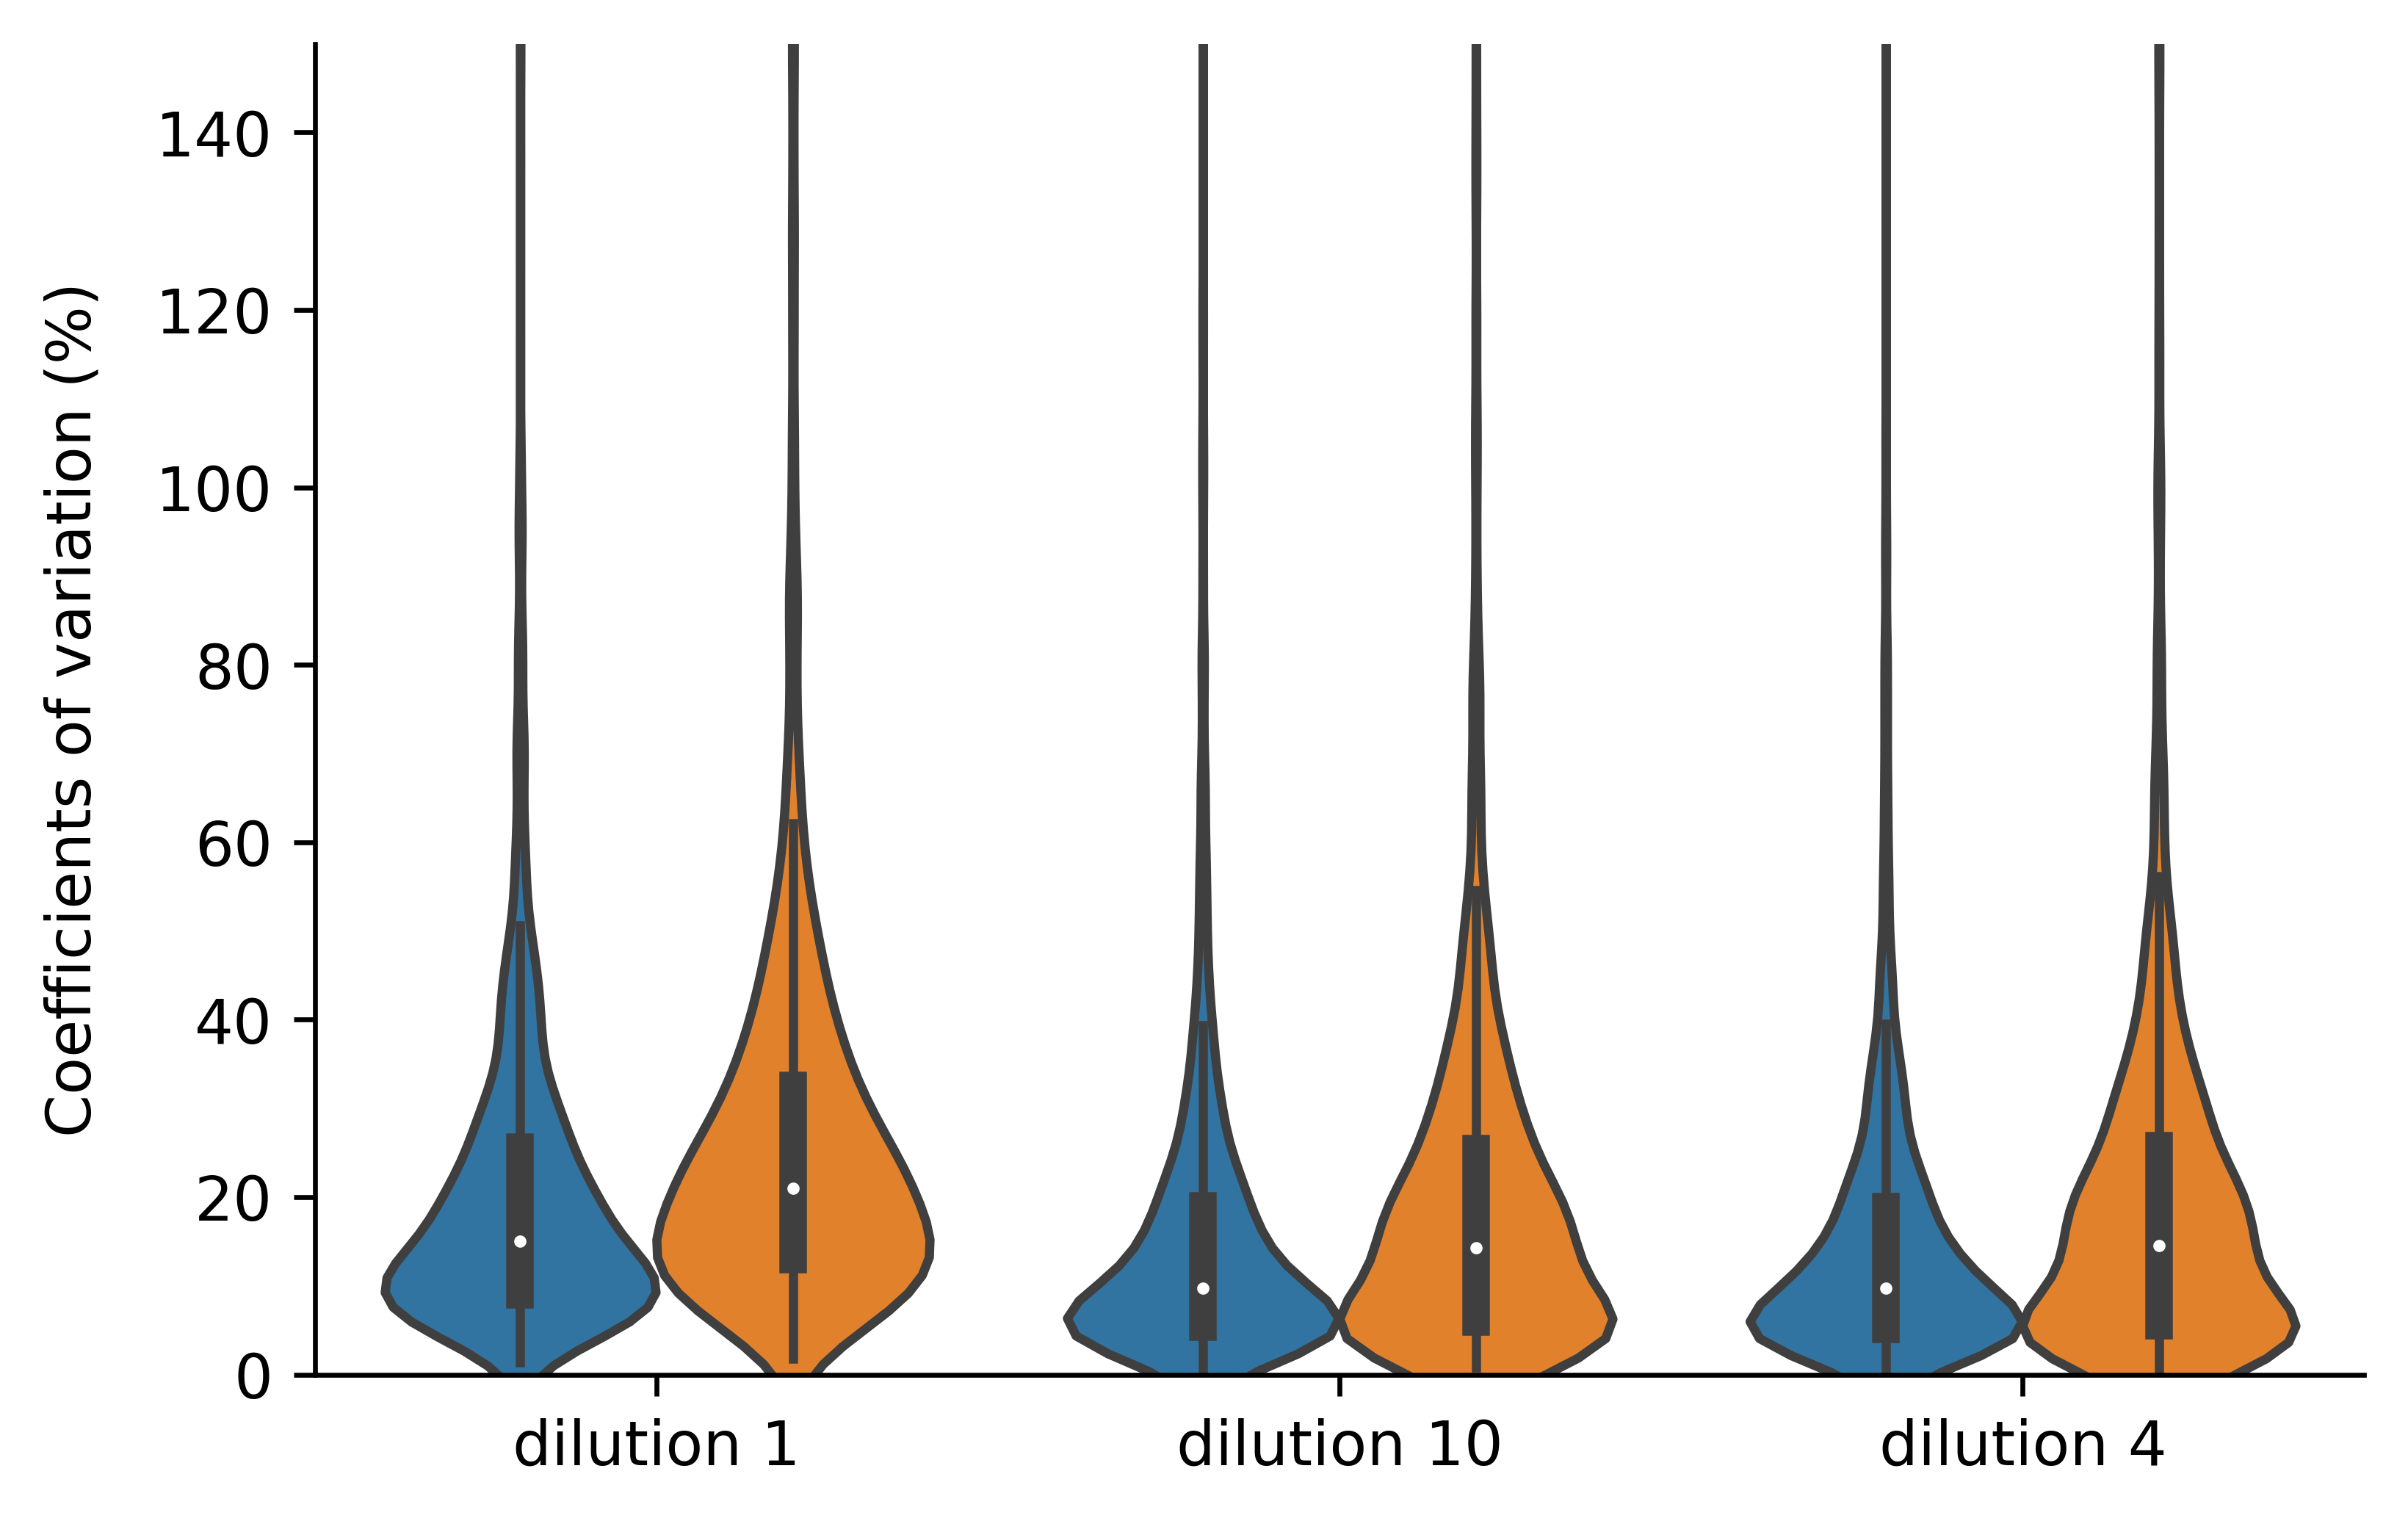

In [188]:
plt.figure(dpi=600)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0, 150)
msstats_em_cv["Condition"] = msstats_em_cv.apply(lambda x: "dilution " + str(x["Condition"]), axis=1)

# plt.title("Coefficients of variation (%)")
sns.violinplot(x = "Condition", y="CV[%]", data=msstats_em_cv, scale= "count", hue="Type")

ax.get_legend().remove()
plt.ylabel("Coefficients of variation (%)", labelpad=8.5)
plt.xlabel("", labelpad=8.5)
plt.show()

In [189]:
msstats_em_cv.groupby("Type")["CV[%]"].mean()

Type
MSstats    16.246933
Proteus    21.147065
Name: CV[%], dtype: float64

In [173]:
quantms_quantile_protein_expression = pd.read_csv("./quantile_protein_expression.csv", header=0, sep=",")

msstats_quantile_cv = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'TechRep4', 'TechRep5', 'TechRep6', 'Type', "CV[%]", "Condition"])
for condition, group_condition in quantms_quantile_protein_expression.groupby("GROUP"):
    for protein, t_sum in group_condition.groupby("Protein"):
        if len(t_sum) <= 3:
            continue
        TechRep1 = np.NaN
        TechRep2 = np.NaN
        TechRep3 = np.NaN
        TechRep4 = np.NaN
        TechRep5 = np.NaN
        TechRep6 = np.NaN
        for _, row in t_sum.iterrows():
            if row["originalRUN"] == 1 or row["originalRUN"] == 7 or row["originalRUN"] == 13:
                TechRep1 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 2 or row["originalRUN"] == 8 or row["originalRUN"] == 14:
                TechRep2 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 3 or row["originalRUN"] == 9 or row["originalRUN"] == 15:
                TechRep3 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 4 or row["originalRUN"] == 10 or row["originalRUN"] == 16:
                TechRep4 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 5 or row["originalRUN"] == 11 or row["originalRUN"] == 17:
                TechRep5 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 6 or row["originalRUN"] == 12 or row["originalRUN"] == 18:
                TechRep6 = np.exp2(row["LogIntensities"])
        condition = condition.replace("SP=Yeast;CT=Mixture;QY=", "")
        mean = np.nanmean([TechRep1, TechRep2, TechRep3, TechRep4, TechRep5, TechRep6])
        std = np.nanstd([TechRep1, TechRep2, TechRep3, TechRep4, TechRep5, TechRep6])
        msstats_quantile_cv = msstats_quantile_cv.append({'ProteinName': protein,'TechRep1':TechRep1, 
                       'TechRep2': TechRep2, 'TechRep3': TechRep3, "TechRep4": TechRep4, "TechRep5": TechRep5, "TechRep6": TechRep6,
                                        "CV[%]": 100 * (std / mean), "Type": "MSstats", "Condition": condition}, ignore_index=True)

In [174]:
prodatquantile = pd.read_csv("./prodatquantile.csv", index_col=0)
prodatquantile = prodatquantile.reset_index() #将索引转化为Series
prodatquantile_long = prodatquantile.melt(id_vars=["index"])
prodatquantile_long.rename(columns={"index": "ProteinName", "variable": "MS runs", "value": "Intensity"}, inplace=True)
prodatquantile_long.dropna(how="any", inplace=True)
prodatquantile_long["LogIntensities"] = prodatquantile_long.apply(lambda x: np.log2(x["Intensity"]), axis=1)
prodatquantile_long["TechRep"] = prodatquantile_long.apply(lambda x: return_techrep(x), axis=1)
prodatquantile_long["Condition"] = prodatquantile_long.apply(lambda x: x["MS runs"].split("_")[0], axis=1)

In [175]:
for condition, group_condition in prodatquantile_long.groupby("Condition"):
    for protein, t_sum in group_condition.groupby("ProteinName"):
        if len(t_sum) <= 3:
            continue
        TechRep1 = np.NaN
        TechRep2 = np.NaN
        TechRep3 = np.NaN
        TechRep4 = np.NaN
        TechRep5 = np.NaN
        TechRep6 = np.NaN
        for _, row in t_sum.iterrows():
            if str(row["TechRep"]) == "1":
                TechRep1 = row["Intensity"]
            elif str(row["TechRep"]) == "2":
                TechRep2 = row["Intensity"]
            elif str(row["TechRep"]) == "3":
                TechRep3 = row["Intensity"]
            elif str(row["TechRep"]) == "4":
                TechRep4 = row["Intensity"]
            elif str(row["TechRep"]) == "5":
                TechRep5 = row["Intensity"]
            elif str(row["TechRep"]) == "6":
                TechRep6 = row["Intensity"]

        mean = np.nanmean([TechRep1, TechRep2, TechRep3, TechRep4, TechRep5, TechRep6])
        std = np.nanstd([TechRep1, TechRep2, TechRep3, TechRep4, TechRep5, TechRep6])
        msstats_quantile_cv = msstats_quantile_cv.append({'ProteinName': protein,'TechRep1':TechRep1, 
                       'TechRep2': TechRep2, 'TechRep3': TechRep3, "TechRep4": TechRep4, "TechRep5": TechRep5, "TechRep6": TechRep6,
                                        "CV[%]": 100 * (std / mean), "Type": "Proteus", "Condition": condition}, ignore_index=True)

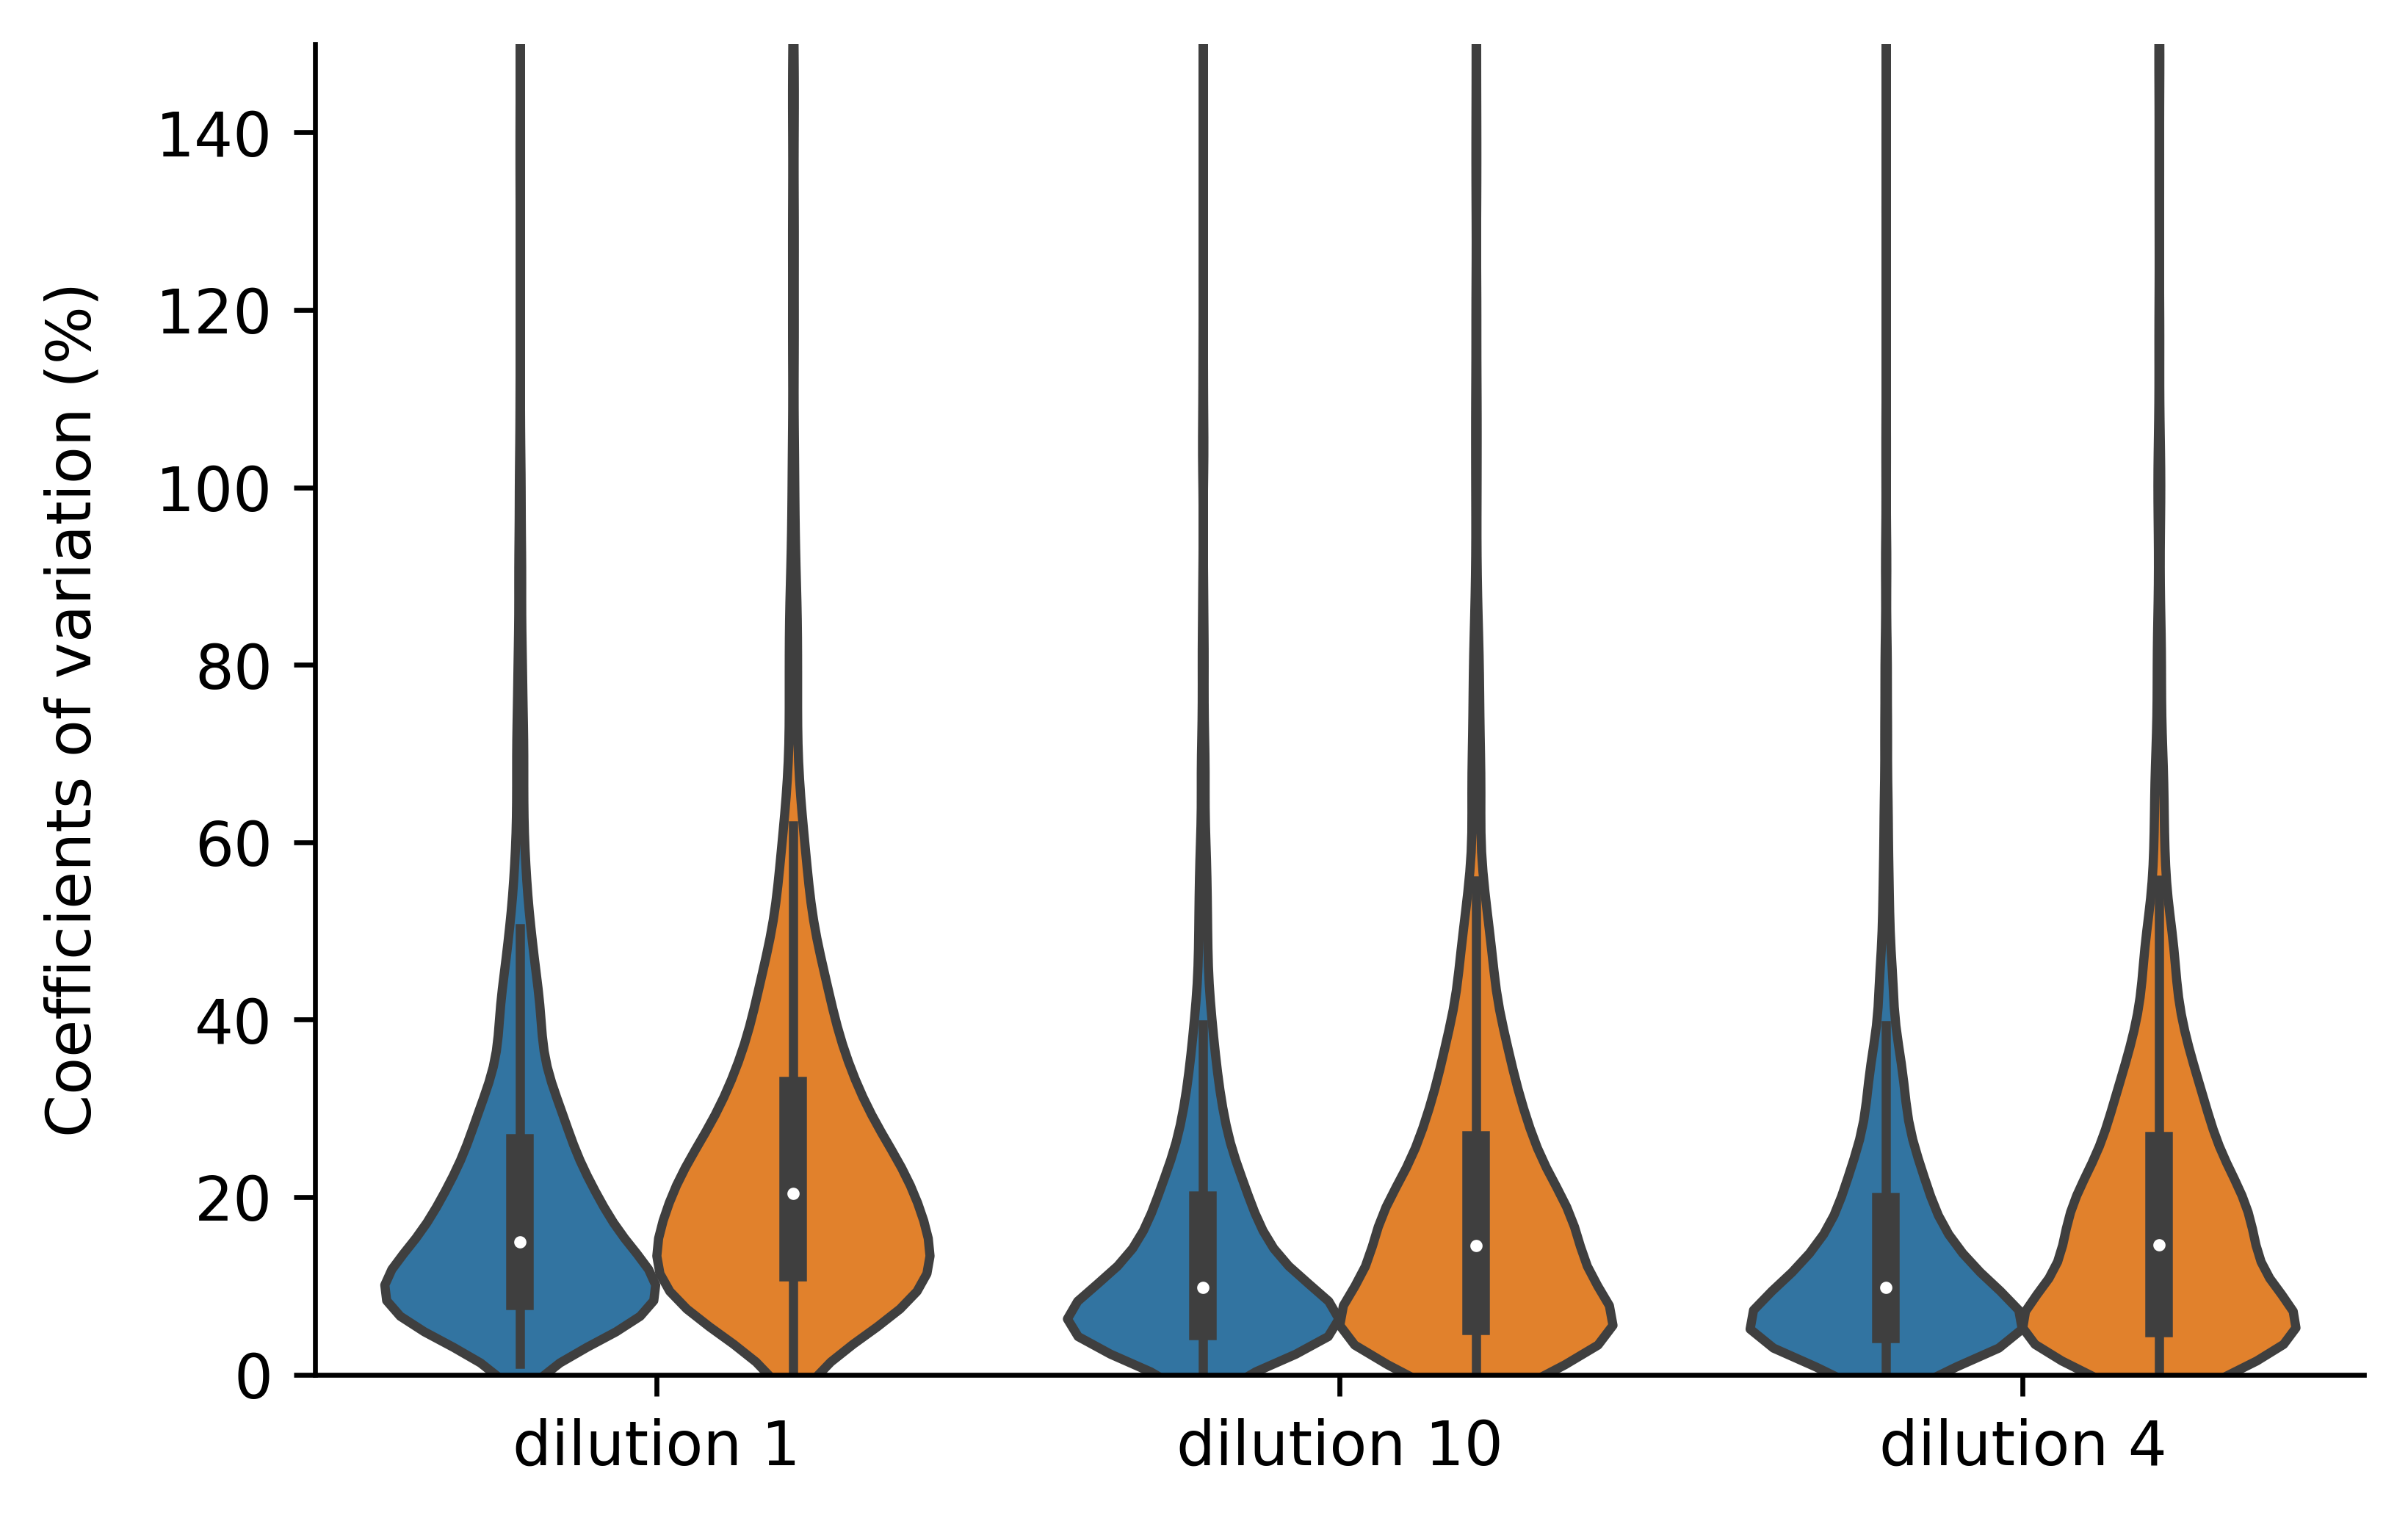

In [176]:
plt.figure(dpi=600)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0, 150)

msstats_quantile_cv["Condition"] = msstats_quantile_cv.apply(lambda x: "dilution " + str(x["Condition"]), axis=1)

# plt.title("Coefficients of variation (%)")
sns.violinplot(x = "Condition", y="CV[%]", data=msstats_quantile_cv, scale= "count", hue="Type")
ax.get_legend().remove()
plt.ylabel("Coefficients of variation (%)", labelpad=8.5)
plt.xlabel("", labelpad=8.5)
plt.show()

In [177]:
msstats_quantile_cv.groupby("Type")["CV[%]"].mean()

Type
MSstats    16.320127
Proteus    21.017292
Name: CV[%], dtype: float64

In [179]:
no_normalization_protein_expression = pd.read_csv("./no_normalization_protein_expression.csv", header=0, sep=",")

msstats_no_normalization_cv = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'TechRep4', 'TechRep5', 'TechRep6', 'Type', "CV[%]", "Condition"])
for condition, group_condition in no_normalization_protein_expression.groupby("GROUP"):
    for protein, t_sum in group_condition.groupby("Protein"):
        if len(t_sum) <= 3:
            continue
        TechRep1 = np.NaN
        TechRep2 = np.NaN
        TechRep3 = np.NaN
        TechRep4 = np.NaN
        TechRep5 = np.NaN
        TechRep6 = np.NaN
        for _, row in t_sum.iterrows():
            if row["originalRUN"] == 1 or row["originalRUN"] == 7 or row["originalRUN"] == 13:
                TechRep1 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 2 or row["originalRUN"] == 8 or row["originalRUN"] == 14:
                TechRep2 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 3 or row["originalRUN"] == 9 or row["originalRUN"] == 15:
                TechRep3 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 4 or row["originalRUN"] == 10 or row["originalRUN"] == 16:
                TechRep4 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 5 or row["originalRUN"] == 11 or row["originalRUN"] == 17:
                TechRep5 = np.exp2(row["LogIntensities"])
            elif row["originalRUN"] == 6 or row["originalRUN"] == 12 or row["originalRUN"] == 18:
                TechRep6 = np.exp2(row["LogIntensities"])
        condition = condition.replace("SP=Yeast;CT=Mixture;QY=", "")
        mean = np.nanmean([TechRep1, TechRep2, TechRep3, TechRep4, TechRep5, TechRep6])
        std = np.nanstd([TechRep1, TechRep2, TechRep3, TechRep4, TechRep5, TechRep6])
        msstats_no_normalization_cv = msstats_no_normalization_cv.append({'ProteinName': protein,'TechRep1':TechRep1, 
                       'TechRep2': TechRep2, 'TechRep3': TechRep3, "TechRep4": TechRep4, "TechRep5": TechRep5, "TechRep6": TechRep6,
                                        "CV[%]": 100 * (std / mean), "Type": "MSstats", "Condition": condition}, ignore_index=True)

In [180]:
prodat = pd.read_csv("./prodat.csv", index_col=0)
prodat = prodat.reset_index() #将索引转化为Series
prodat_long = prodat.melt(id_vars=["index"])
prodat_long.rename(columns={"index": "ProteinName", "variable": "MS runs", "value": "Intensity"}, inplace=True)
prodat_long.dropna(how="any", inplace=True)
prodat_long["LogIntensities"] = prodat_long.apply(lambda x: np.log2(x["Intensity"]), axis=1)
prodat_long["TechRep"] = prodat_long.apply(lambda x: return_techrep(x), axis=1)
prodat_long["Condition"] = prodat_long.apply(lambda x: x["MS runs"].split("_")[0], axis=1)

In [181]:
for condition, group_condition in prodat_long.groupby("Condition"):
    for protein, t_sum in group_condition.groupby("ProteinName"):
        if len(t_sum) <= 3:
            continue
        TechRep1 = np.NaN
        TechRep2 = np.NaN
        TechRep3 = np.NaN
        TechRep4 = np.NaN
        TechRep5 = np.NaN
        TechRep6 = np.NaN
        for _, row in t_sum.iterrows():
            if str(row["TechRep"]) == "1":
                TechRep1 = row["Intensity"]
            elif str(row["TechRep"]) == "2":
                TechRep2 = row["Intensity"]
            elif str(row["TechRep"]) == "3":
                TechRep3 = row["Intensity"]
            elif str(row["TechRep"]) == "4":
                TechRep4 = row["Intensity"]
            elif str(row["TechRep"]) == "5":
                TechRep5 = row["Intensity"]
            elif str(row["TechRep"]) == "6":
                TechRep6 = row["Intensity"]

        mean = np.nanmean([TechRep1, TechRep2, TechRep3, TechRep4, TechRep5, TechRep6])
        std = np.nanstd([TechRep1, TechRep2, TechRep3, TechRep4, TechRep5, TechRep6])
        msstats_no_normalization_cv = msstats_no_normalization_cv.append({'ProteinName': protein,'TechRep1':TechRep1, 
                       'TechRep2': TechRep2, 'TechRep3': TechRep3, "TechRep4": TechRep4, "TechRep5": TechRep5, "TechRep6": TechRep6,
                                        "CV[%]": 100 * (std / mean), "Type": "Proteus", "Condition": condition}, ignore_index=True)

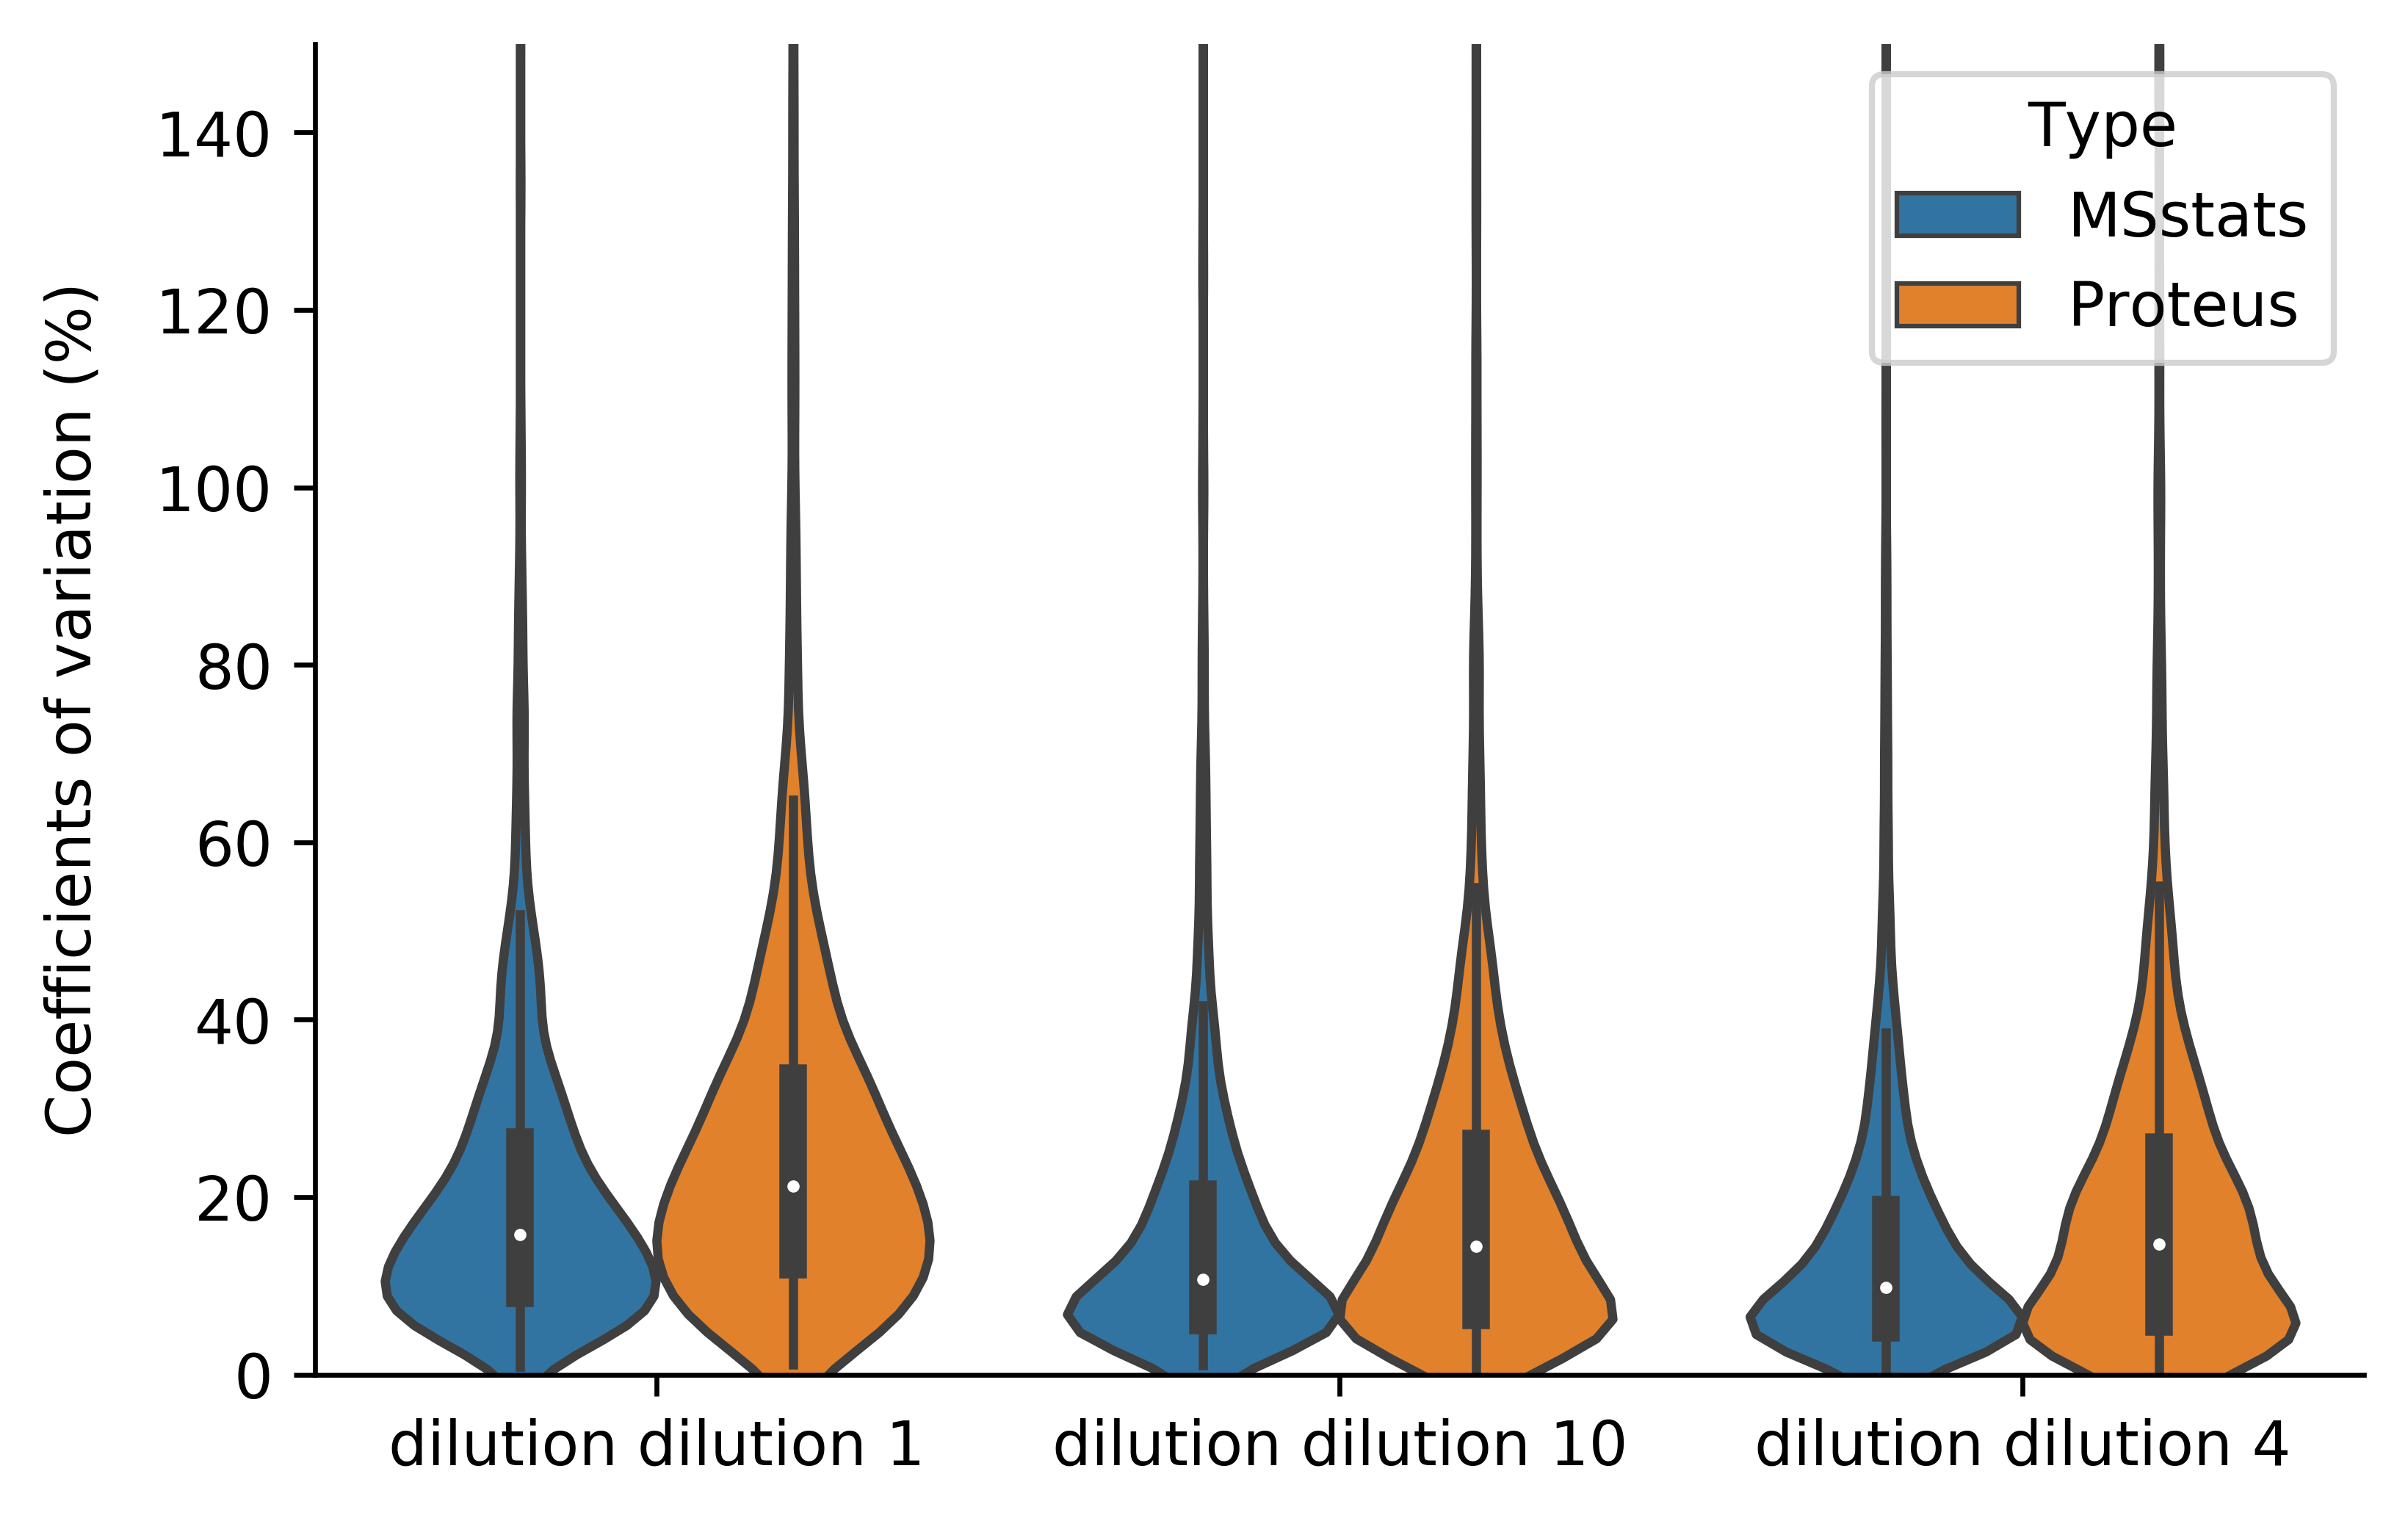

In [190]:
plt.figure(dpi=600)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0, 150)

msstats_no_normalization_cv["Condition"] = msstats_no_normalization_cv.apply(lambda x: "dilution " + str(x["Condition"]), axis=1)

# plt.title("Coefficients of variation (%)")
sns.violinplot(x = "Condition", y="CV[%]", data=msstats_no_normalization_cv, scale= "count", hue="Type")
# ax.get_legend().remove()
plt.ylabel("Coefficients of variation (%)", labelpad=8.5)
plt.xlabel("", labelpad=8.5)
plt.show()

In [183]:
msstats_no_normalization_cv.groupby("Type")["CV[%]"].mean()

Type
MSstats    16.851215
Proteus    21.324622
Name: CV[%], dtype: float64

In [67]:
em_msstats = pd.read_csv("./protein_expression.csv", sep=',', index_col=None)
em_msstats_1 = em_msstats[em_msstats["GROUP"] == "SP=Yeast;CT=Mixture;QY=1"]

em_msstats_pic = pd.DataFrame(None, columns=["ProteinName", "Log2(ratio)", "Log2(intensity)", "Group"])
em_msstats_comparison = pd.read_csv("./filter_em_comparison_res.csv")
em_msstats_comparison = em_msstats_comparison.dropna(subset=["pvalue"], how="any")

for prot, group in em_msstats_comparison.groupby("Protein"):
    for label, label_group in group.groupby("Label"):
        pg = em_msstats_1[em_msstats_1["Protein"] == prot]
        pg["LogIntensities"] = pg.apply(lambda x: np.log10(np.exp2(x["LogIntensities"])), axis=1)
        t1 = np.mean(pg["LogIntensities"])

        if "YEAST" not in prot:
            Group = "Human"
        elif "HUMAN" not in prot:
            if label == "4vs1":
                Group = "Yeast 4:1"
            else:
                Group = "Yeast 10:1"
        else:
            continue
        log2ratio = label_group["log2FC"].values[0]
        em_msstats_pic = em_msstats_pic.append({"ProteinName":prot, "Log2(ratio)": log2ratio, "Log2(intensity)": t1,
                                                           "Group": Group}, ignore_index=True)

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [68]:
em_msstats_pic.head()

ProteinName  Log2(ratio)  Log2(intensity)  Group
0   sp|A0AVK6|E2F8_HUMAN    -1.052453         6.799309  Human
1  sp|A0FGR8|ESYT2_HUMAN    -0.635790         6.812483  Human
2  sp|A0FGR8|ESYT2_HUMAN     0.324429         6.812483  Human
3  sp|A0JNW5|UH1BL_HUMAN    -0.709021         6.907567  Human
4  sp|A0JNW5|UH1BL_HUMAN    -0.239000         6.907567  Human

In [65]:
plt.rcParams['figure.dpi'] = 600  # 图形分辨率

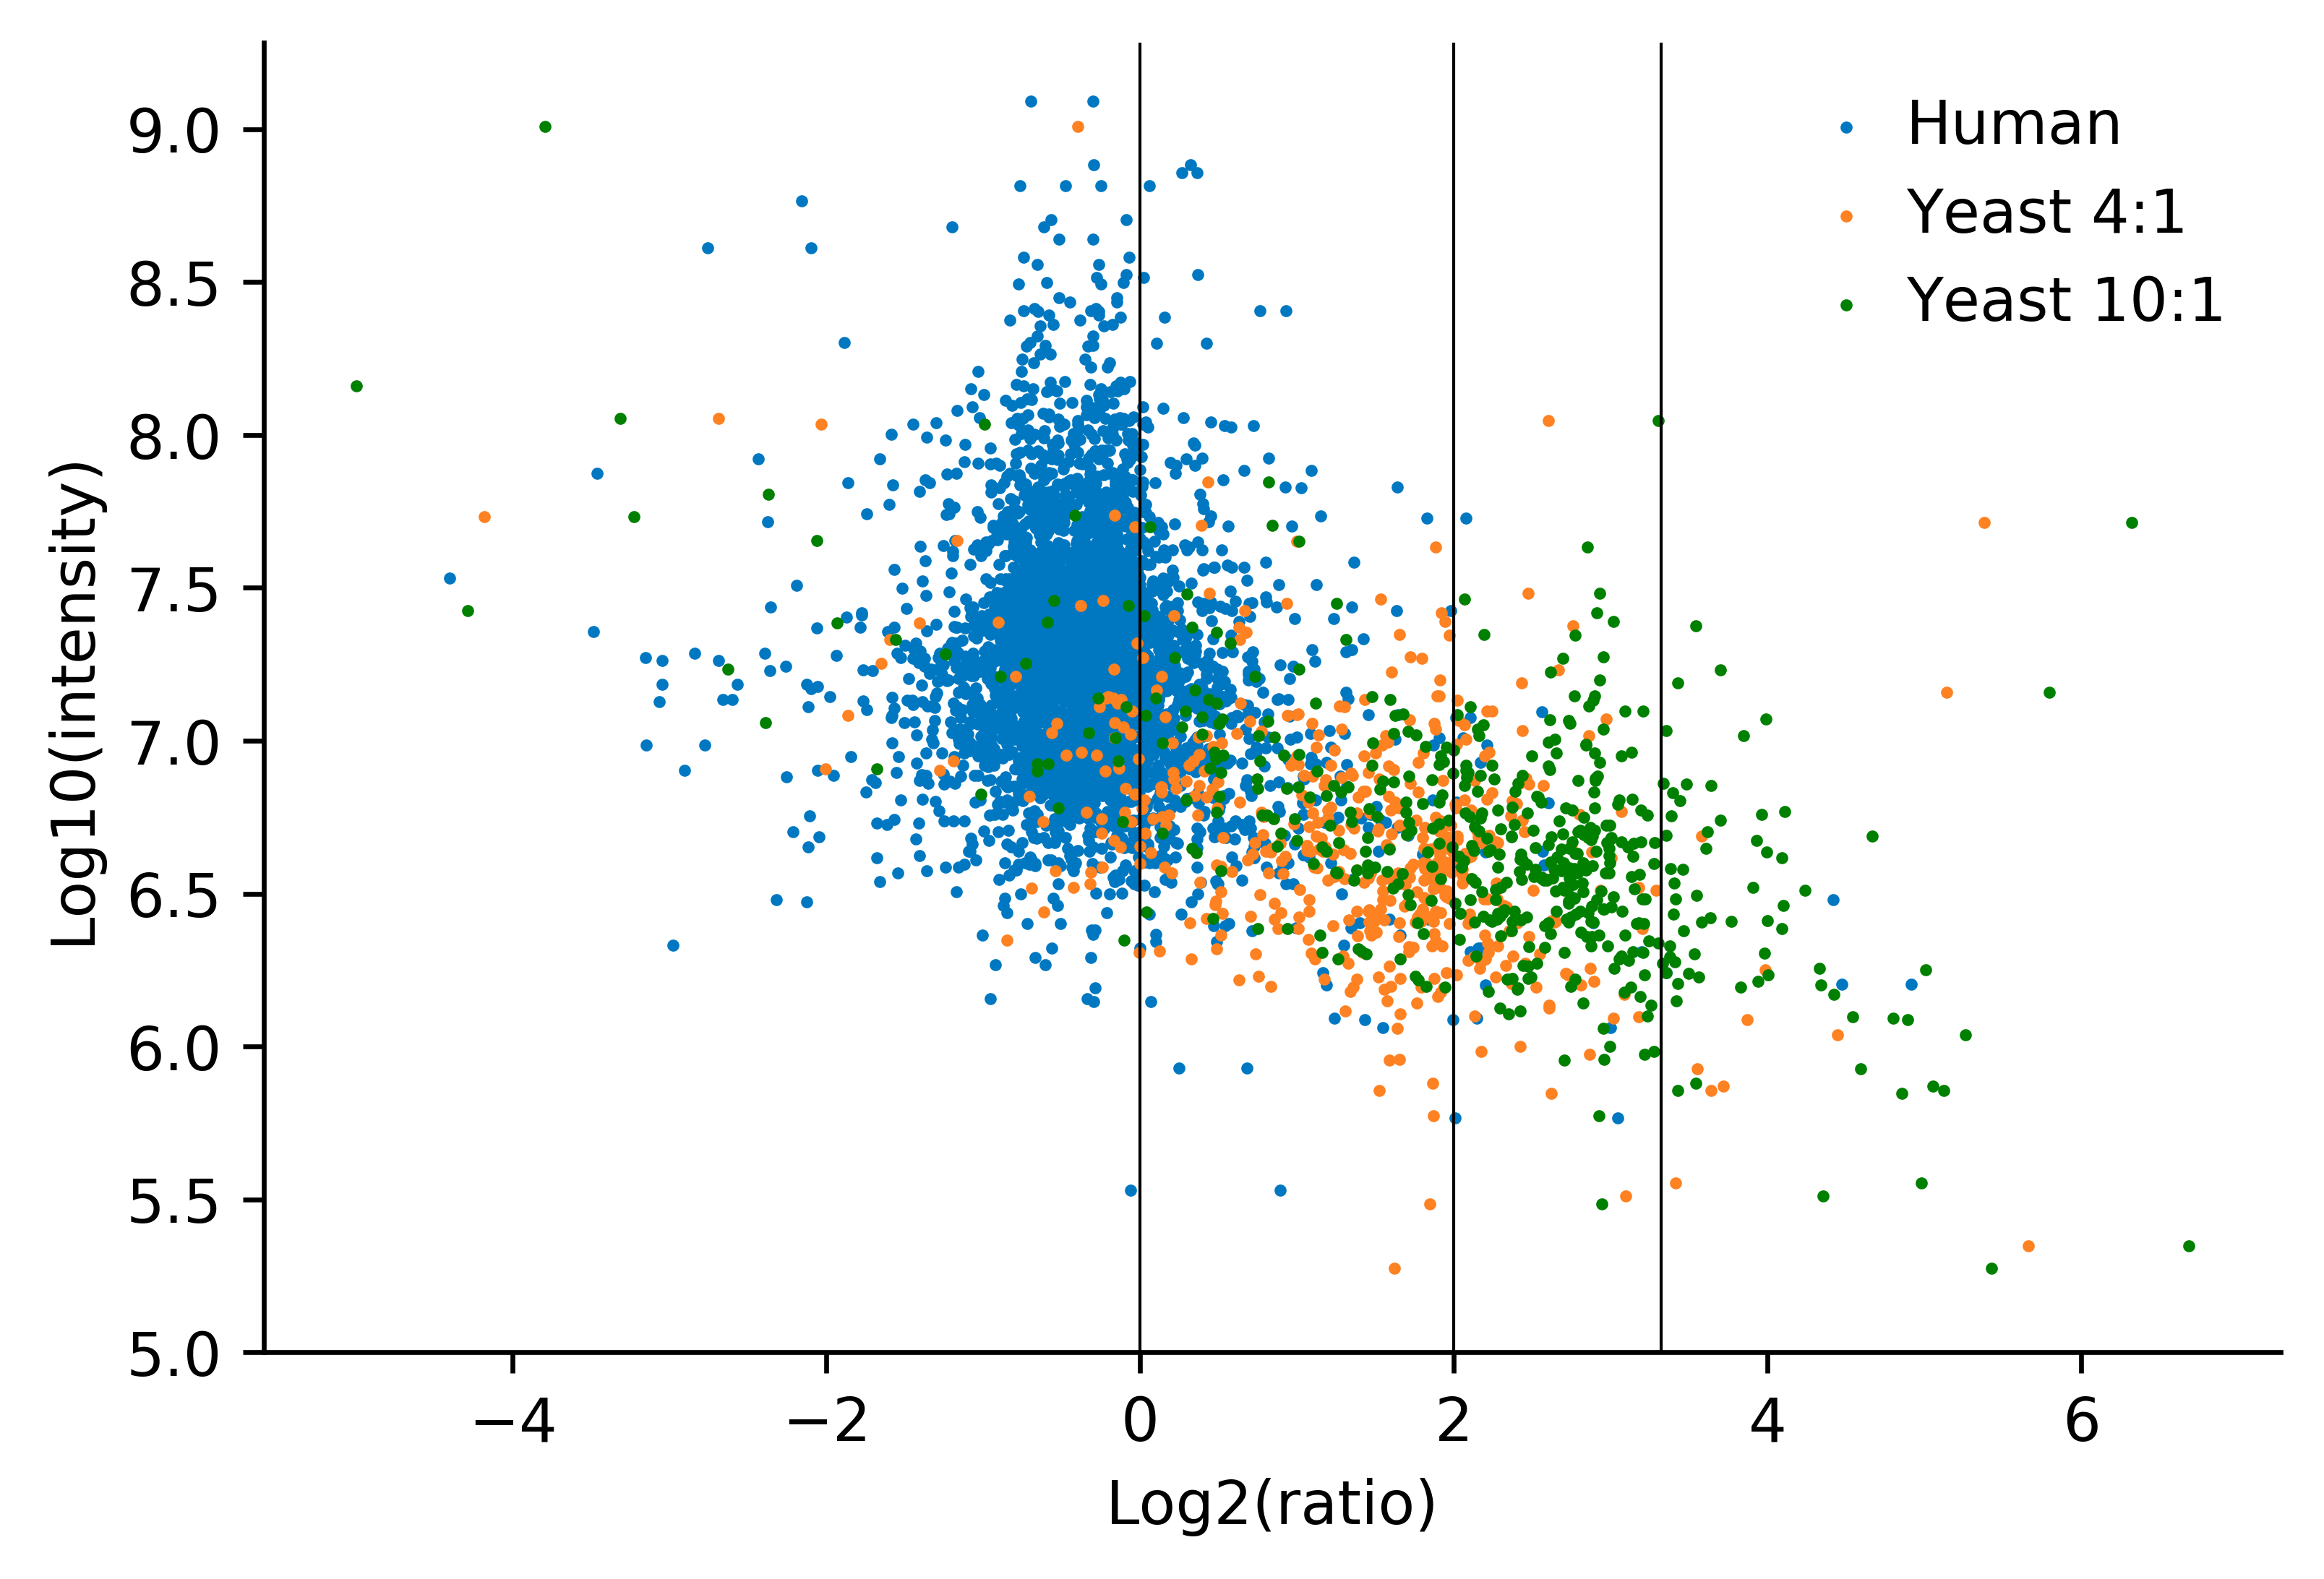

In [163]:
fig, ax = plt.subplots()

line1 = ax.scatter(em_msstats_pic[em_msstats_pic['Group'] == "Human"]["Log2(ratio)"], y=em_msstats_pic[em_msstats_pic['Group'] == "Human"]['Log2(intensity)'], c="#0078C1", s=1)

line2 = ax.scatter(em_msstats_pic[em_msstats_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"], y=em_msstats_pic[em_msstats_pic['Group'] == "Yeast 4:1"]['Log2(intensity)'], c="#FE8122", s=1)

line3 = ax.scatter(em_msstats_pic[em_msstats_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"], y=em_msstats_pic[em_msstats_pic['Group'] == "Yeast 10:1"]['Log2(intensity)'], c="green", s=1)

ax.axvline(x=0, c="black", linewidth=0.5, )
ax.axvline(x=2, c="black", linewidth=0.5, )
ax.axvline(x=np.log2(10), c="black", linewidth=0.5, )

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend(handles=[line1, line2, line3], labels=['Human', 'Yeast 4:1', "Yeast 10:1"], loc="best", frameon=False, handletextpad=0)

# plt.title("quantms+MSstats")
# plt.xlim(-2,4)
plt.ylim(5)
plt.xlabel("Log2(ratio)")
plt.ylabel("Log10(intensity)")
plt.show()

-0.3235881636484252
0.36199612798054875
1.3585110234935616
1.1769087661856268
2.190418361570302
1.9887934606114002


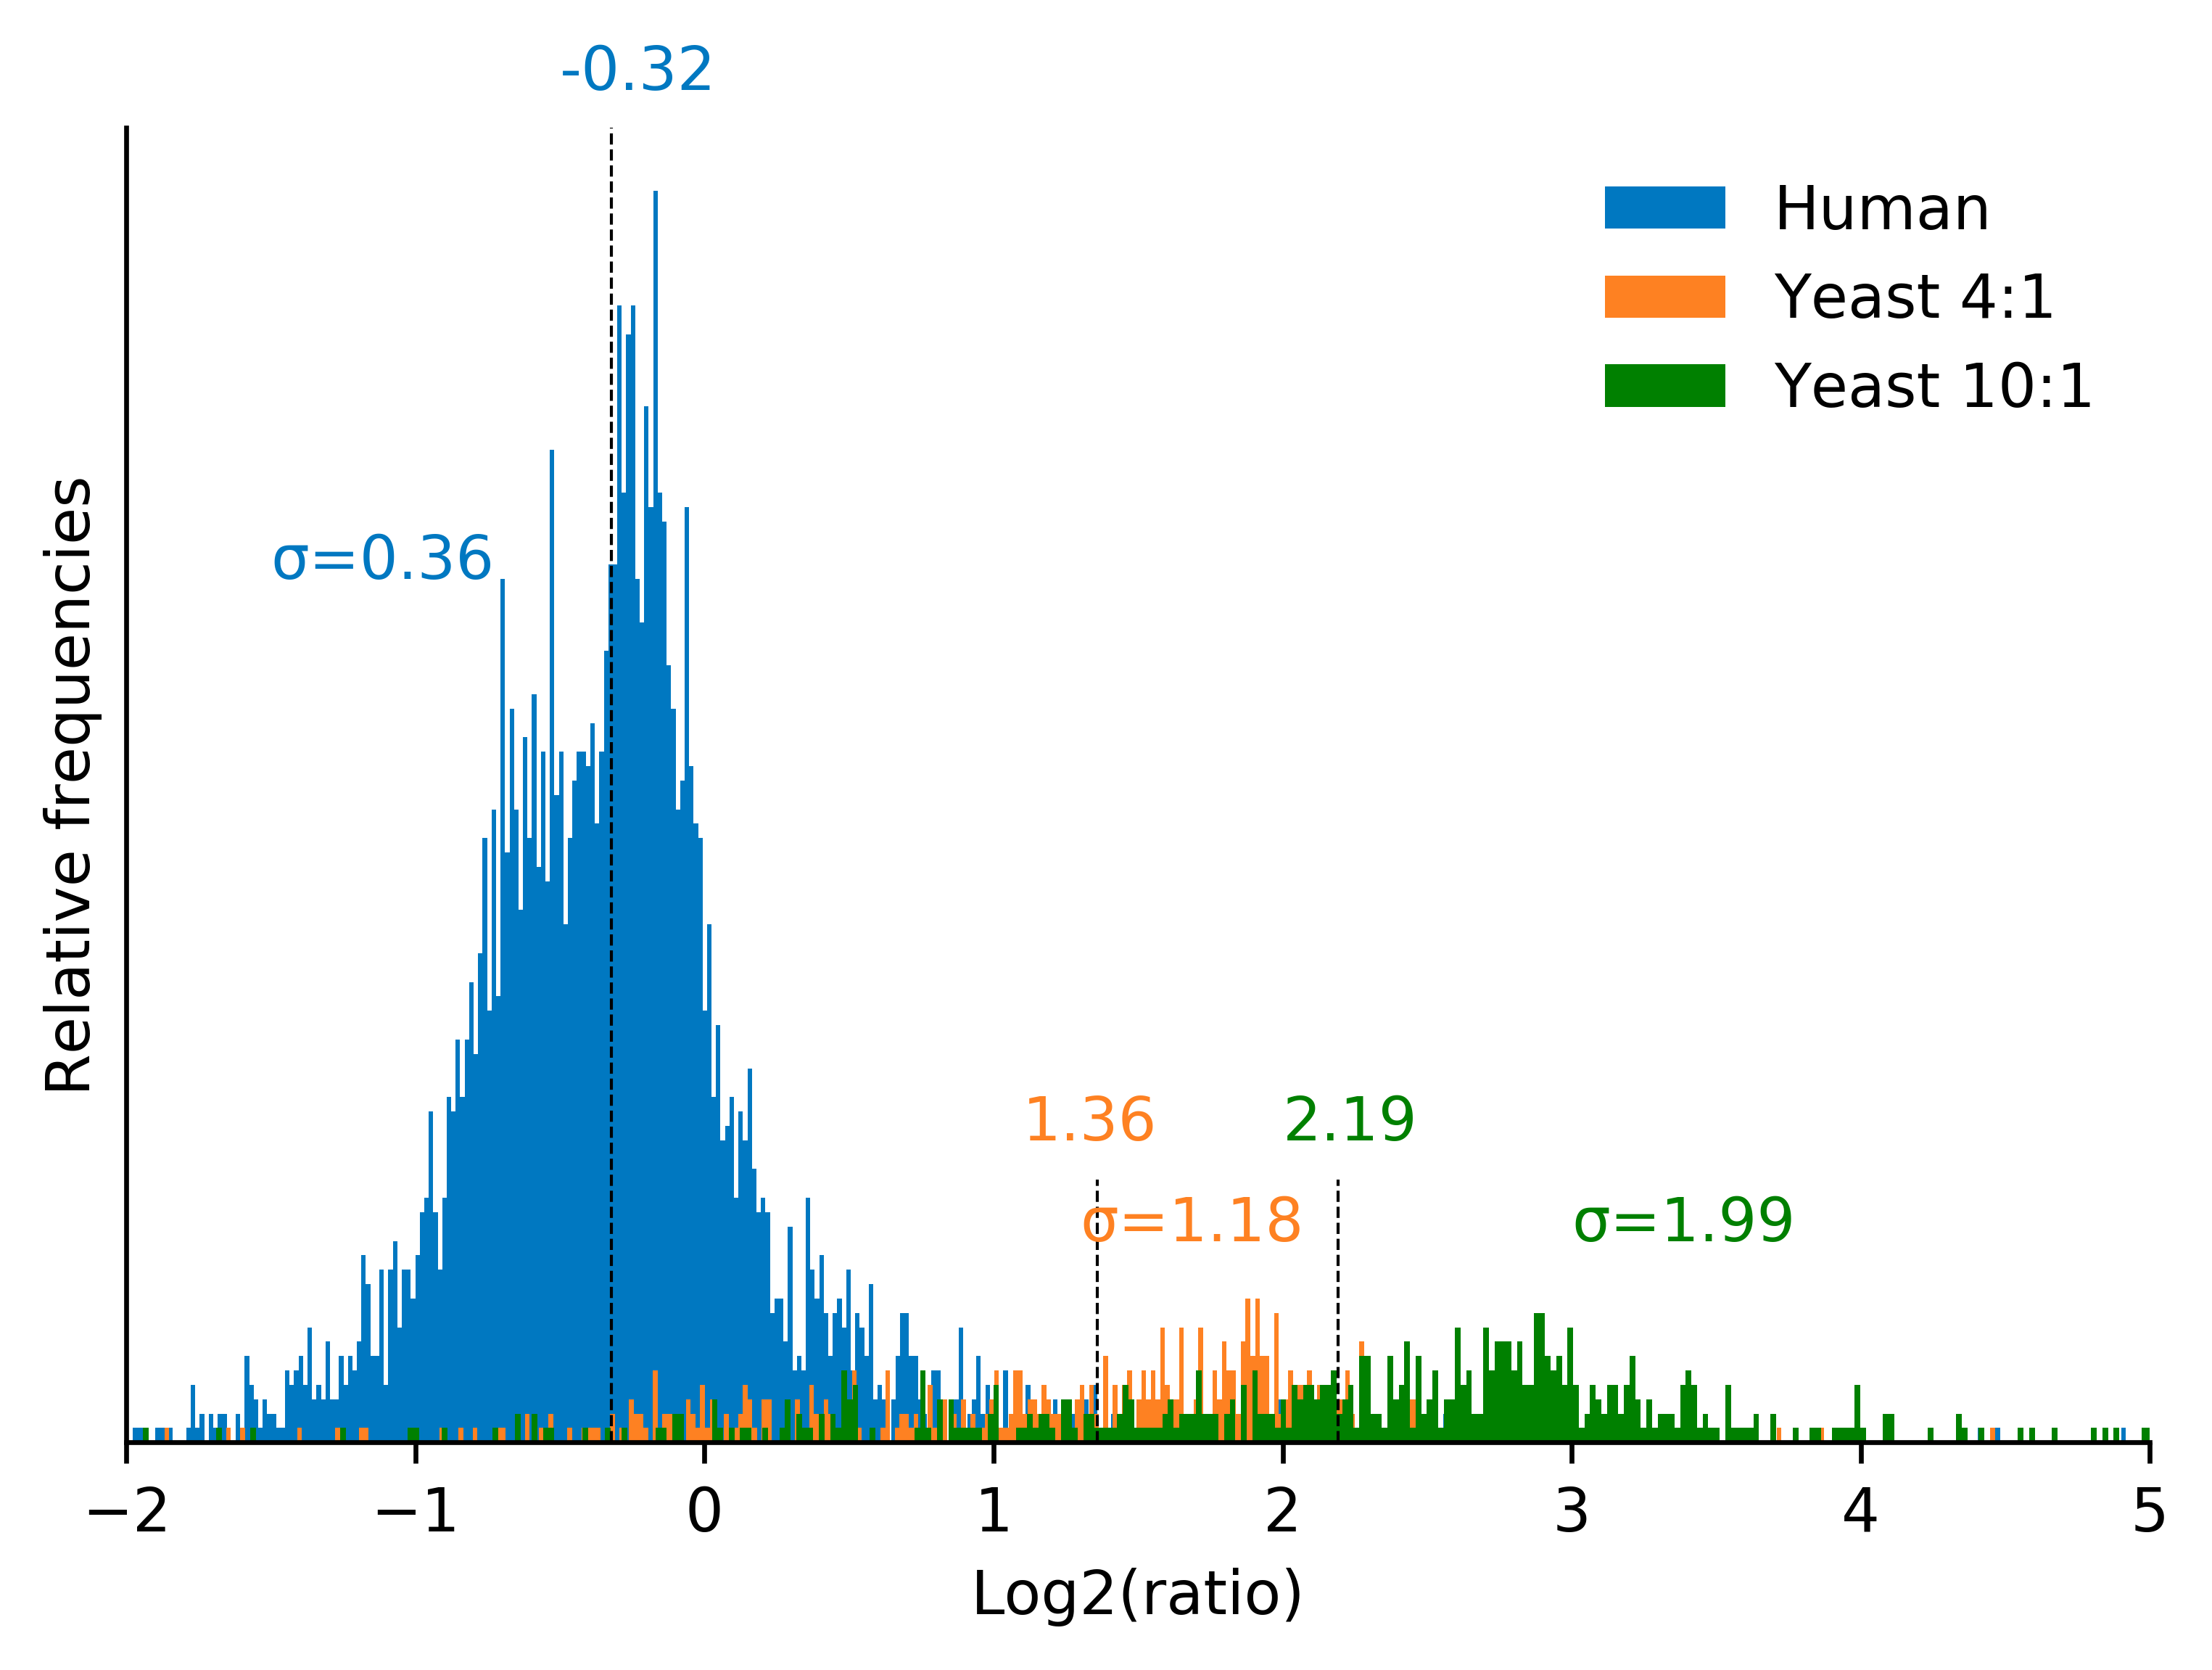

In [161]:
fig, ax = plt.subplots()

ax.hist(em_msstats_pic[em_msstats_pic['Group'] == "Human"]["Log2(ratio)"], bins=600, color="#0078C1")
u2 = np.mean(em_msstats_pic[em_msstats_pic['Group'] == "Human"]["Log2(ratio)"])
var2 = np.var(em_msstats_pic[em_msstats_pic['Group'] == "Human"]["Log2(ratio)"])
print(u2)
print(var2)

ax.hist(em_msstats_pic[em_msstats_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"], bins=600, color="#FE8122")
u1 = np.mean(em_msstats_pic[em_msstats_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"])
var1 = np.var(em_msstats_pic[em_msstats_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"])
print(u1)
print(var1)

ax.hist(em_msstats_pic[em_msstats_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"], bins=600, color="green")
u3 = np.mean(em_msstats_pic[em_msstats_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"])
var3 = np.var(em_msstats_pic[em_msstats_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"])
print(u3)
print(var3)

ax.legend(labels=['Human', 'Yeast 4:1', 'Yeast 10:1'], loc="best", frameon=False)

ax.axvline(x=1.3585110234935616, ymax=0.2, c="black", linewidth=0.5, ls="--")
ax.axvline(x=2.190418361570302, ymax=0.2, c="black", linewidth=0.5, ls="--")
ax.axvline(x=-0.3235881636484252, c="black", linewidth=0.5, ls="--")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.text(-0.5,94,"-0.32", color="#0078C1")
plt.text(1.1,21,"1.36", color="#FE8122")
plt.text(2,21,"2.19", color="green")

plt.text(-1.5,60,"σ=0.36", color="#0078C1")
plt.text(1.3,14,"σ=1.18", color="#FE8122")
plt.text(3,14,"σ=1.99", color="green")

plt.yticks([])
plt.xlabel("Log2(ratio)")
plt.ylabel("Relative frequencies")
plt.xlim(-2,5)
plt.show()

In [71]:
prodatmed_long.head()


ProteinName     MS runs     Intensity  LogIntensities TechRep  \
1  sp|A0FGR8|ESYT2_HUMAN  1_TechRep1  3.796020e+07       25.177984       1   
2  sp|A0JNW5|UH1BL_HUMAN  1_TechRep1  1.250433e+07       23.575924       1   
3  sp|A0MZ66|SHOT1_HUMAN  1_TechRep1  1.031766e+08       26.620541       1   
4  sp|A1L390|PKHG3_HUMAN  1_TechRep1  4.233266e+07       25.335268       1   
5  sp|A2A2Y4|FRMD3_HUMAN  1_TechRep1  3.574635e+07       25.091293       1   

  Condition  
1         1  
2         1  
3         1  
4         1  
5         1

In [76]:
prodatmed_long_1 = prodatmed_long[prodatmed_long["Condition"] == "1"]

em_proteus_pic = pd.DataFrame(None, columns=["ProteinName", "Log2(ratio)", "Log2(intensity)", "Group"])

em_proteus_comparison_4 = pd.read_csv("./prodat_med_comp_res_filter_4fc.csv")
em_proteus_comparison_4 = em_proteus_comparison_4[["protein", "logFC", "P.Value", "adj.P.Val"]]
em_proteus_comparison_4["Label"] = "4vs1"

em_proteus_comparison_10 = pd.read_csv("./prodat_med_comp_res_filter_10fc.csv")
em_proteus_comparison_10 = em_proteus_comparison_10[["protein", "logFC", "P.Value", "adj.P.Val"]]
em_proteus_comparison_10["Label"] = "10vs1"

em_proteus_comparison = em_proteus_comparison_4.append(em_proteus_comparison_10, ignore_index=True)

em_proteus_comparison = em_proteus_comparison.dropna(subset=["P.Value"], how="any")

for prot, group in em_proteus_comparison.groupby("protein"):
    for label, label_group in group.groupby("Label"):
        pg = prodatmed_long_1[prodatmed_long_1["ProteinName"] == prot]
        pg["LogIntensities"] = pg.apply(lambda x: np.log10(np.exp2(x["LogIntensities"])), axis=1)
        t1 = np.mean(pg["LogIntensities"])

        if "YEAST" not in prot:
            Group = "Human"
        elif "HUMAN" not in prot:
            if label == "4vs1":
                Group = "Yeast 4:1"
            else:
                Group = "Yeast 10:1"
        else:
            continue
        log2ratio = label_group["logFC"].values[0]
        em_proteus_pic = em_proteus_pic.append({"ProteinName":prot, "Log2(ratio)": log2ratio, "Log2(intensity)": t1,
                                                           "Group": Group}, ignore_index=True)

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [77]:
em_proteus_pic.head()

ProteinName  Log2(ratio)  Log2(intensity)  Group
0   sp|A0AVK6|E2F8_HUMAN    -0.852844         6.820933  Human
1  sp|A0FGR8|ESYT2_HUMAN    -1.255225         7.752608  Human
2  sp|A0FGR8|ESYT2_HUMAN     0.009961         7.752608  Human
3  sp|A0JNW5|UH1BL_HUMAN    -0.272636         7.034611  Human
4  sp|A0JNW5|UH1BL_HUMAN    -0.187096         7.034611  Human

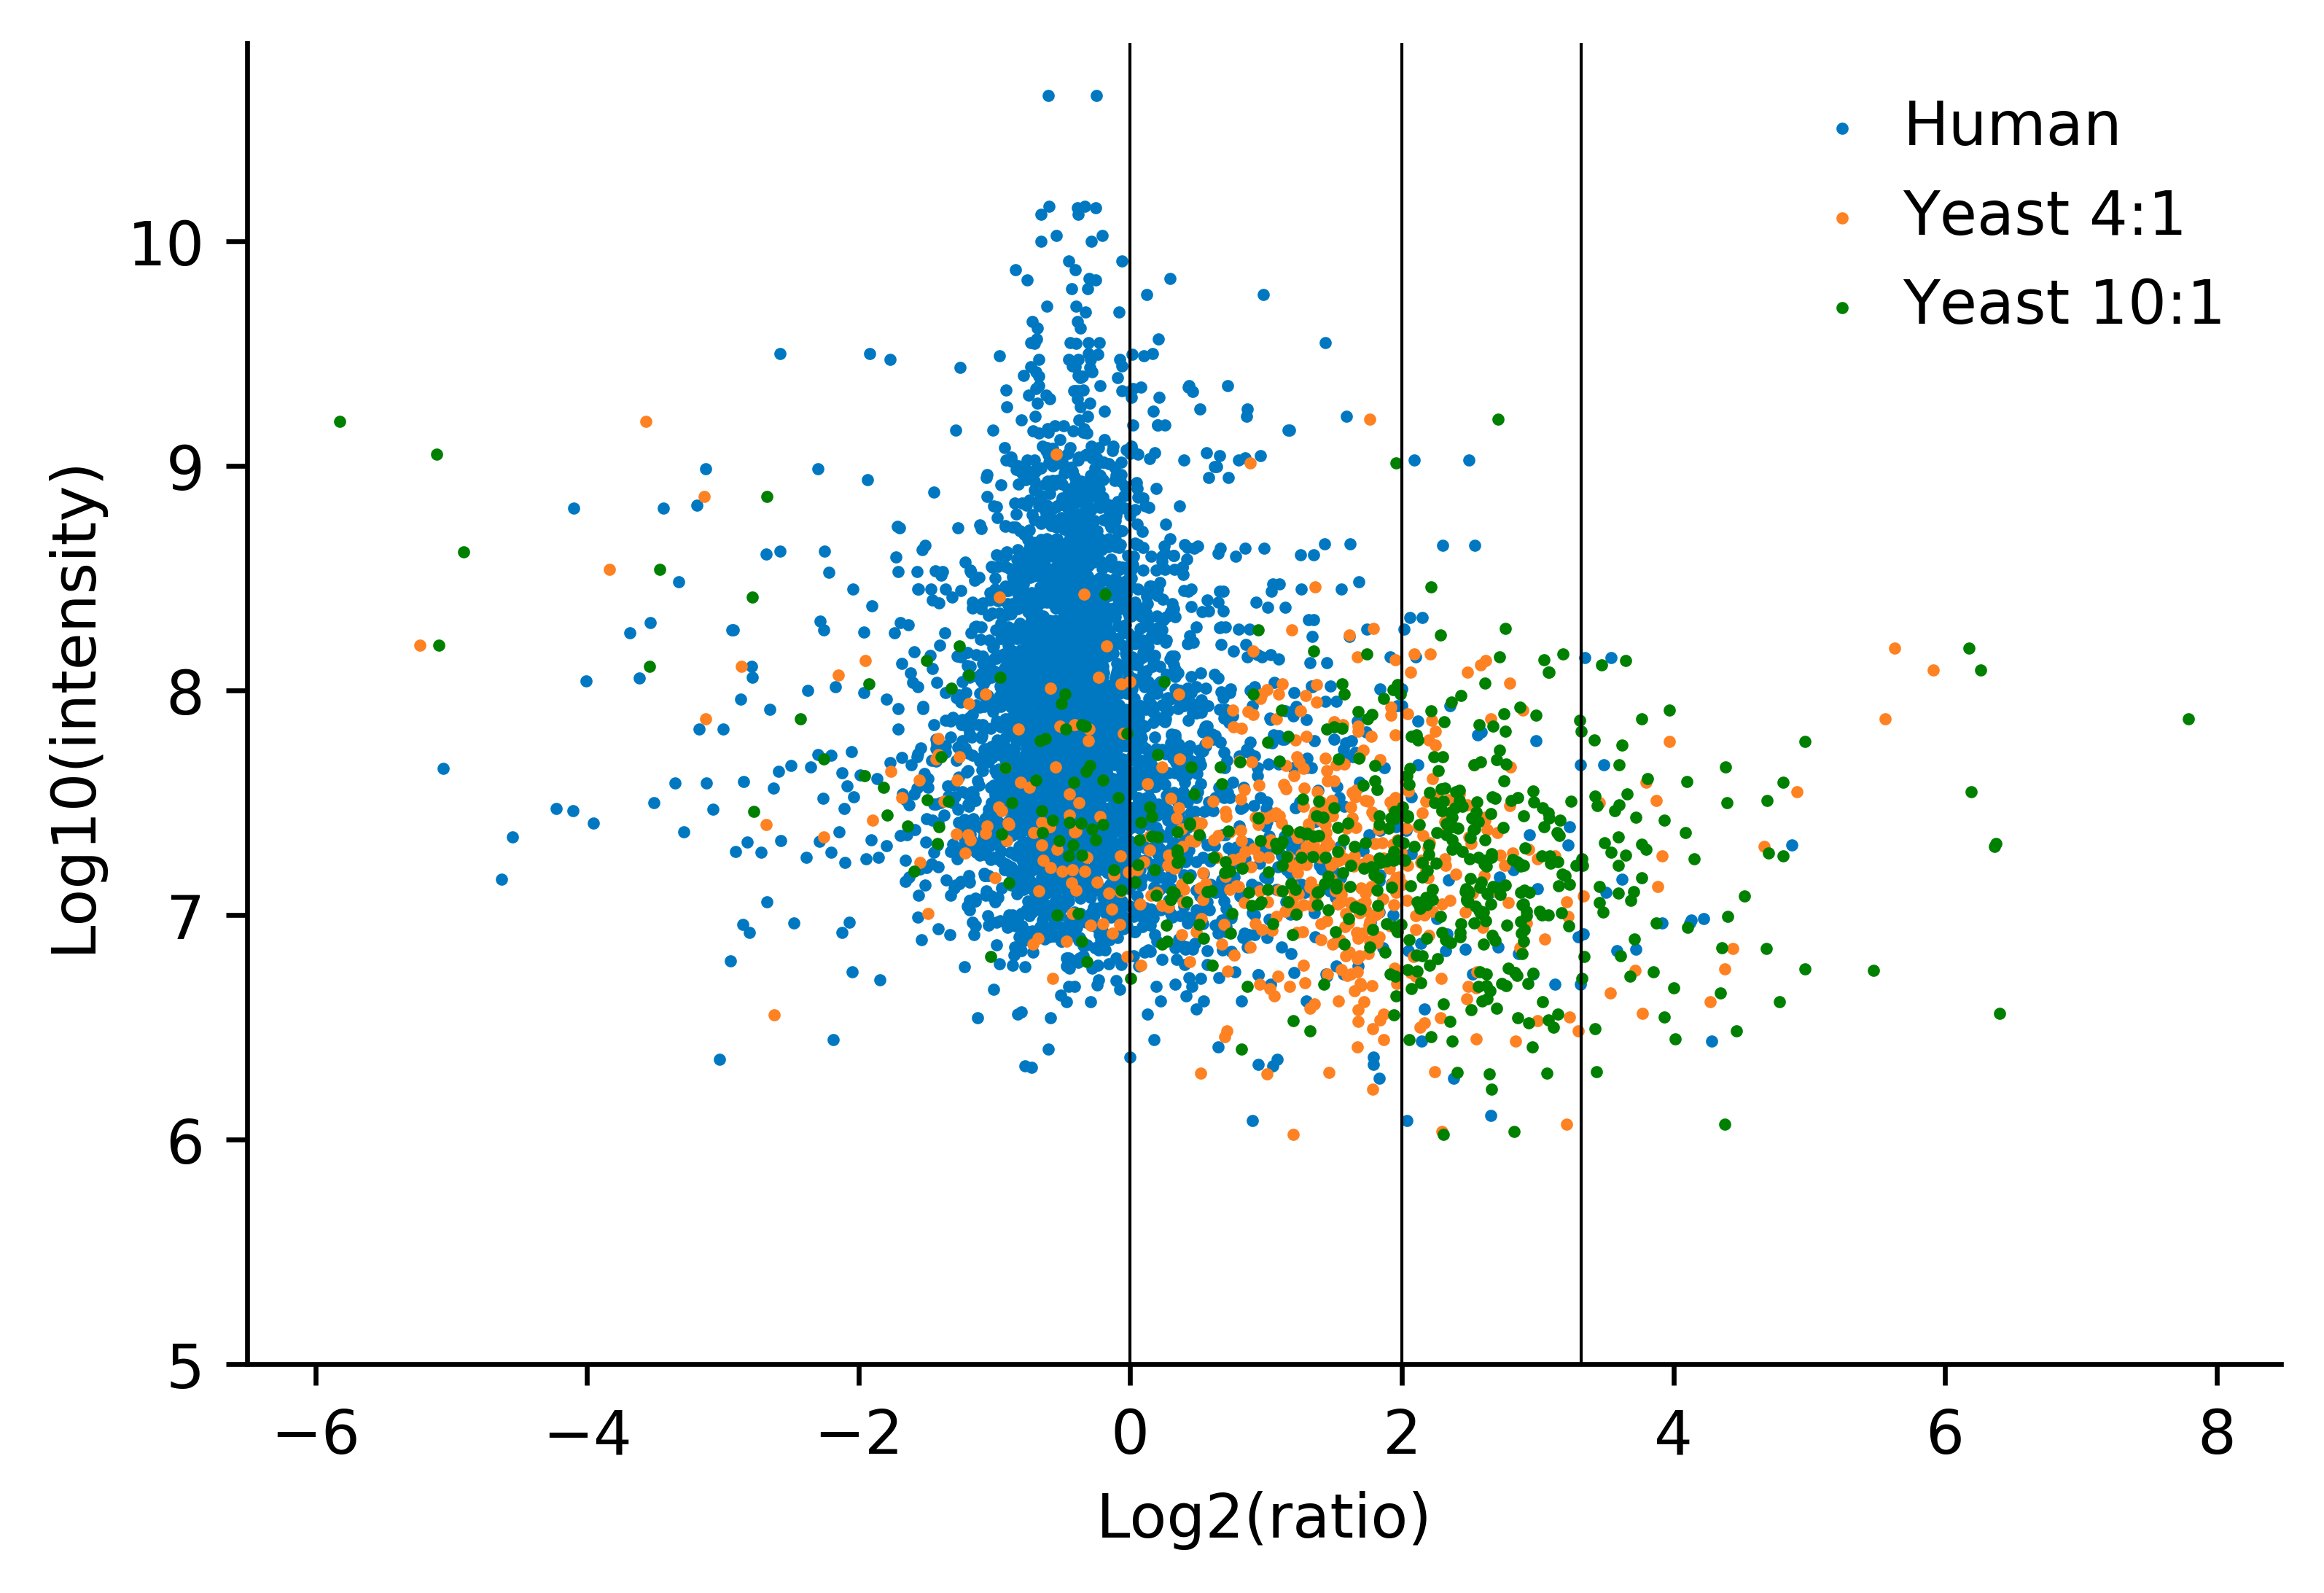

In [157]:
fig, ax = plt.subplots()

line1 = ax.scatter(em_proteus_pic[em_proteus_pic['Group'] == "Human"]["Log2(ratio)"], y=em_proteus_pic[em_proteus_pic['Group'] == "Human"]['Log2(intensity)'], c="#0078C1", s=1)

line2 = ax.scatter(em_proteus_pic[em_proteus_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"], y=em_proteus_pic[em_proteus_pic['Group'] == "Yeast 4:1"]['Log2(intensity)'], c="#FE8122", s=1)

line3 = ax.scatter(em_proteus_pic[em_proteus_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"], y=em_proteus_pic[em_proteus_pic['Group'] == "Yeast 10:1"]['Log2(intensity)'], c="green", s=1)

ax.axvline(x=0, c="black", linewidth=0.5, )
ax.axvline(x=2, c="black", linewidth=0.5, )
ax.axvline(x=np.log2(10), c="black", linewidth=0.5, )

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend(handles=[line1, line2, line3], labels=['Human', 'Yeast 4:1', "Yeast 10:1"], loc="best", frameon=False, handletextpad=0)

# plt.title("quantms+Proteus")
# plt.xlim(-2,4)
plt.ylim(5)
plt.xlabel("Log2(ratio)")
plt.ylabel("Log10(intensity)")
plt.show()

-0.3160212406773734
0.6025573070767006
1.1894200892681022
1.7805121727725488
1.8895560724968363
2.7577270598844716


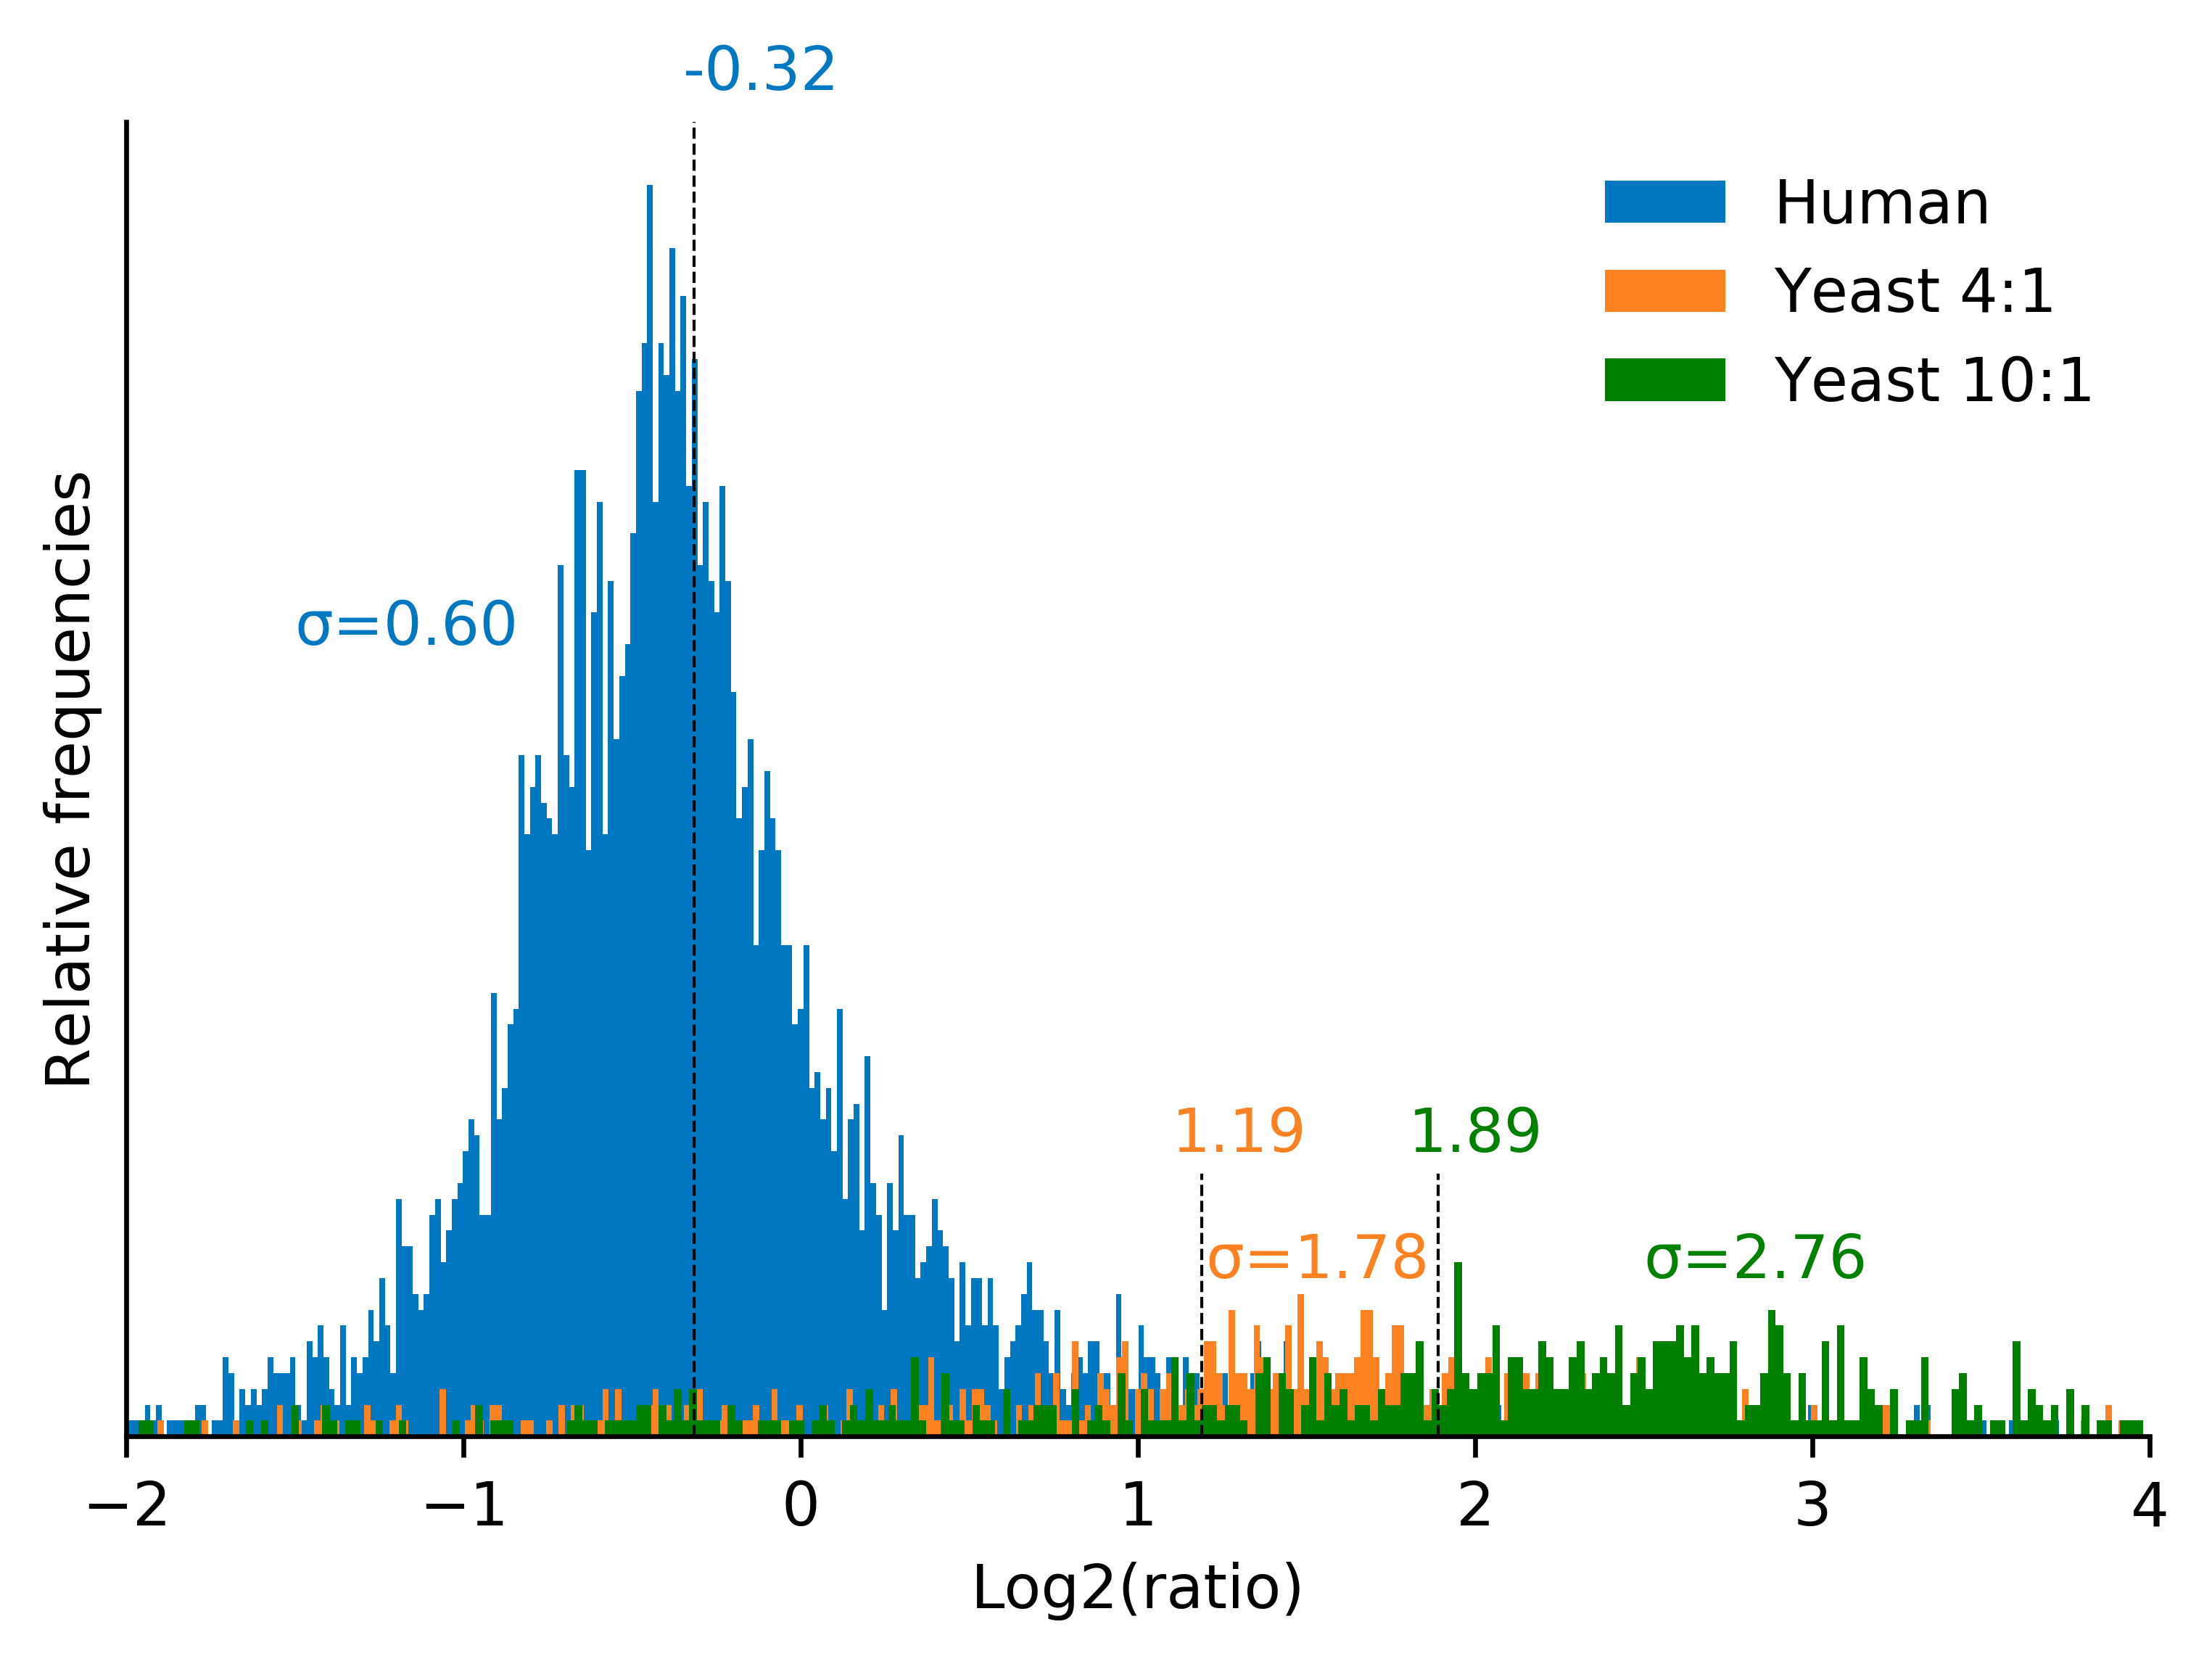

In [155]:
fig, ax = plt.subplots()

ax.hist(em_proteus_pic[em_proteus_pic['Group'] == "Human"]["Log2(ratio)"], bins=600, color="#0078C1")
u2 = np.mean(em_proteus_pic[em_proteus_pic['Group'] == "Human"]["Log2(ratio)"])
var2 = np.var(em_proteus_pic[em_proteus_pic['Group'] == "Human"]["Log2(ratio)"])
print(u2)
print(var2)

ax.hist(em_proteus_pic[em_proteus_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"], bins=600, color="#FE8122")
u1 = np.mean(em_proteus_pic[em_proteus_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"])
var1 = np.var(em_proteus_pic[em_proteus_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"])
print(u1)
print(var1)

ax.hist(em_proteus_pic[em_proteus_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"], bins=600, color="green")
u3 = np.mean(em_proteus_pic[em_proteus_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"])
var3 = np.var(em_proteus_pic[em_proteus_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"])
print(u3)
print(var3)

ax.legend(labels=['Human', 'Yeast 4:1', 'Yeast 10:1'], loc="best", frameon=False)

ax.axvline(x=1.1894200892681022, ymax=0.2, c="black", linewidth=0.5, ls="--")
ax.axvline(x=1.8895560724968363, ymax=0.2, c="black", linewidth=0.5, ls="--")
ax.axvline(x=-0.3160212406773734, c="black", linewidth=0.5, ls="--")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.text(-0.35,85,"-0.32", color="#0078C1")
plt.text(1.10,18,"1.19", color="#FE8122")
plt.text(1.8,18,"1.89", color="green")

plt.text(-1.5,50,"σ=0.60", color="#0078C1")
plt.text(1.2,10,"σ=1.78", color="#FE8122")
plt.text(2.5,10,"σ=2.76", color="green")

plt.yticks([])
plt.xlabel("Log2(ratio)")
plt.ylabel("Relative frequencies")
plt.xlim(-2,4)
plt.show()

### No normalization

In [91]:
no_normalization_msstats = pd.read_csv("./no_normalization_protein_expression.csv", sep=',', index_col=None)
no_normalization_msstats_1 = no_normalization_msstats[no_normalization_msstats["GROUP"] == "SP=Yeast;CT=Mixture;QY=1"]

no_normalization_msstats_pic = pd.DataFrame(None, columns=["ProteinName", "Log2(ratio)", "Log2(intensity)", "Group"])
no_normalization_msstats_comparison = pd.read_csv("./no_normalization_comparison_res_filter.csv")
no_normalization_msstats_comparison = no_normalization_msstats_comparison.dropna(subset=["pvalue"], how="any")

for prot, group in no_normalization_msstats_comparison.groupby("Protein"):
    for label, label_group in group.groupby("Label"):
        pg = no_normalization_msstats_1[no_normalization_msstats_1["Protein"] == prot]
        pg["LogIntensities"] = pg.apply(lambda x: np.log10(np.exp2(x["LogIntensities"])), axis=1)
        t1 = np.mean(pg["LogIntensities"])

        if "YEAST" not in prot:
            Group = "Human"
        elif "HUMAN" not in prot:
            if label == "4vs1":
                Group = "Yeast 4:1"
            else:
                Group = "Yeast 10:1"
        else:
            continue
        log2ratio = label_group["log2FC"].values[0]
        no_normalization_msstats_pic = no_normalization_msstats_pic.append({"ProteinName":prot, "Log2(ratio)": log2ratio, "Log2(intensity)": t1,
                                                           "Group": Group}, ignore_index=True)

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


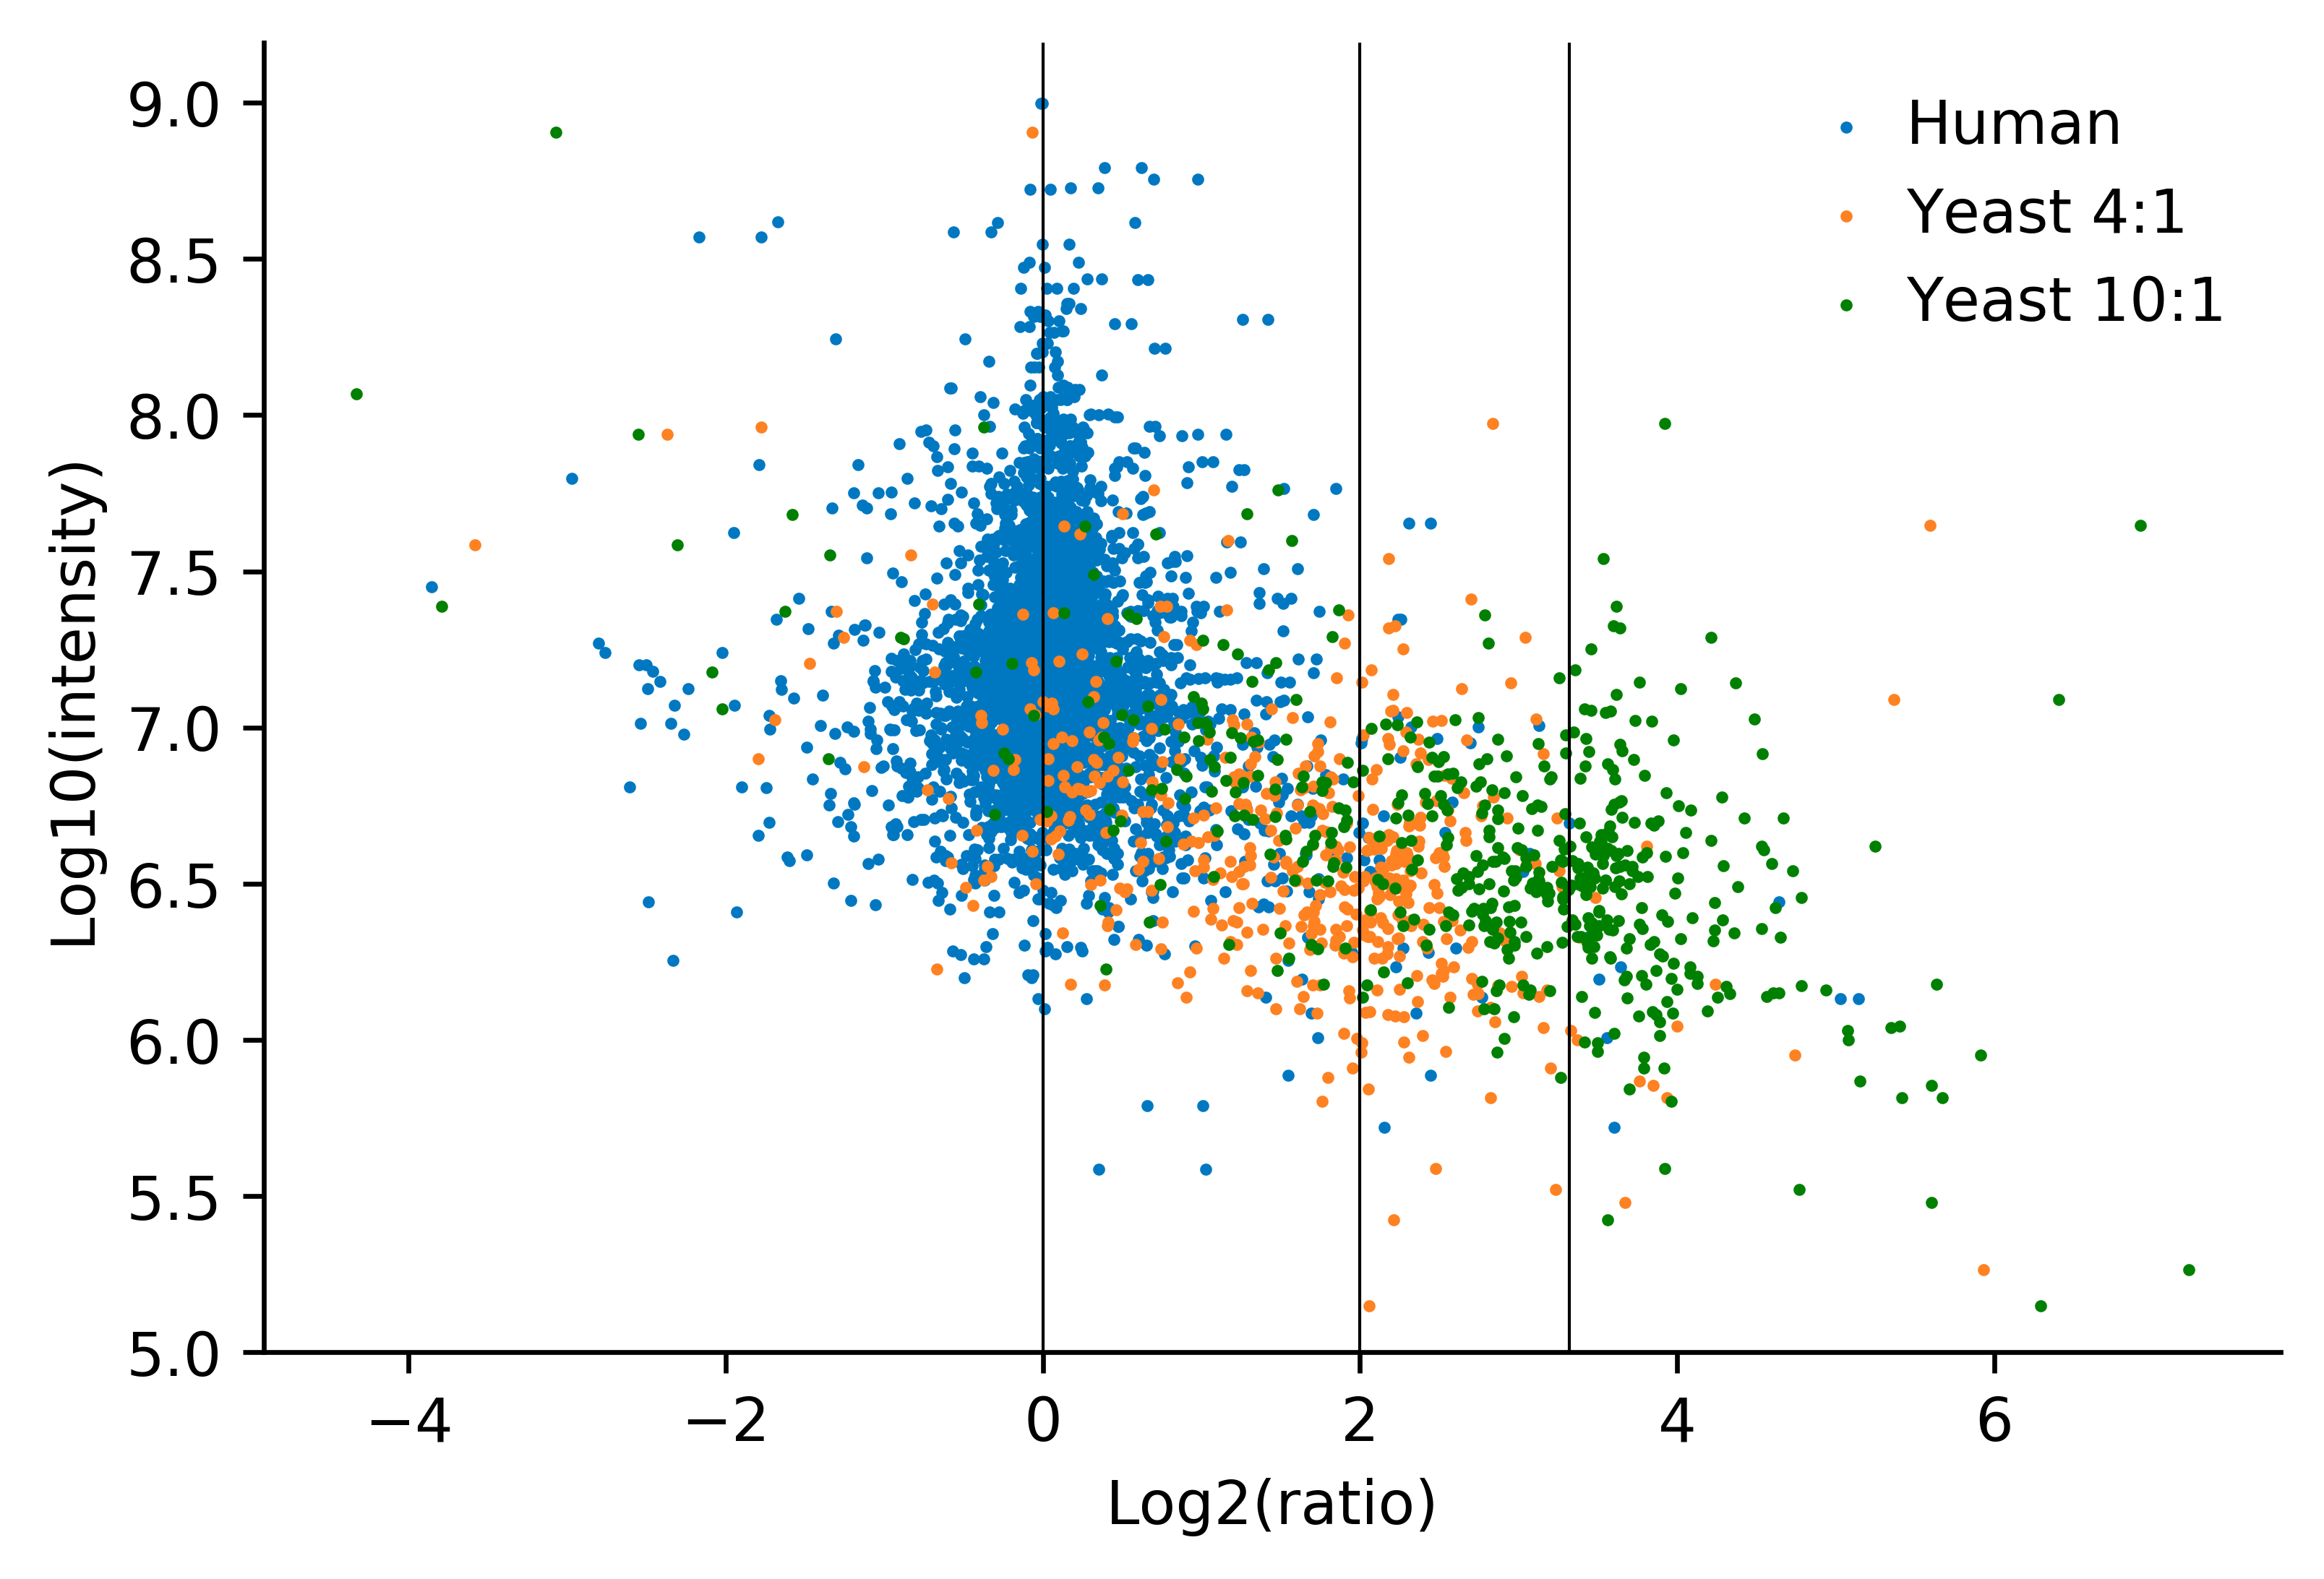

In [152]:
fig, ax = plt.subplots()

line1 = ax.scatter(no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Human"]["Log2(ratio)"], y=no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Human"]['Log2(intensity)'], c="#0078C1", s=1)

line2 = ax.scatter(no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"], y=no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Yeast 4:1"]['Log2(intensity)'], c="#FE8122", s=1)

line3 = ax.scatter(no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"], y=no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Yeast 10:1"]['Log2(intensity)'], c="green", s=1)

ax.axvline(x=0, c="black", linewidth=0.5, )
ax.axvline(x=2, c="black", linewidth=0.5, )
ax.axvline(x=np.log2(10), c="black", linewidth=0.5, )

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend(handles=[line1, line2, line3], labels=['Human', 'Yeast 4:1', "Yeast 10:1"], loc="best", frameon=False, handletextpad=0)

# plt.title("quantms+MSstats")
# plt.xlim(-2,4)
plt.ylim(5)
plt.xlabel("Log2(ratio)")
plt.ylabel("Log10(intensity)")
plt.show()

0.07767479564189653
0.31993886025716534
1.5922479895829165
1.238840989812475
2.7713066060895053
2.1027645010847067


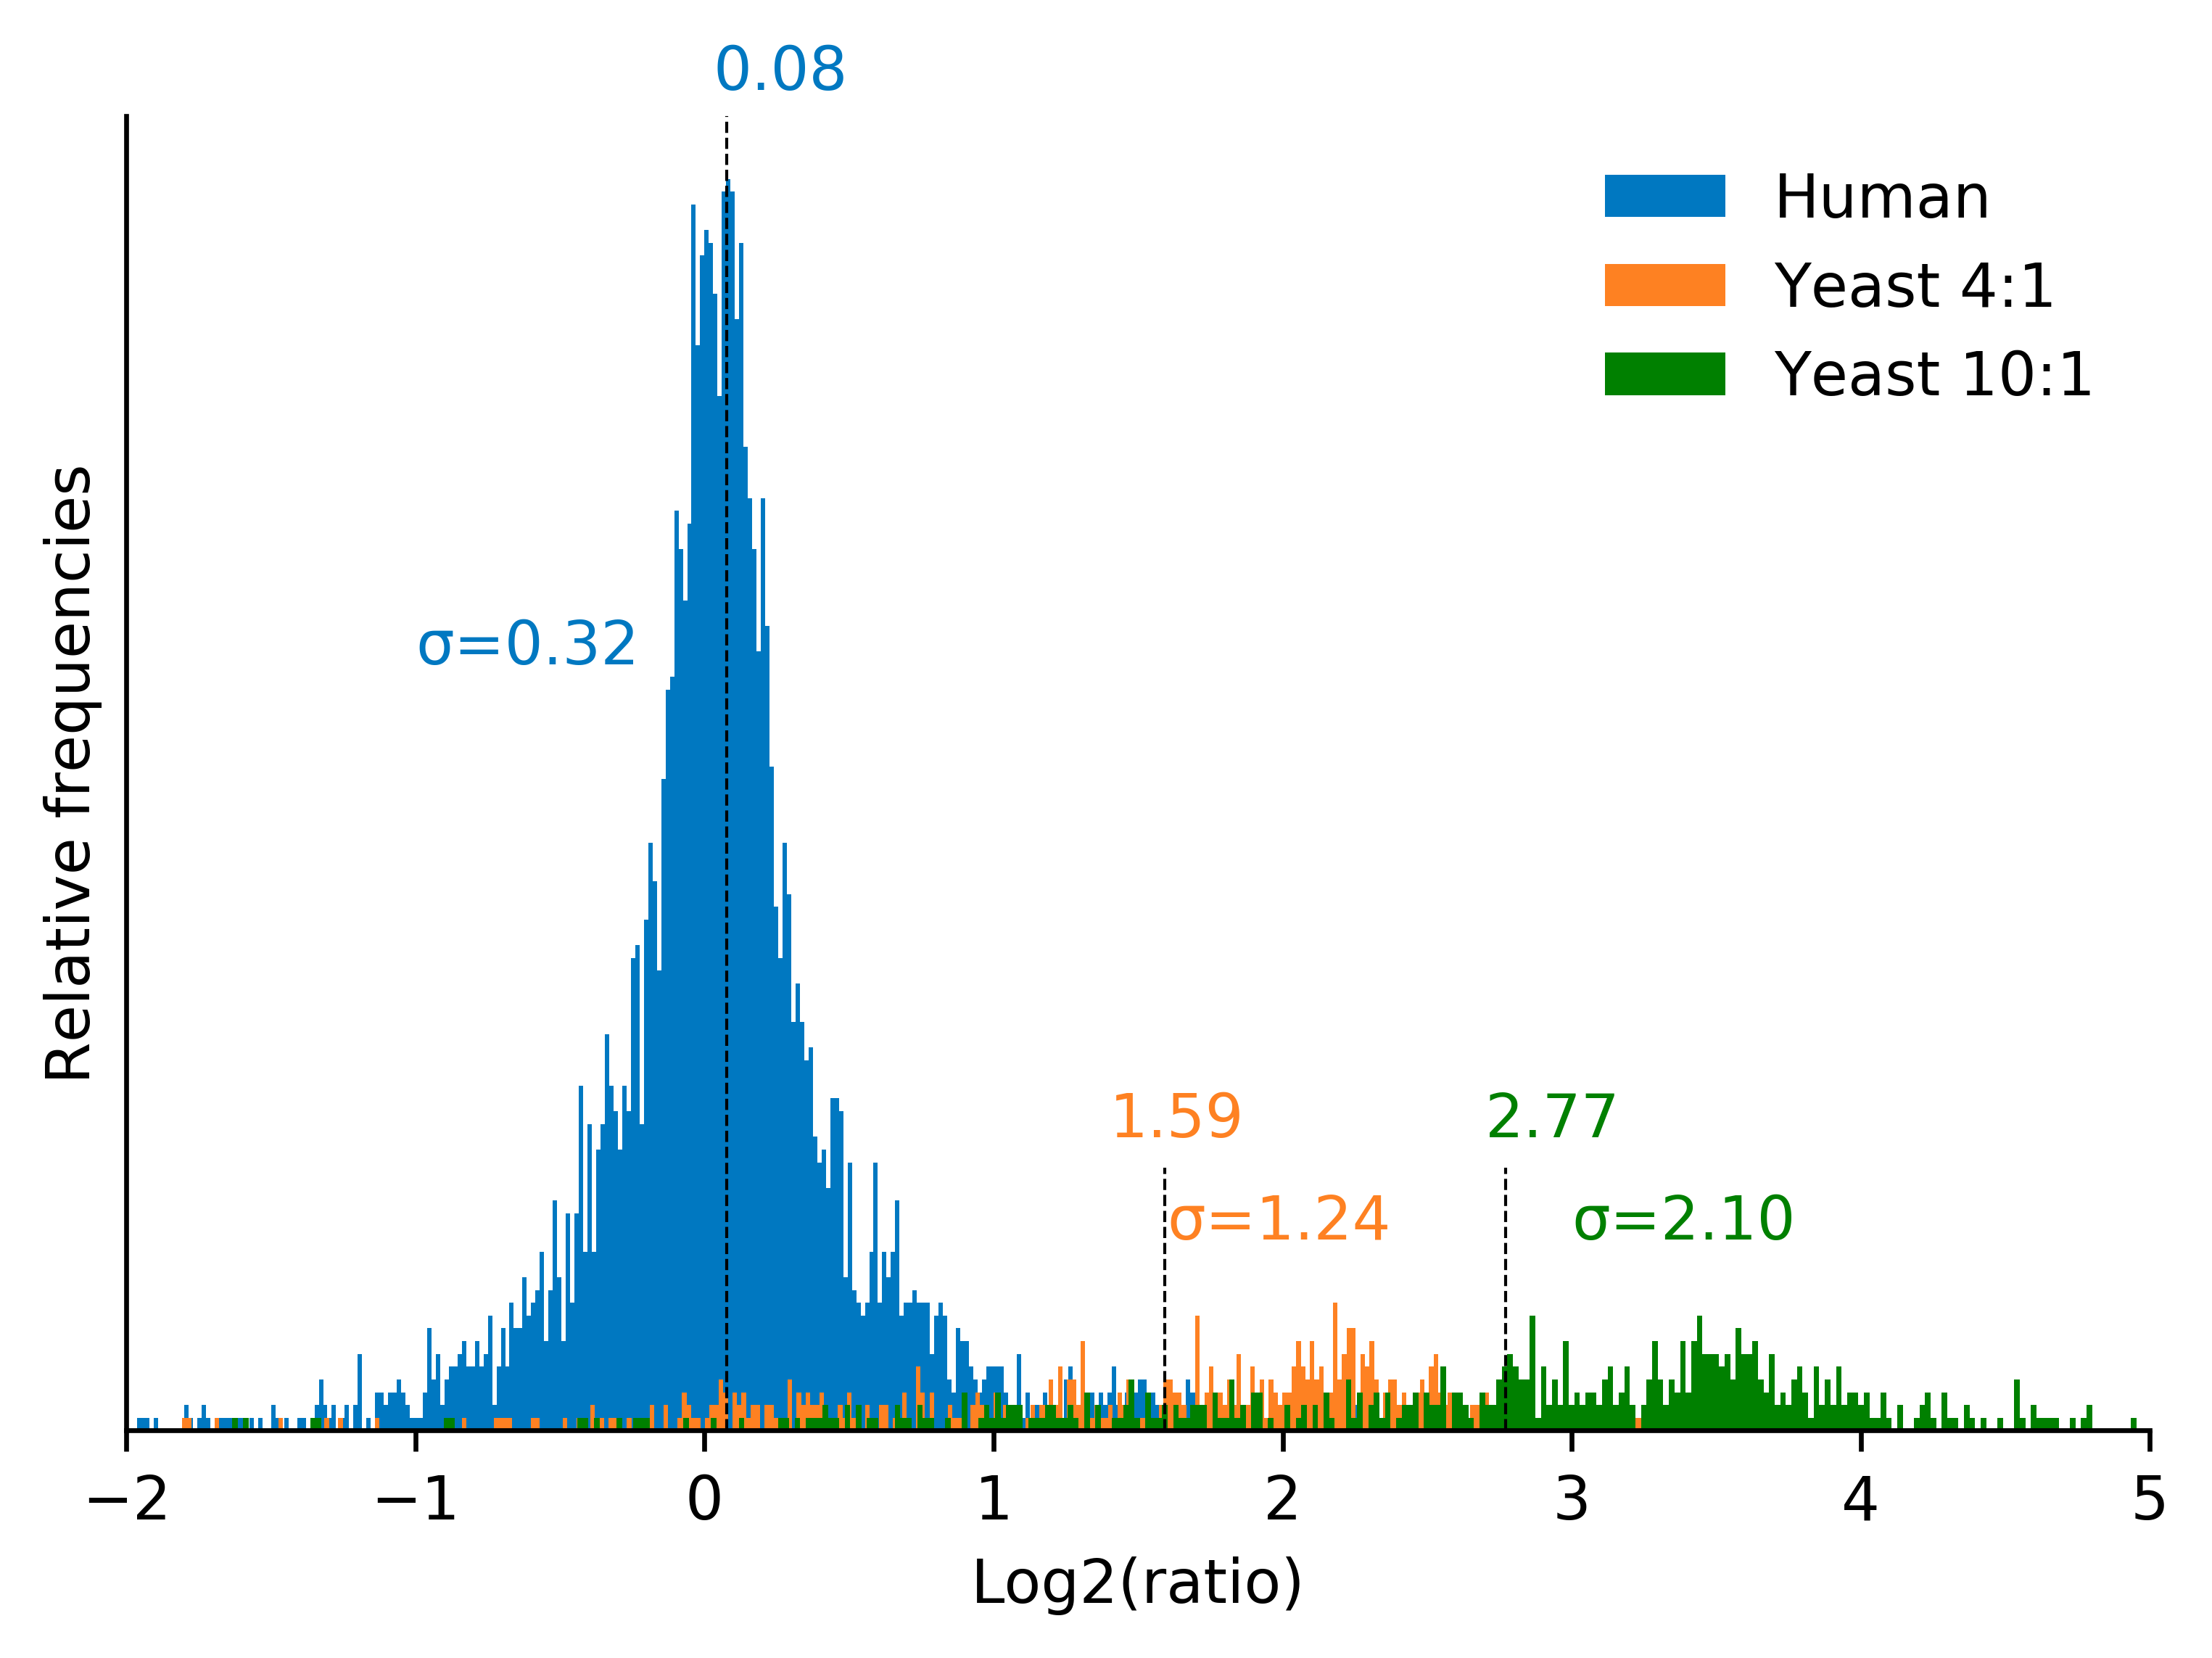

In [151]:
fig, ax = plt.subplots()

ax.hist(no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Human"]["Log2(ratio)"], bins=600, color="#0078C1")
u2 = np.mean(no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Human"]["Log2(ratio)"])
var2 = np.var(no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Human"]["Log2(ratio)"])
print(u2)
print(var2)

ax.hist(no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"], bins=600, color="#FE8122")
u1 = np.mean(no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"])
var1 = np.var(no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"])
print(u1)
print(var1)

ax.hist(no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"], bins=600, color="green")
u3 = np.mean(no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"])
var3 = np.var(no_normalization_msstats_pic[no_normalization_msstats_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"])
print(u3)
print(var3)

ax.legend(labels=['Human', 'Yeast 4:1', 'Yeast 10:1'], loc="best", frameon=False)

ax.axvline(x=1.5922479895829165, ymax=0.2, c="black", linewidth=0.5, ls="--")
ax.axvline(x=2.7713066060895053, ymax=0.2, c="black", linewidth=0.5, ls="--")
ax.axvline(x=0.07767479564189653, c="black", linewidth=0.5, ls="--")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.text(0.03,105,"0.08", color="#0078C1")
plt.text(1.4,23,"1.59", color="#FE8122")
plt.text(2.7,23,"2.77", color="green")

plt.text(-1,60,"σ=0.32", color="#0078C1")
plt.text(1.6,15,"σ=1.24", color="#FE8122")
plt.text(3,15,"σ=2.10", color="green")

plt.yticks([])
plt.xlabel("Log2(ratio)")
plt.ylabel("Relative frequencies")
plt.xlim(-2,5)
plt.show()

In [97]:
prodat_long_1 = prodat_long[prodat_long["Condition"] == "1"]

no_normalization_proteus_pic = pd.DataFrame(None, columns=["ProteinName", "Log2(ratio)", "Log2(intensity)", "Group"])

no_normalization_proteus_comparison_4 = pd.read_csv("./prodat_med_comp_res_filter_4fc.csv")
no_normalization_proteus_comparison_4 = no_normalization_proteus_comparison_4[["protein", "logFC", "P.Value", "adj.P.Val"]]
no_normalization_proteus_comparison_4["Label"] = "4vs1"

no_normalization_proteus_comparison_10 = pd.read_csv("./prodat_med_comp_res_filter_10fc.csv")
no_normalization_proteus_comparison_10 = no_normalization_proteus_comparison_10[["protein", "logFC", "P.Value", "adj.P.Val"]]
no_normalization_proteus_comparison_10["Label"] = "10vs1"

no_normalization_proteus_comparison = no_normalization_proteus_comparison_4.append(no_normalization_proteus_comparison_10, ignore_index=True)

no_normalization_proteus_comparison = no_normalization_proteus_comparison.dropna(subset=["P.Value"], how="any")

for prot, group in no_normalization_proteus_comparison.groupby("protein"):
    for label, label_group in group.groupby("Label"):
        pg = prodat_long_1[prodat_long_1["ProteinName"] == prot]
        pg["LogIntensities"] = pg.apply(lambda x: np.log10(np.exp2(x["LogIntensities"])), axis=1)
        t1 = np.mean(pg["LogIntensities"])

        if "YEAST" not in prot:
            Group = "Human"
        elif "HUMAN" not in prot:
            if label == "4vs1":
                Group = "Yeast 4:1"
            else:
                Group = "Yeast 10:1"
        else:
            continue
        log2ratio = label_group["logFC"].values[0]
        no_normalization_proteus_pic = no_normalization_proteus_pic.append({"ProteinName":prot, "Log2(ratio)": log2ratio, "Log2(intensity)": t1,
                                                           "Group": Group}, ignore_index=True)

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


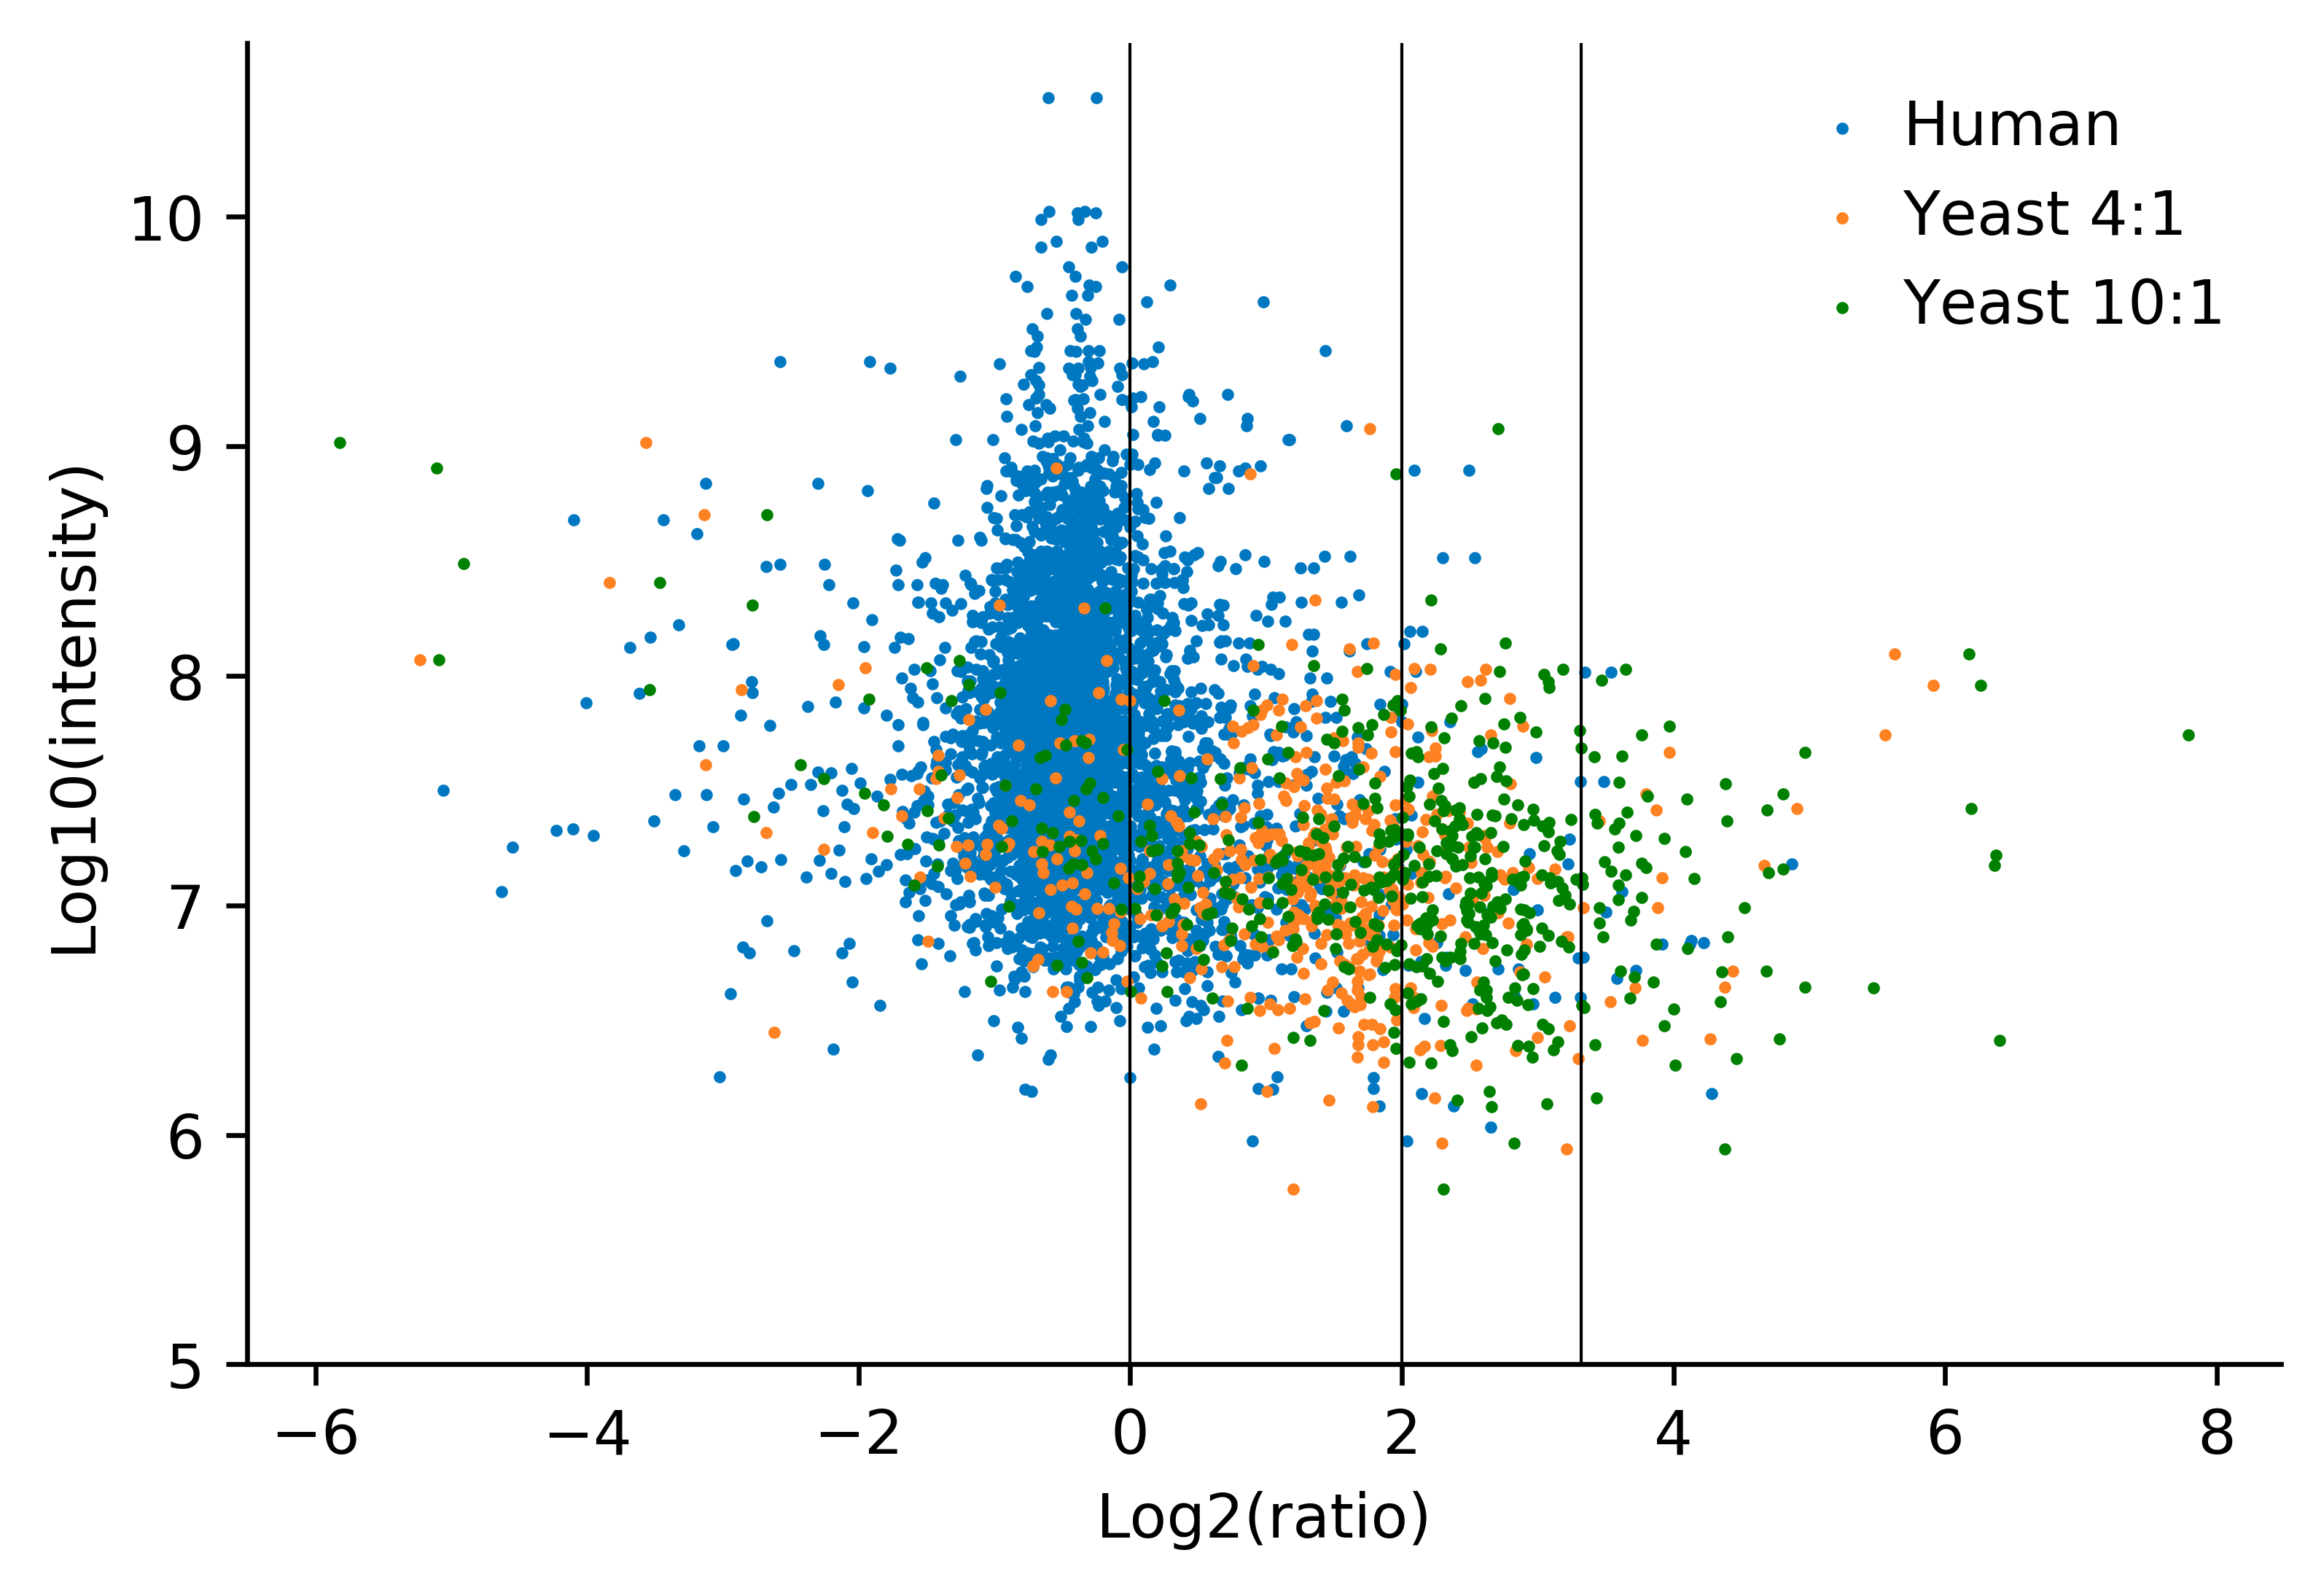

In [147]:
fig, ax = plt.subplots()

line1 = ax.scatter(no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Human"]["Log2(ratio)"], y=no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Human"]['Log2(intensity)'], c="#0078C1", s=1)

line2 = ax.scatter(no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"], y=no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Yeast 4:1"]['Log2(intensity)'], c="#FE8122", s=1)

line3 = ax.scatter(no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"], y=no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Yeast 10:1"]['Log2(intensity)'], c="green", s=1)

ax.axvline(x=0, c="black", linewidth=0.5, )
ax.axvline(x=2, c="black", linewidth=0.5, )
ax.axvline(x=np.log2(10), c="black", linewidth=0.5, )

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend(handles=[line1, line2, line3], labels=['Human', 'Yeast 4:1', "Yeast 10:1"], loc="best", frameon=False, handletextpad=0)

# plt.title("quantms+Proteus")
# plt.xlim(-2,4)
plt.ylim(5)
plt.xlabel("Log2(ratio)")
plt.ylabel("Log10(intensity)")
plt.show()

-0.3160212406773734
0.6025573070767006
1.1894200892681022
1.7805121727725488
1.8895560724968363
2.7577270598844716


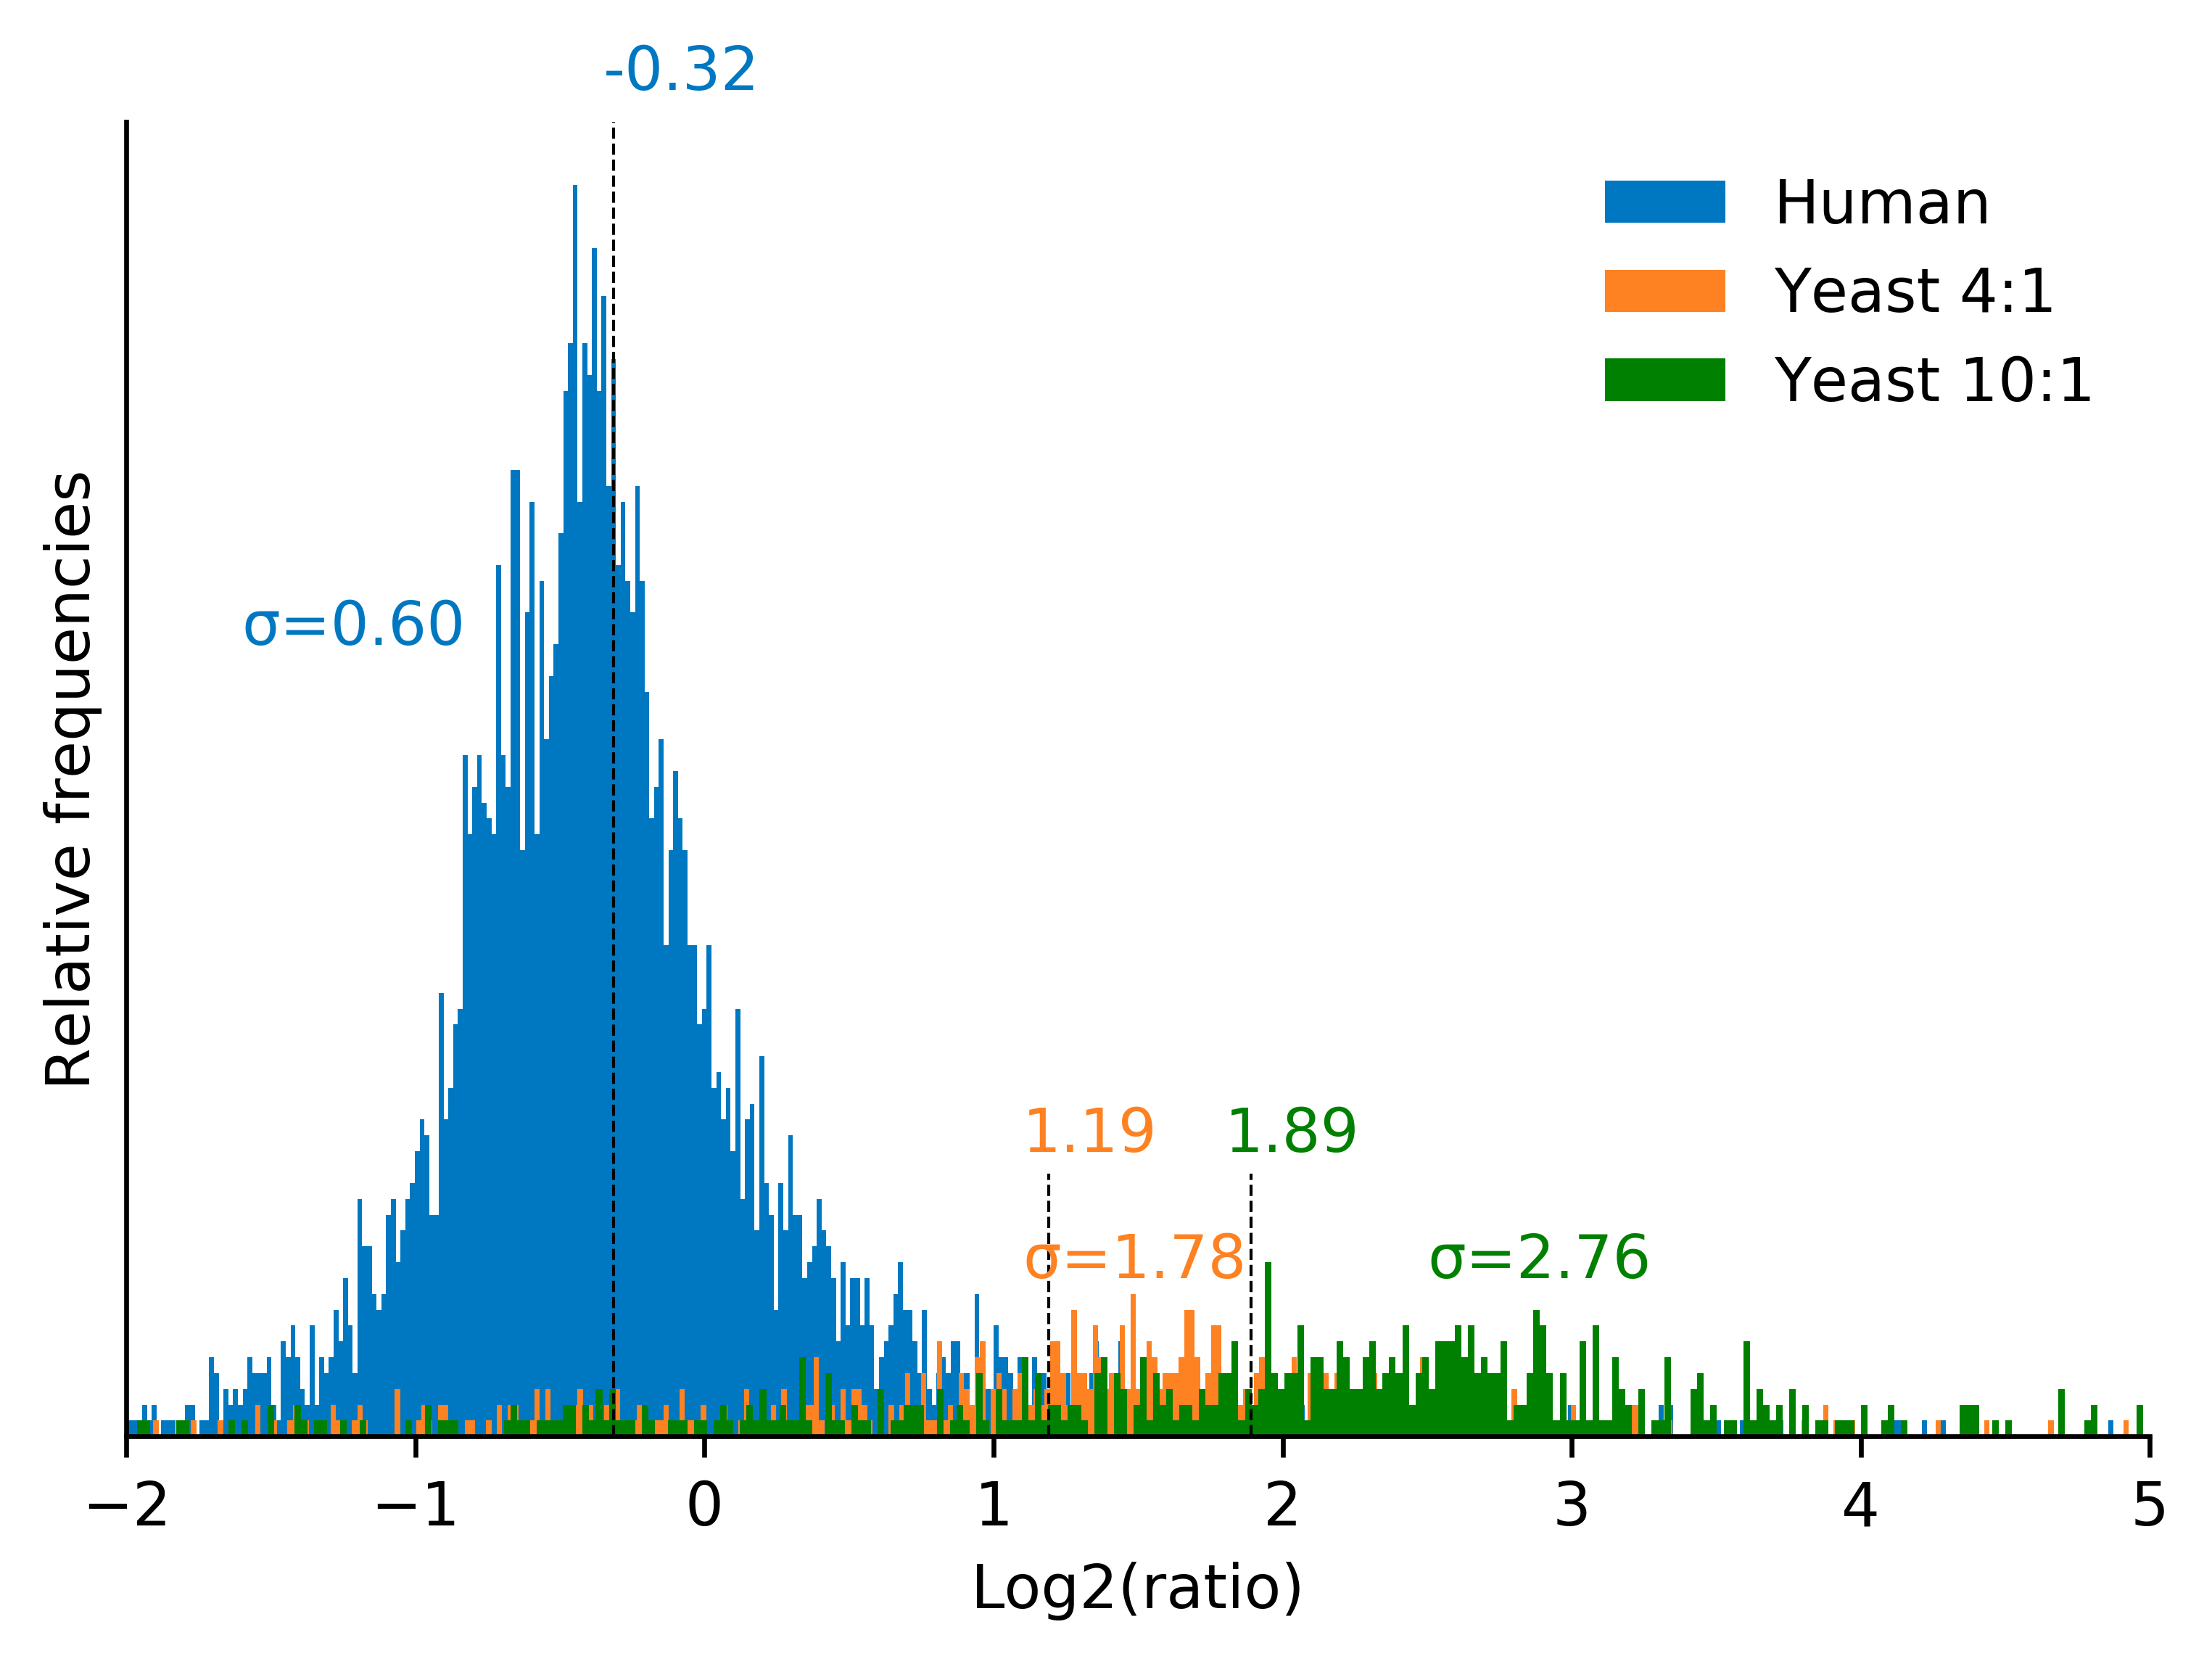

In [146]:
fig, ax = plt.subplots()

ax.hist(no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Human"]["Log2(ratio)"], bins=600, color="#0078C1")
u2 = np.mean(no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Human"]["Log2(ratio)"])
var2 = np.var(no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Human"]["Log2(ratio)"])
print(u2)
print(var2)

ax.hist(no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"], bins=600, color="#FE8122")
u1 = np.mean(no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"])
var1 = np.var(no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"])
print(u1)
print(var1)

ax.hist(no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"], bins=600, color="green")
u3 = np.mean(no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"])
var3 = np.var(no_normalization_proteus_pic[no_normalization_proteus_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"])
print(u3)
print(var3)

ax.legend(labels=['Human', 'Yeast 4:1', 'Yeast 10:1'], loc="best", frameon=False)

ax.axvline(x=1.1894200892681022, ymax=0.2, c="black", linewidth=0.5, ls="--")
ax.axvline(x=1.8895560724968363, ymax=0.2, c="black", linewidth=0.5, ls="--")
ax.axvline(x=-0.3160212406773734, c="black", linewidth=0.5, ls="--")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.text(-0.35,85,"-0.32", color="#0078C1")
plt.text(1.10,18,"1.19", color="#FE8122")
plt.text(1.8,18,"1.89", color="green")

plt.text(-1.6,50,"σ=0.60", color="#0078C1")
plt.text(1.1,10,"σ=1.78", color="#FE8122")
plt.text(2.5,10,"σ=2.76", color="green")

plt.yticks([])
plt.xlabel("Log2(ratio)")
plt.ylabel("Relative frequencies")
plt.xlim(-2,5)
plt.show()

### quantile

In [122]:
quantile_msstats = pd.read_csv("./quantile_protein_expression.csv", sep=',', index_col=None)
quantile_msstats_1 = quantile_msstats[quantile_msstats["GROUP"] == "SP=Yeast;CT=Mixture;QY=1"]

quantile_msstats_pic = pd.DataFrame(None, columns=["ProteinName", "Log2(ratio)", "Log2(intensity)", "Group"])
quantile_msstats_comparison = pd.read_csv("./quantile_comparison_res_filter.csv")
quantile_msstats_comparison = quantile_msstats_comparison.dropna(subset=["pvalue"], how="any")

for prot, group in quantile_msstats_comparison.groupby("Protein"):
    for label, label_group in group.groupby("Label"):
        pg = quantile_msstats_1[quantile_msstats_1["Protein"] == prot]
        pg["LogIntensities"] = pg.apply(lambda x: np.log10(np.exp2(x["LogIntensities"])), axis=1)
        t1 = np.mean(pg["LogIntensities"])

        if "YEAST" not in prot:
            Group = "Human"
        elif "HUMAN" not in prot:
            if label == "4vs1":
                Group = "Yeast 4:1"
            else:
                Group = "Yeast 10:1"
        else:
            continue
        log2ratio = label_group["log2FC"].values[0]
        quantile_msstats_pic = quantile_msstats_pic.append({"ProteinName":prot, "Log2(ratio)": log2ratio, "Log2(intensity)": t1,
                                                           "Group": Group}, ignore_index=True)

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


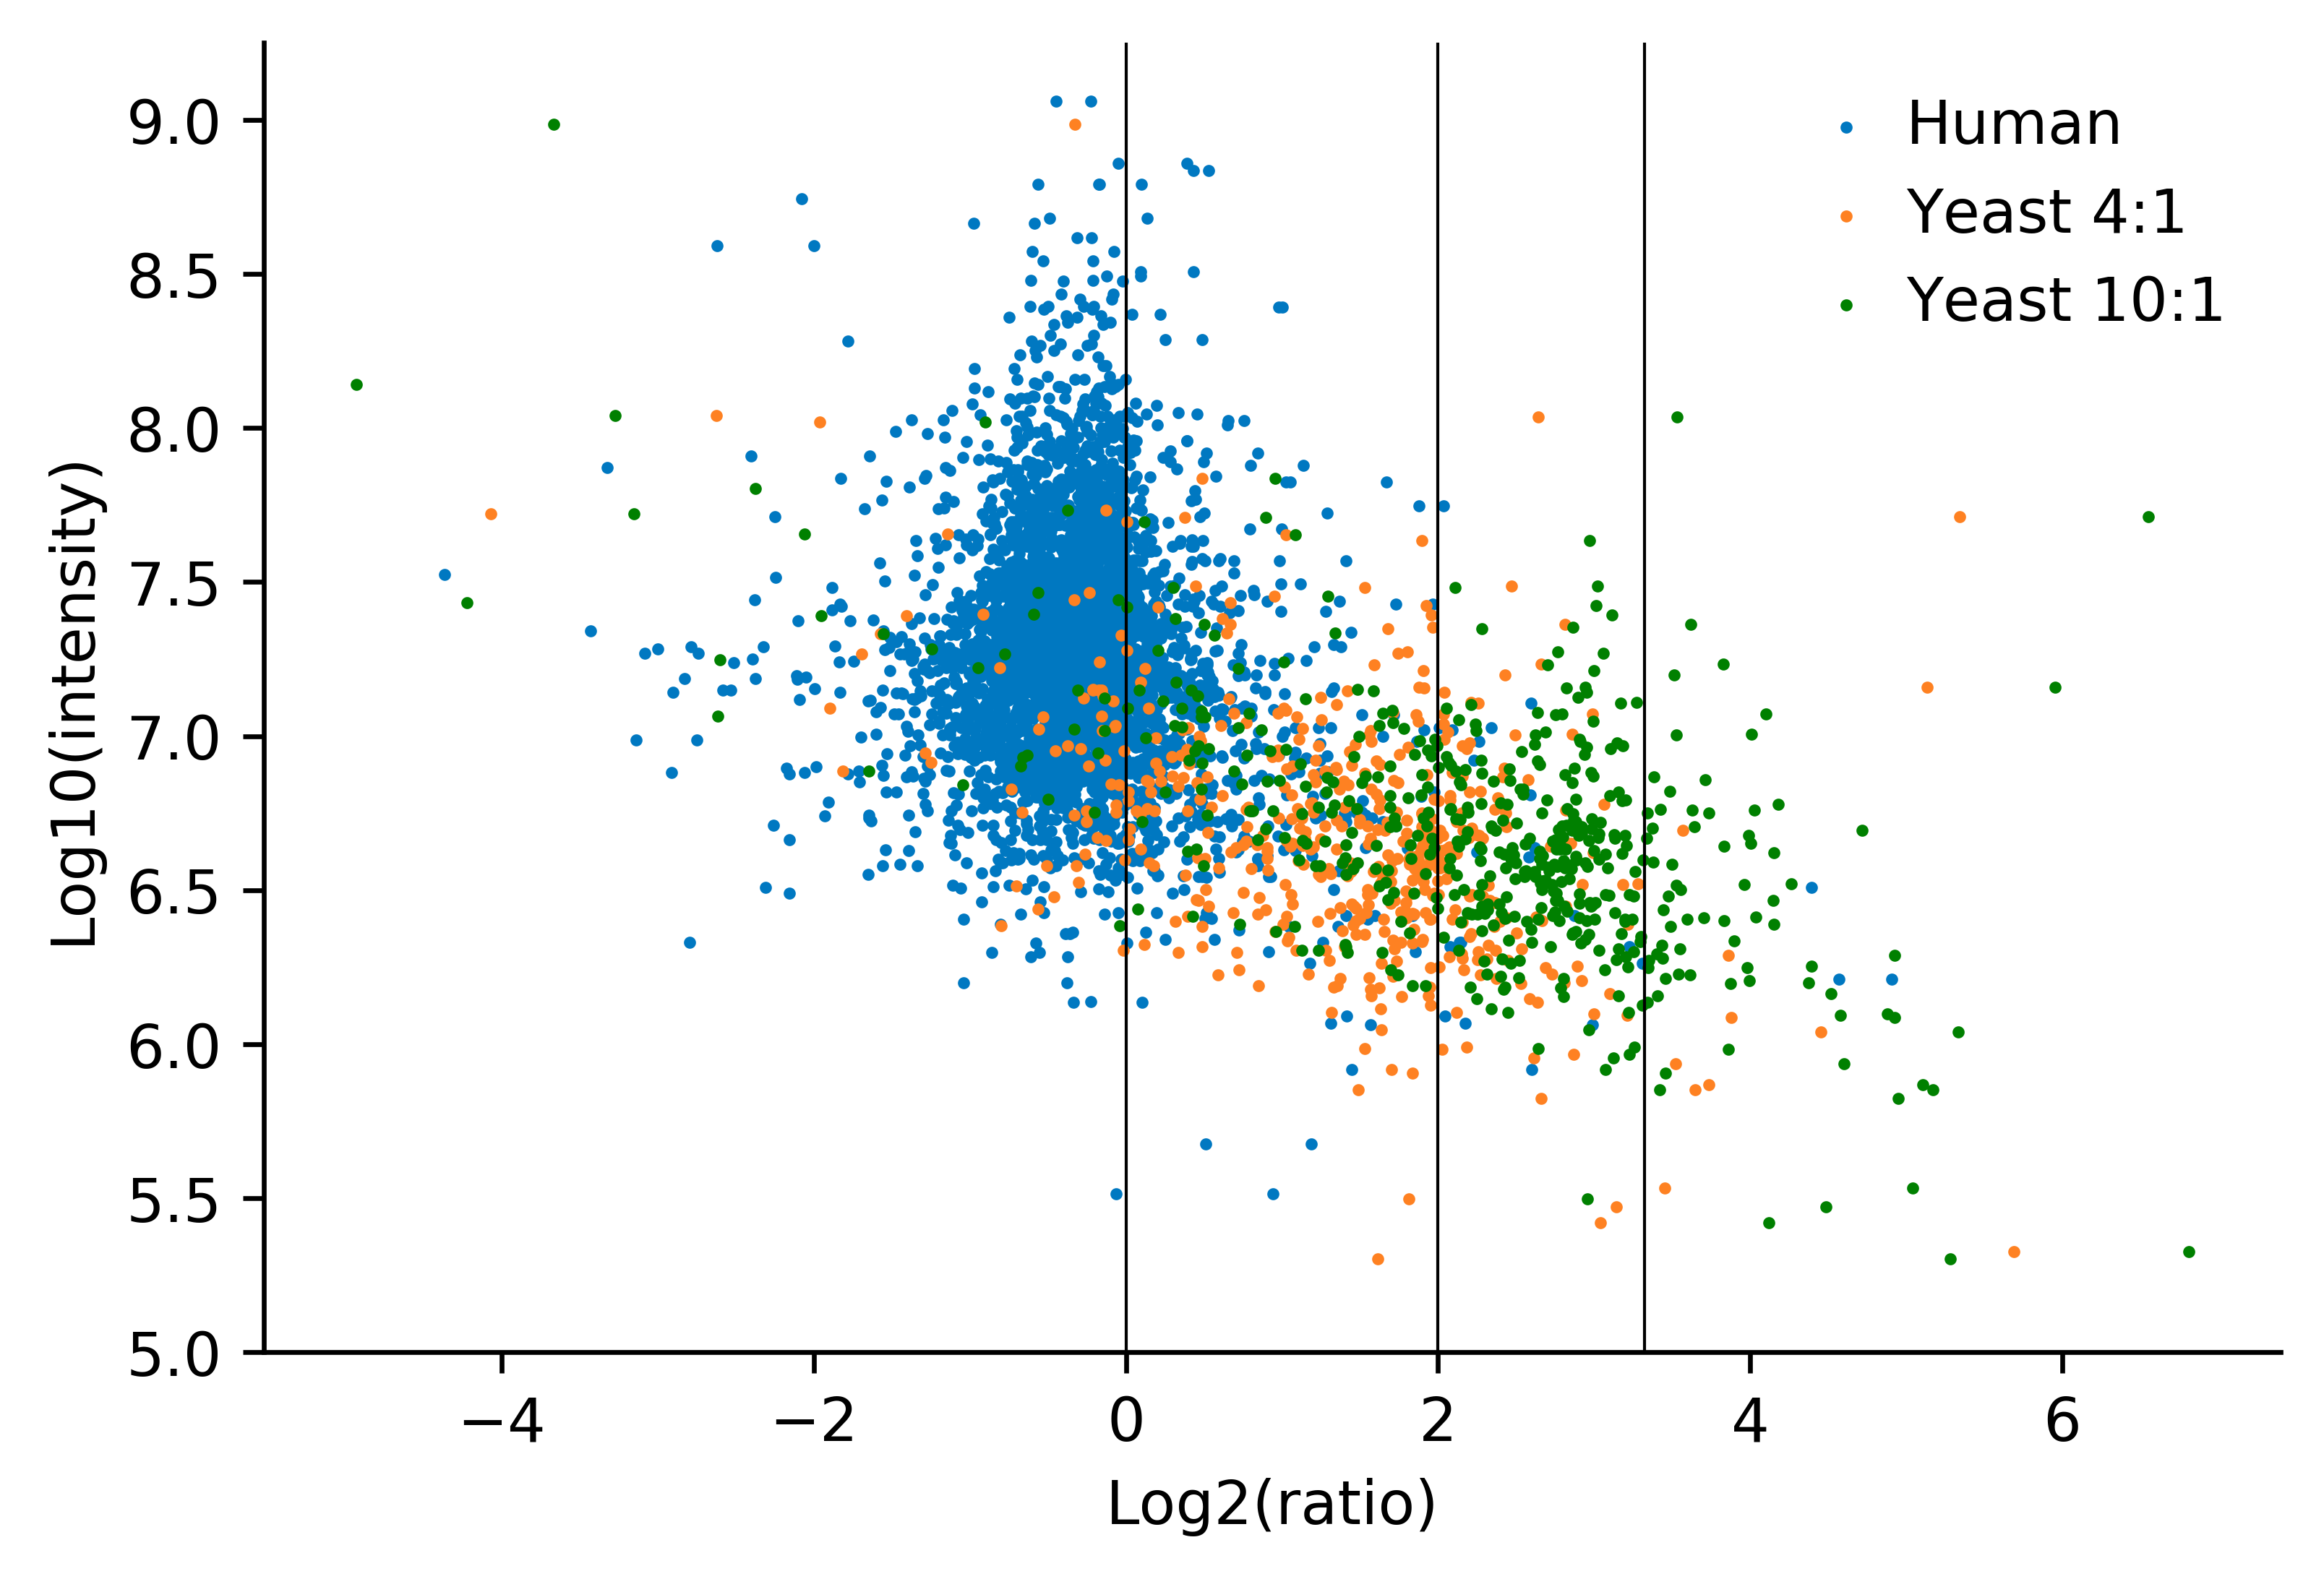

In [141]:
fig, ax = plt.subplots()

line1 = ax.scatter(quantile_msstats_pic[quantile_msstats_pic['Group'] == "Human"]["Log2(ratio)"], y=quantile_msstats_pic[quantile_msstats_pic['Group'] == "Human"]['Log2(intensity)'], c="#0078C1", s=1)

line2 = ax.scatter(quantile_msstats_pic[quantile_msstats_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"], y=quantile_msstats_pic[quantile_msstats_pic['Group'] == "Yeast 4:1"]['Log2(intensity)'], c="#FE8122", s=1)

line3 = ax.scatter(quantile_msstats_pic[quantile_msstats_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"], y=quantile_msstats_pic[quantile_msstats_pic['Group'] == "Yeast 10:1"]['Log2(intensity)'], c="green", s=1)

ax.axvline(x=0, c="black", linewidth=0.5, )
ax.axvline(x=2, c="black", linewidth=0.5, )
ax.axvline(x=np.log2(10), c="black", linewidth=0.5, )

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend(handles=[line1, line2, line3], labels=['Human', 'Yeast 4:1', "Yeast 10:1"], loc="best", frameon=False, handletextpad=0)

# plt.title("quantms+MSstats")
# plt.xlim(-2,4)
plt.ylim(5)
plt.xlabel("Log2(ratio)")
plt.ylabel("Log10(intensity)")
plt.show()

-0.30606246987297714
0.36217522324857254
1.3615592181462084
1.1796479987260033
2.2114573562061097
2.0419537818771927


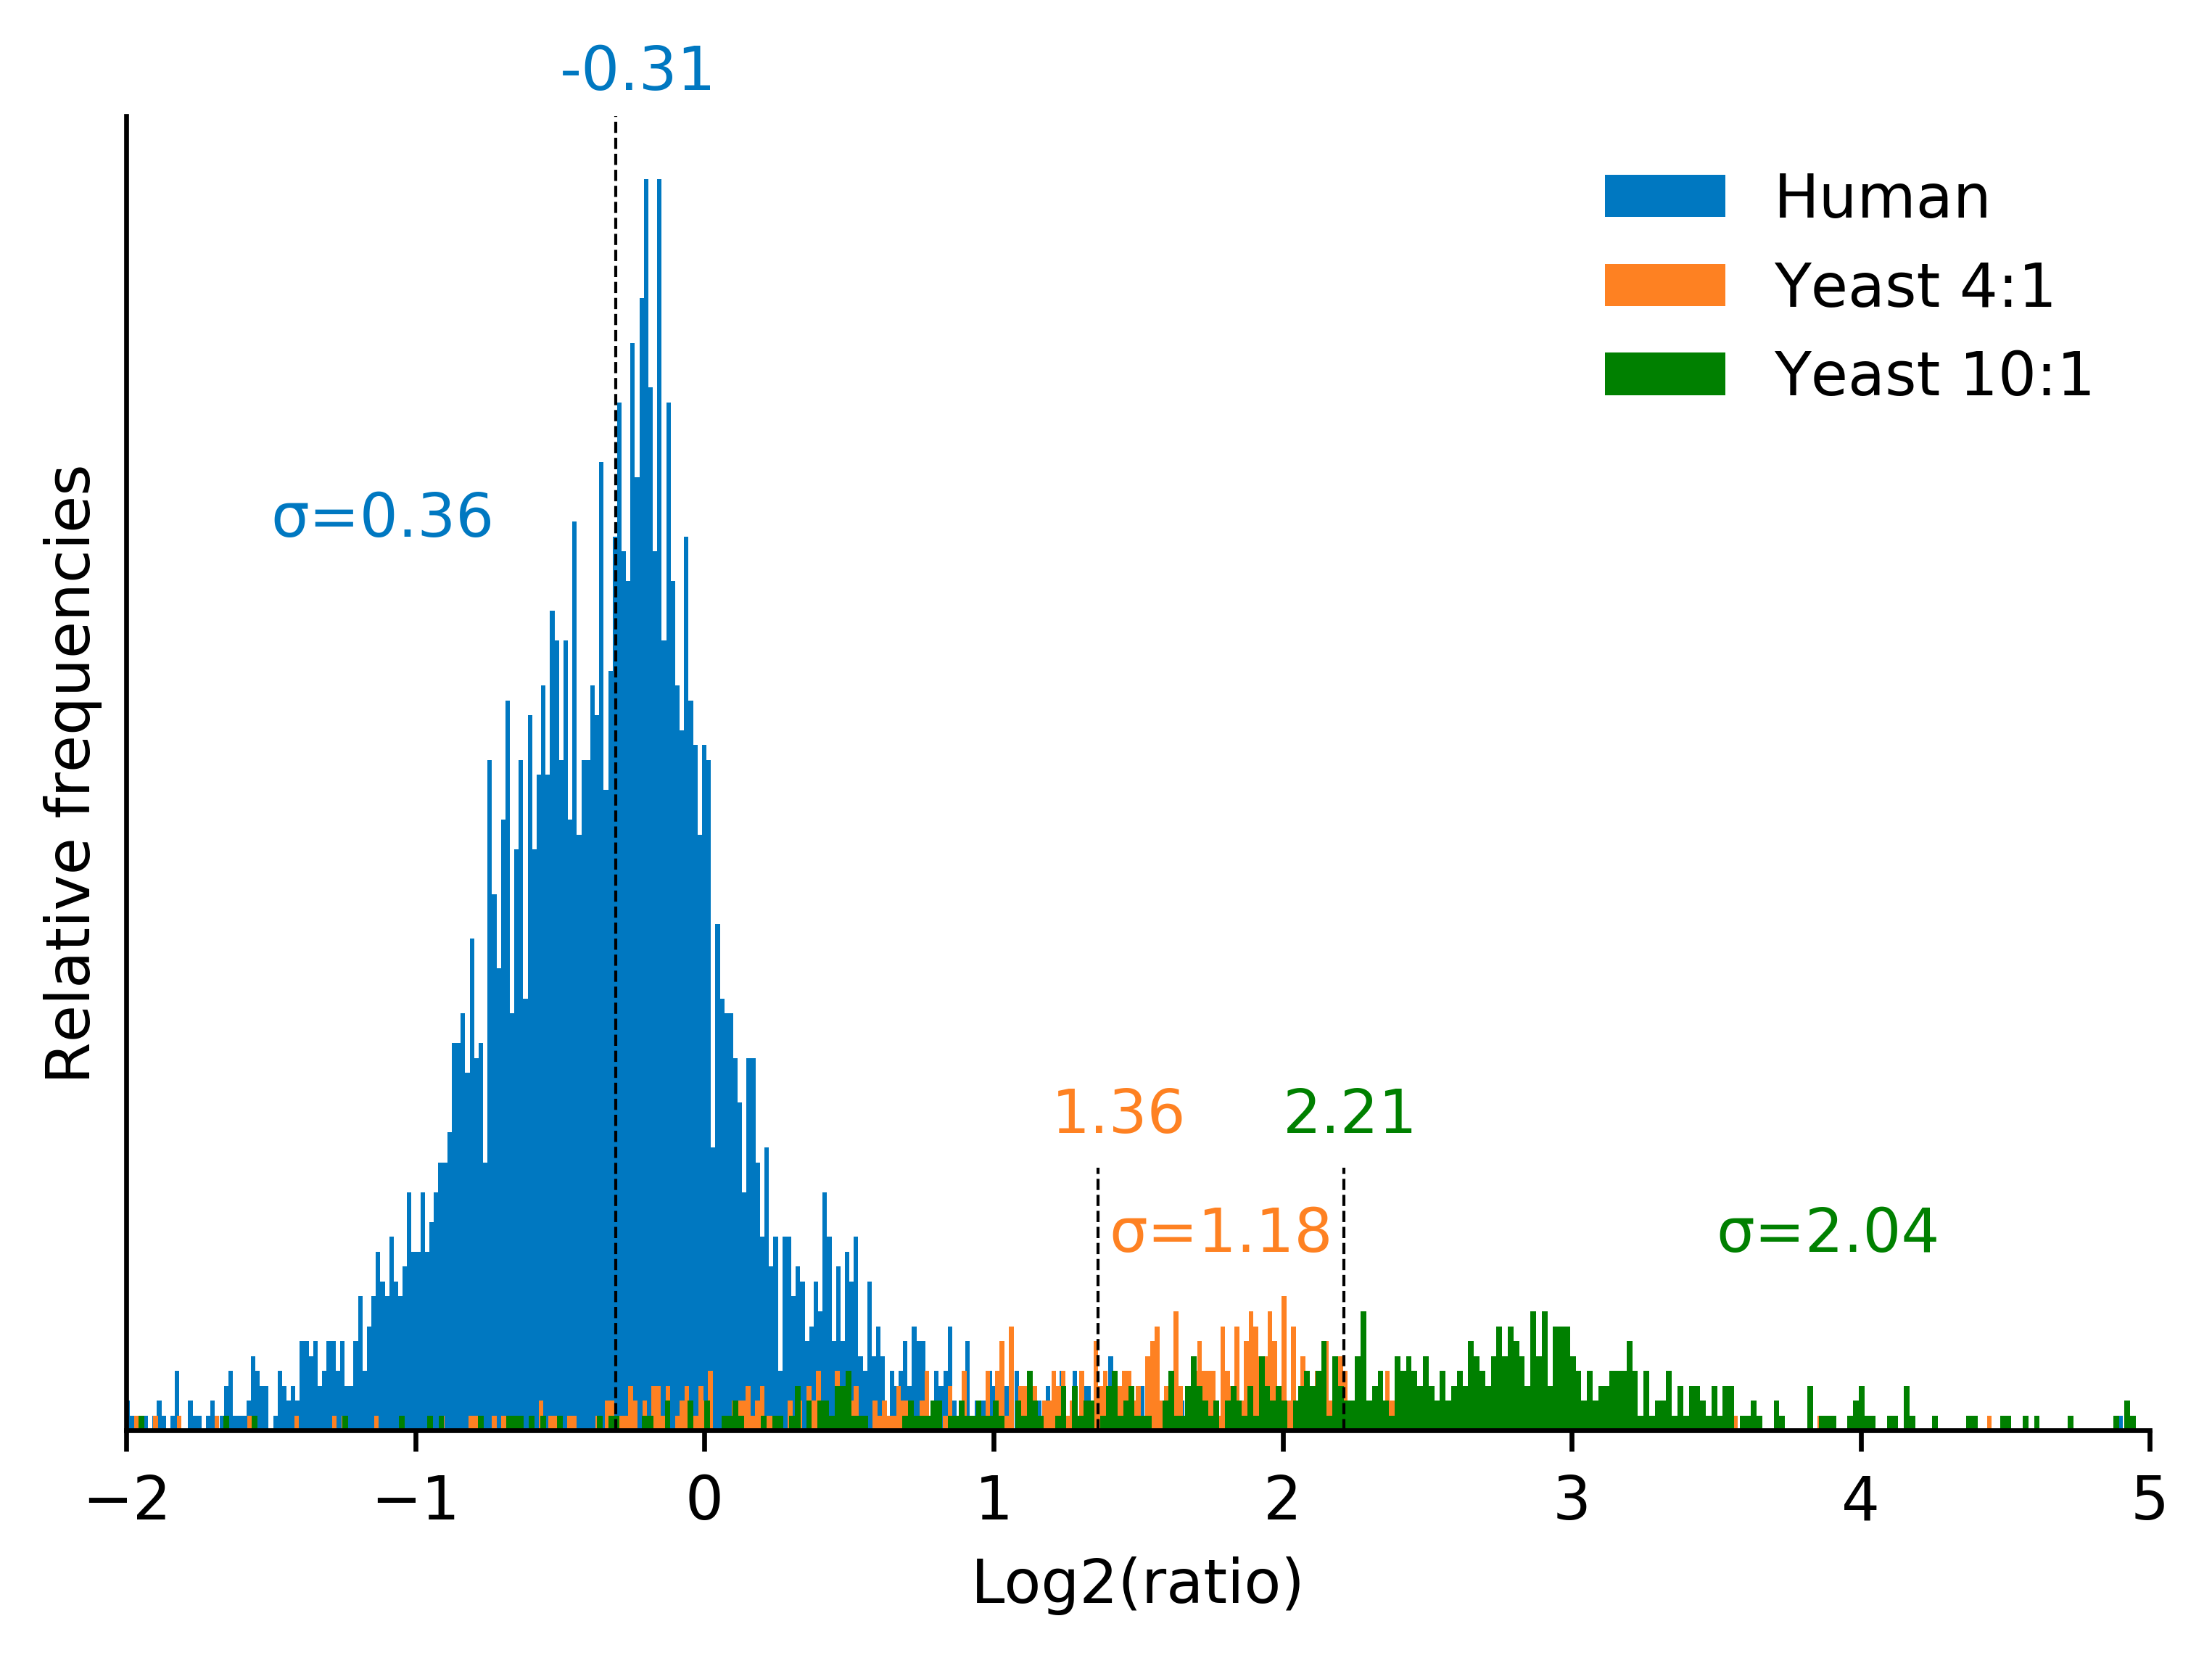

In [130]:
fig, ax = plt.subplots()

ax.hist(quantile_msstats_pic[quantile_msstats_pic['Group'] == "Human"]["Log2(ratio)"], bins=600, color="#0078C1")
u2 = np.mean(quantile_msstats_pic[quantile_msstats_pic['Group'] == "Human"]["Log2(ratio)"])
var2 = np.var(quantile_msstats_pic[quantile_msstats_pic['Group'] == "Human"]["Log2(ratio)"])
print(u2)
print(var2)

ax.hist(quantile_msstats_pic[quantile_msstats_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"], bins=600, color="#FE8122")
u1 = np.mean(quantile_msstats_pic[quantile_msstats_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"])
var1 = np.var(quantile_msstats_pic[quantile_msstats_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"])
print(u1)
print(var1)

ax.hist(quantile_msstats_pic[quantile_msstats_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"], bins=600, color="green")
u1 = np.mean(quantile_msstats_pic[quantile_msstats_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"])
var1 = np.var(quantile_msstats_pic[quantile_msstats_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"])
print(u1)
print(var1)

ax.legend(labels=['Human', 'Yeast 4:1', 'Yeast 10:1'], loc="best", frameon=False)

ax.axvline(x=2.2114573562061097, ymax=0.2, c="black", linewidth=0.5, ls="--")
ax.axvline(x=1.3615592181462084, ymax=0.2, c="black", linewidth=0.5, ls="--")
ax.axvline(x=-0.30606246987297714, c="black", linewidth=0.5, ls="--")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.text(-0.5,90,"-0.31", color="#0078C1")
plt.text(1.2,20,"1.36", color="#FE8122")
plt.text(2,20,"2.21", color="green")

plt.text(-1.5,60,"σ=0.36", color="#0078C1")
plt.text(1.4,12,"σ=1.18", color="#FE8122")
plt.text(3.5,12,"σ=2.04", color="green")

plt.yticks([])
plt.xlabel("Log2(ratio)")
plt.ylabel("Relative frequencies")
plt.xlim(-2,5)
plt.show()

In [131]:
prodatquantile_long_1 = prodatquantile_long[prodatquantile_long["Condition"] == "1"]

quantile_proteus_pic = pd.DataFrame(None, columns=["ProteinName", "Log2(ratio)", "Log2(intensity)", "Group"])

quantile_proteus_comparison_4 = pd.read_csv("./prodat_quantile_comp_res_filter_4fc.csv")
quantile_proteus_comparison_4 = quantile_proteus_comparison_4[["protein", "logFC", "P.Value", "adj.P.Val"]]
quantile_proteus_comparison_4["Label"] = "4vs1"

quantile_proteus_comparison_10 = pd.read_csv("./prodat_quantile_comp_res_filter_10fc.csv")
quantile_proteus_comparison_10 = quantile_proteus_comparison_10[["protein", "logFC", "P.Value", "adj.P.Val"]]
quantile_proteus_comparison_10["Label"] = "10vs1"

quantile_proteus_comparison = quantile_proteus_comparison_4.append(quantile_proteus_comparison_10, ignore_index=True)

quantile_proteus_comparison = quantile_proteus_comparison.dropna(subset=["P.Value"], how="any")

for prot, group in quantile_proteus_comparison.groupby("protein"):
    for label, label_group in group.groupby("Label"):
        pg = prodatquantile_long_1[prodatquantile_long_1["ProteinName"] == prot]
        pg["LogIntensities"] = pg.apply(lambda x: np.log10(np.exp2(x["LogIntensities"])), axis=1)
        t1 = np.mean(pg["LogIntensities"])

        if "YEAST" not in prot:
            Group = "Human"
        elif "HUMAN" not in prot:
            if label == "4vs1":
                Group = "Yeast 4:1"
            else:
                Group = "Yeast 10:1"
        else:
            continue
        log2ratio = label_group["logFC"].values[0]
        quantile_proteus_pic = quantile_proteus_pic.append({"ProteinName":prot, "Log2(ratio)": log2ratio, "Log2(intensity)": t1,
                                                           "Group": Group}, ignore_index=True)

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


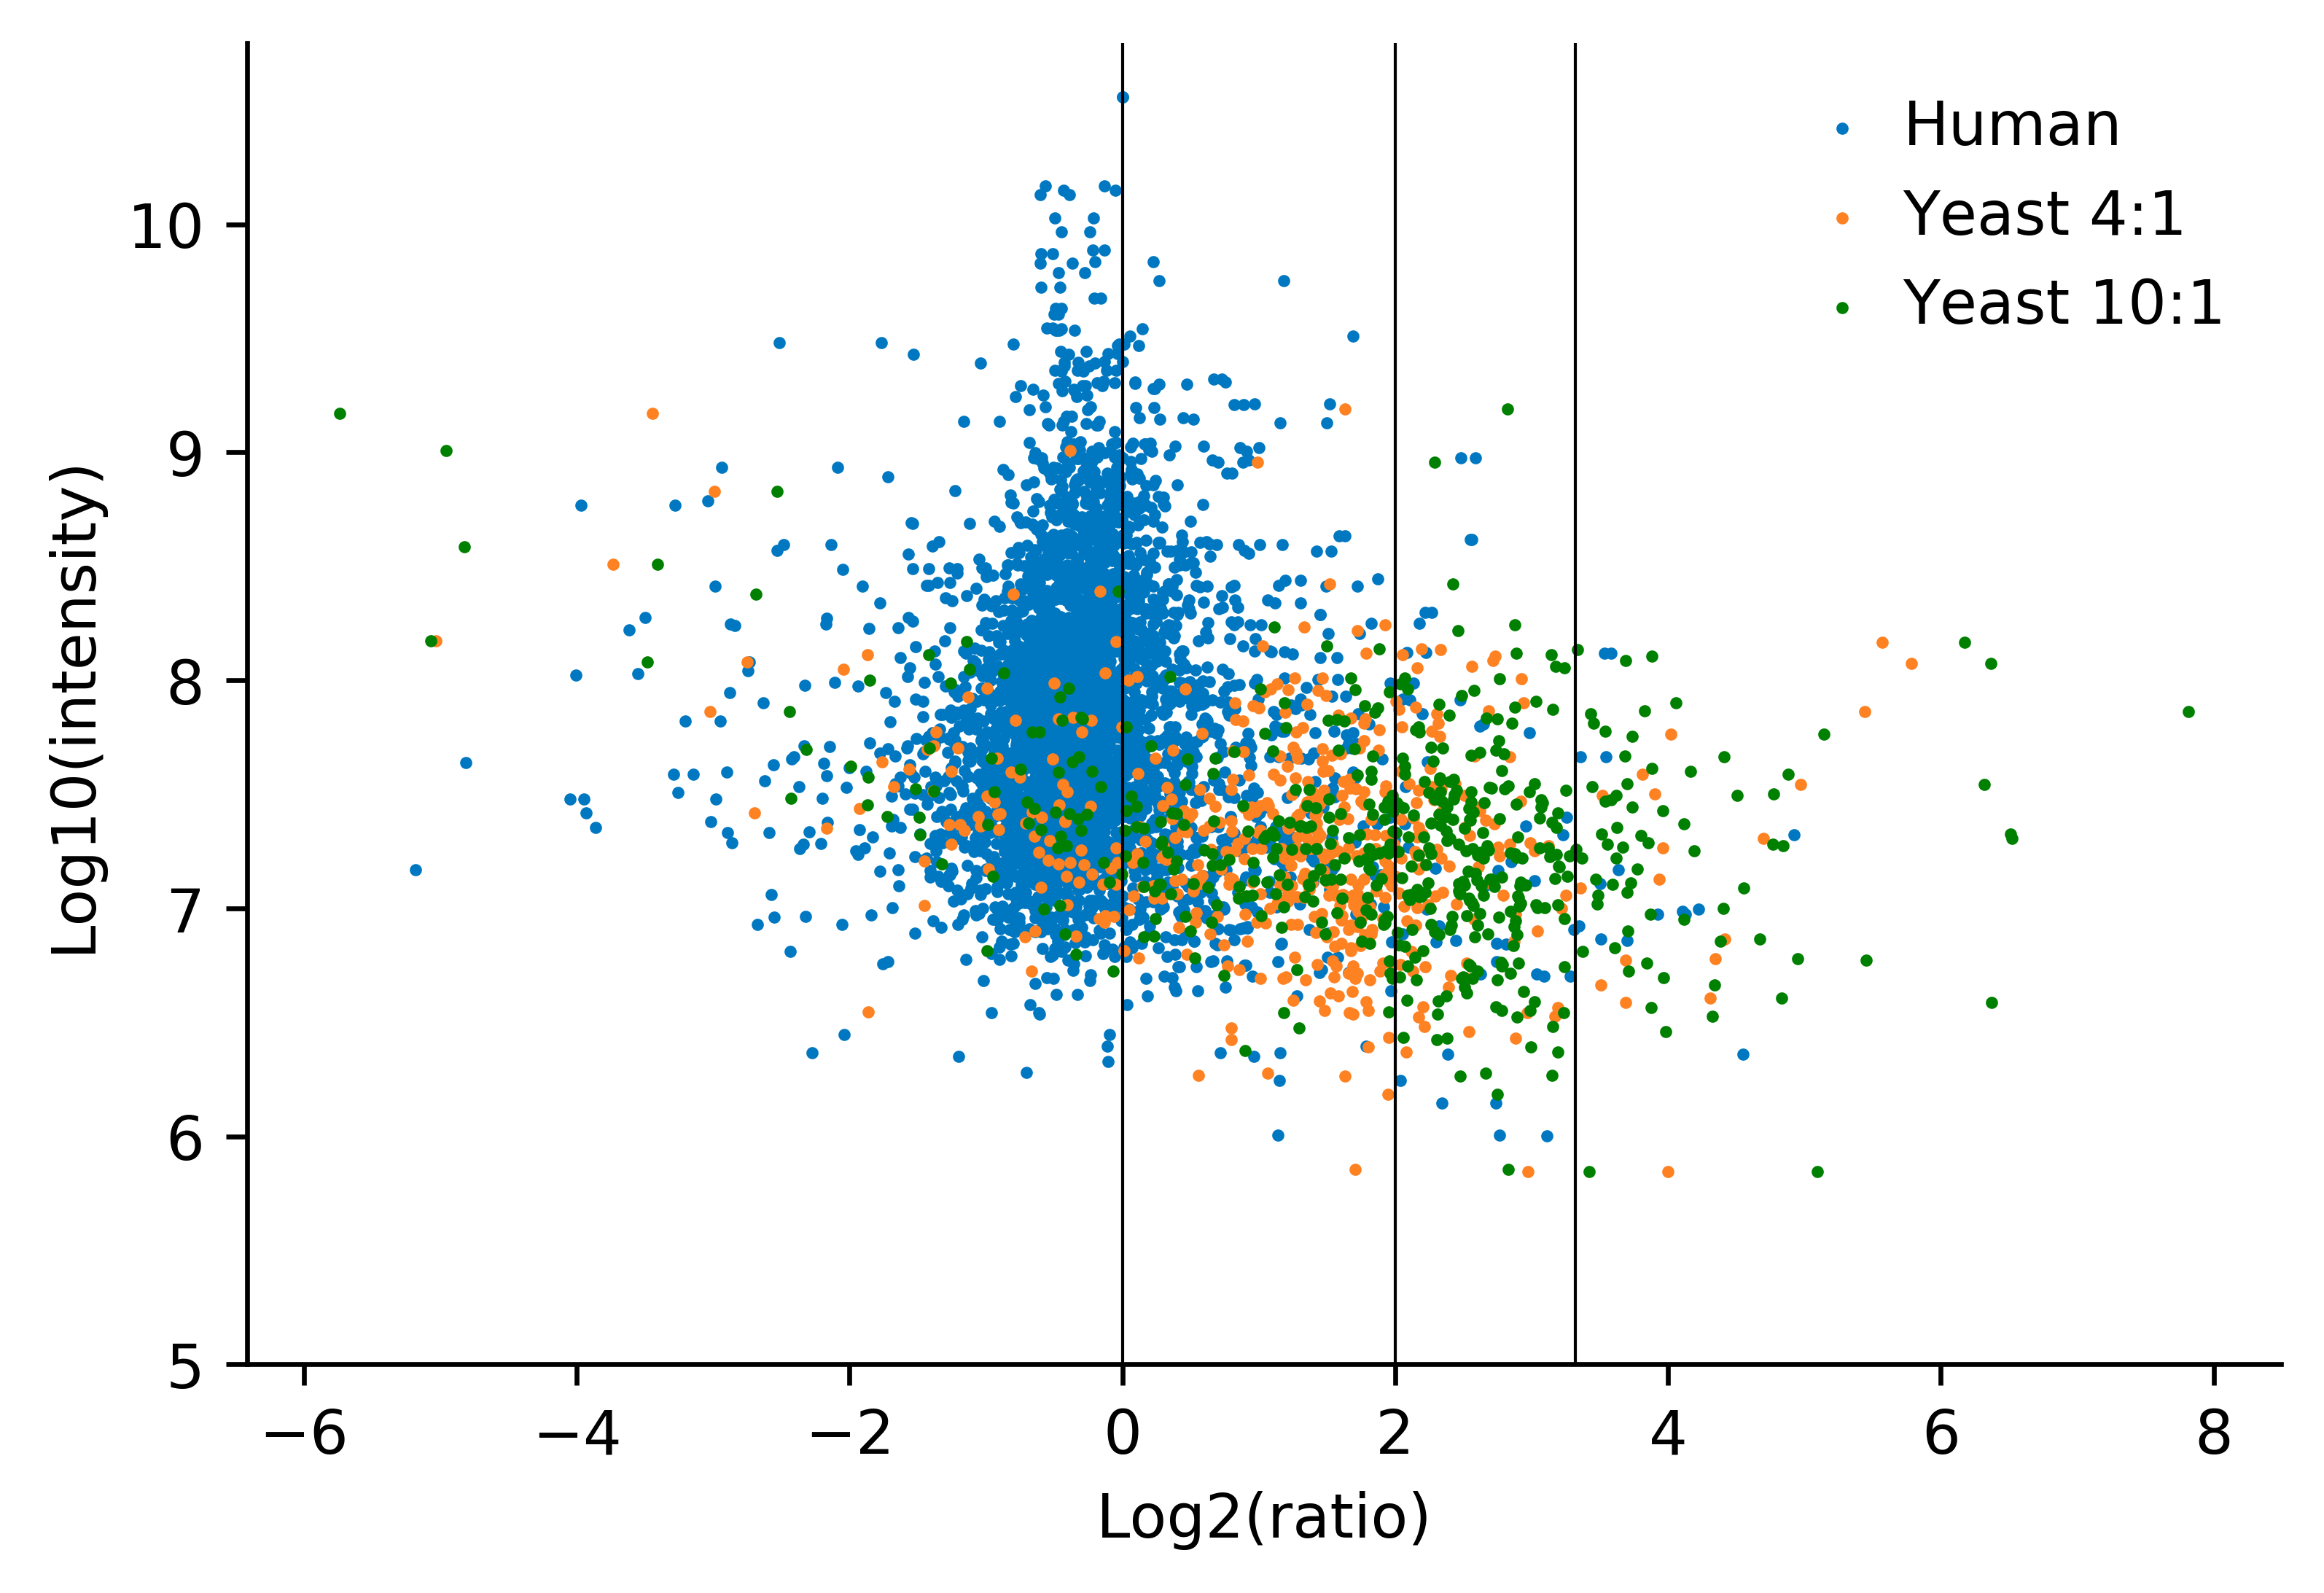

In [142]:
fig, ax = plt.subplots()

line1 = ax.scatter(quantile_proteus_pic[quantile_proteus_pic['Group'] == "Human"]["Log2(ratio)"], y=quantile_proteus_pic[quantile_proteus_pic['Group'] == "Human"]['Log2(intensity)'], c="#0078C1", s=1)

line2 = ax.scatter(quantile_proteus_pic[quantile_proteus_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"], y=quantile_proteus_pic[quantile_proteus_pic['Group'] == "Yeast 4:1"]['Log2(intensity)'], c="#FE8122", s=1)

line3 = ax.scatter(quantile_proteus_pic[quantile_proteus_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"], y=quantile_proteus_pic[quantile_proteus_pic['Group'] == "Yeast 10:1"]['Log2(intensity)'], c="green", s=1)

ax.axvline(x=0, c="black", linewidth=0.5, )
ax.axvline(x=2, c="black", linewidth=0.5, )
ax.axvline(x=np.log2(10), c="black", linewidth=0.5, )

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend(handles=[line1, line2, line3], labels=['Human', 'Yeast 4:1', "Yeast 10:1"], loc="best", frameon=False, handletextpad=0)

# plt.title("quantms+Proteus")
# plt.xlim(-2,4)
plt.ylim(5)
plt.xlabel("Log2(ratio)")
plt.ylabel("Log10(intensity)")
plt.show()

-0.25943911812694
0.6059508824528951
1.2115053535221736
1.7510383614436964
1.9011254026039253
2.79722651677232


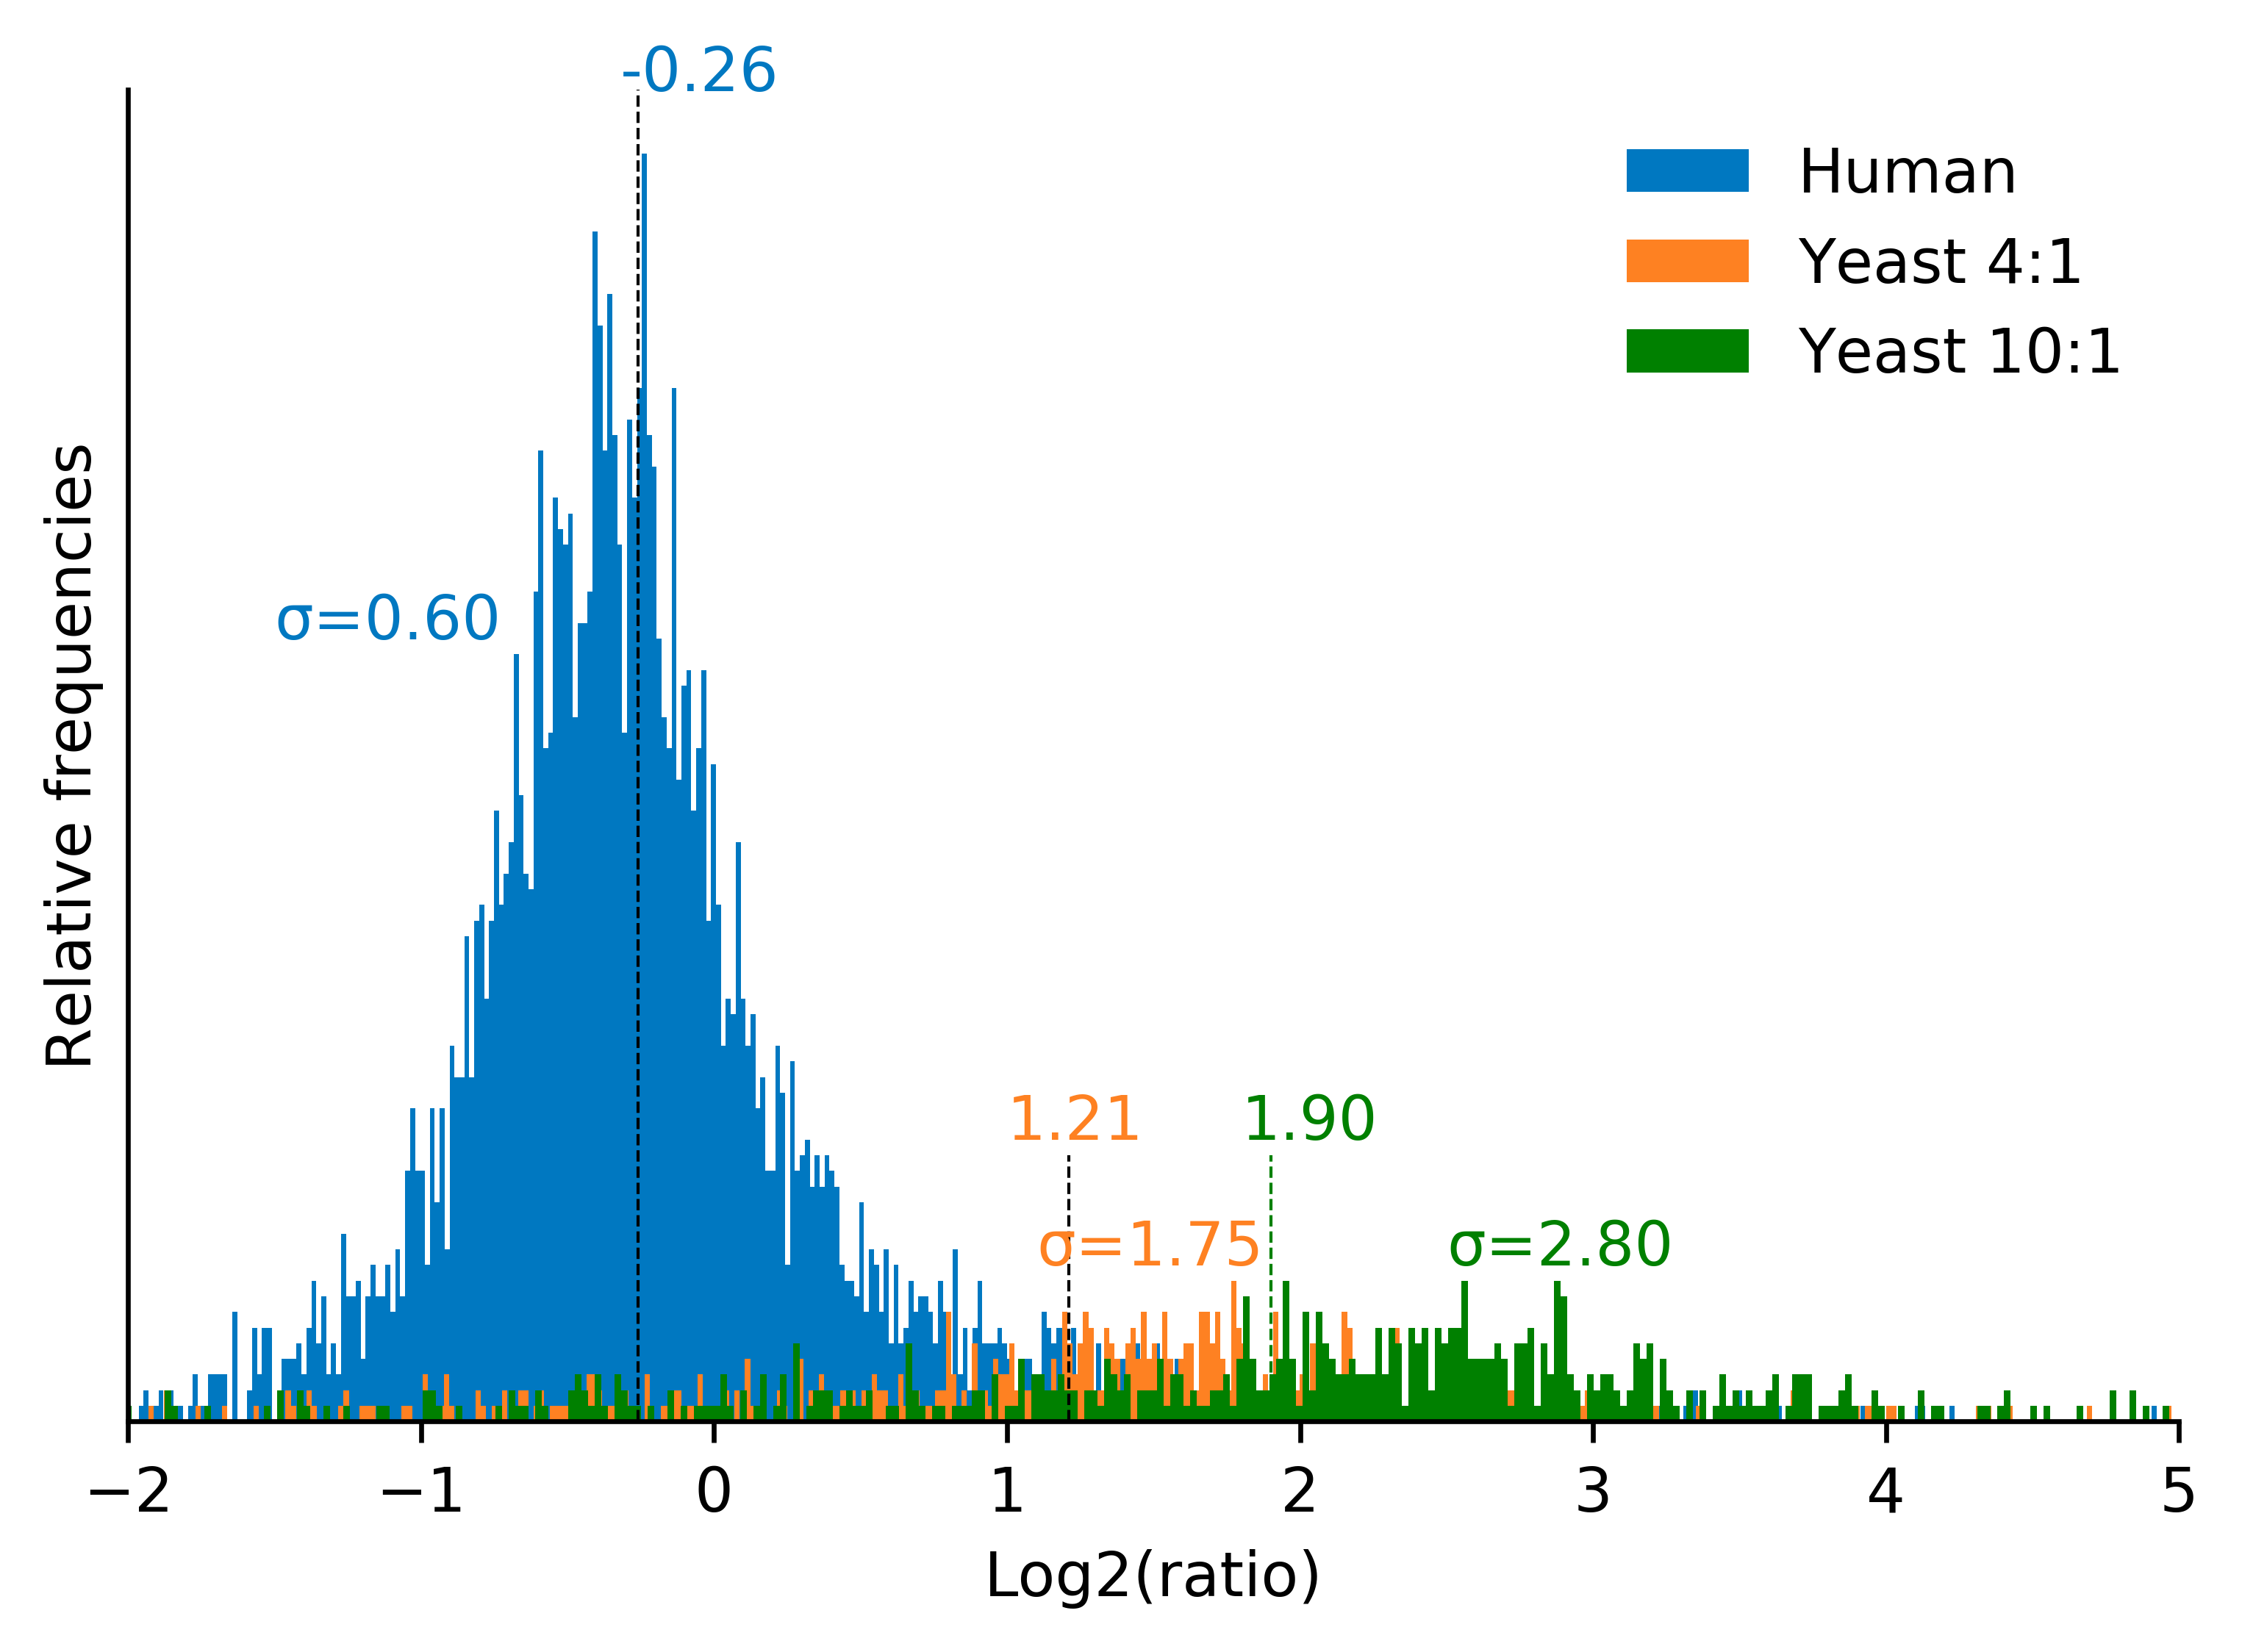

In [139]:
fig, ax = plt.subplots()

ax.hist(quantile_proteus_pic[quantile_proteus_pic['Group'] == "Human"]["Log2(ratio)"], bins=600, color="#0078C1")
u2 = np.mean(quantile_proteus_pic[quantile_proteus_pic['Group'] == "Human"]["Log2(ratio)"])
var2 = np.var(quantile_proteus_pic[quantile_proteus_pic['Group'] == "Human"]["Log2(ratio)"])
print(u2)
print(var2)

ax.hist(quantile_proteus_pic[quantile_proteus_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"], bins=600, color="#FE8122")
u1 = np.mean(quantile_proteus_pic[quantile_proteus_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"])
var1 = np.var(quantile_proteus_pic[quantile_proteus_pic['Group'] == "Yeast 4:1"]["Log2(ratio)"])
print(u1)
print(var1)

ax.hist(quantile_proteus_pic[quantile_proteus_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"], bins=600, color="green")
u3 = np.mean(quantile_proteus_pic[quantile_proteus_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"])
var3 = np.var(quantile_proteus_pic[quantile_proteus_pic['Group'] == "Yeast 10:1"]["Log2(ratio)"])
print(u3)
print(var3)

ax.legend(labels=['Human', 'Yeast 4:1', 'Yeast 10:1'], loc="best", frameon=False)

ax.axvline(x=1.2115053535221736, ymax=0.2, c="black", linewidth=0.5, ls="--")
ax.axvline(x=1.9011254026039253, ymax=0.2, c="green", linewidth=0.5, ls="--")
ax.axvline(x=-0.25943911812694, c="black", linewidth=0.5, ls="--")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.text(-0.32,85,"-0.26", color="#0078C1")
plt.text(1,18,"1.21", color="#FE8122")
plt.text(1.8,18,"1.90", color="green")

plt.text(-1.5,50,"σ=0.60", color="#0078C1")
plt.text(1.1,10,"σ=1.75", color="#FE8122")
plt.text(2.5,10,"σ=2.80", color="green")

plt.yticks([])
plt.xlabel("Log2(ratio)")
plt.ylabel("Relative frequencies")
plt.xlim(-2,5)
plt.show()

### AUC

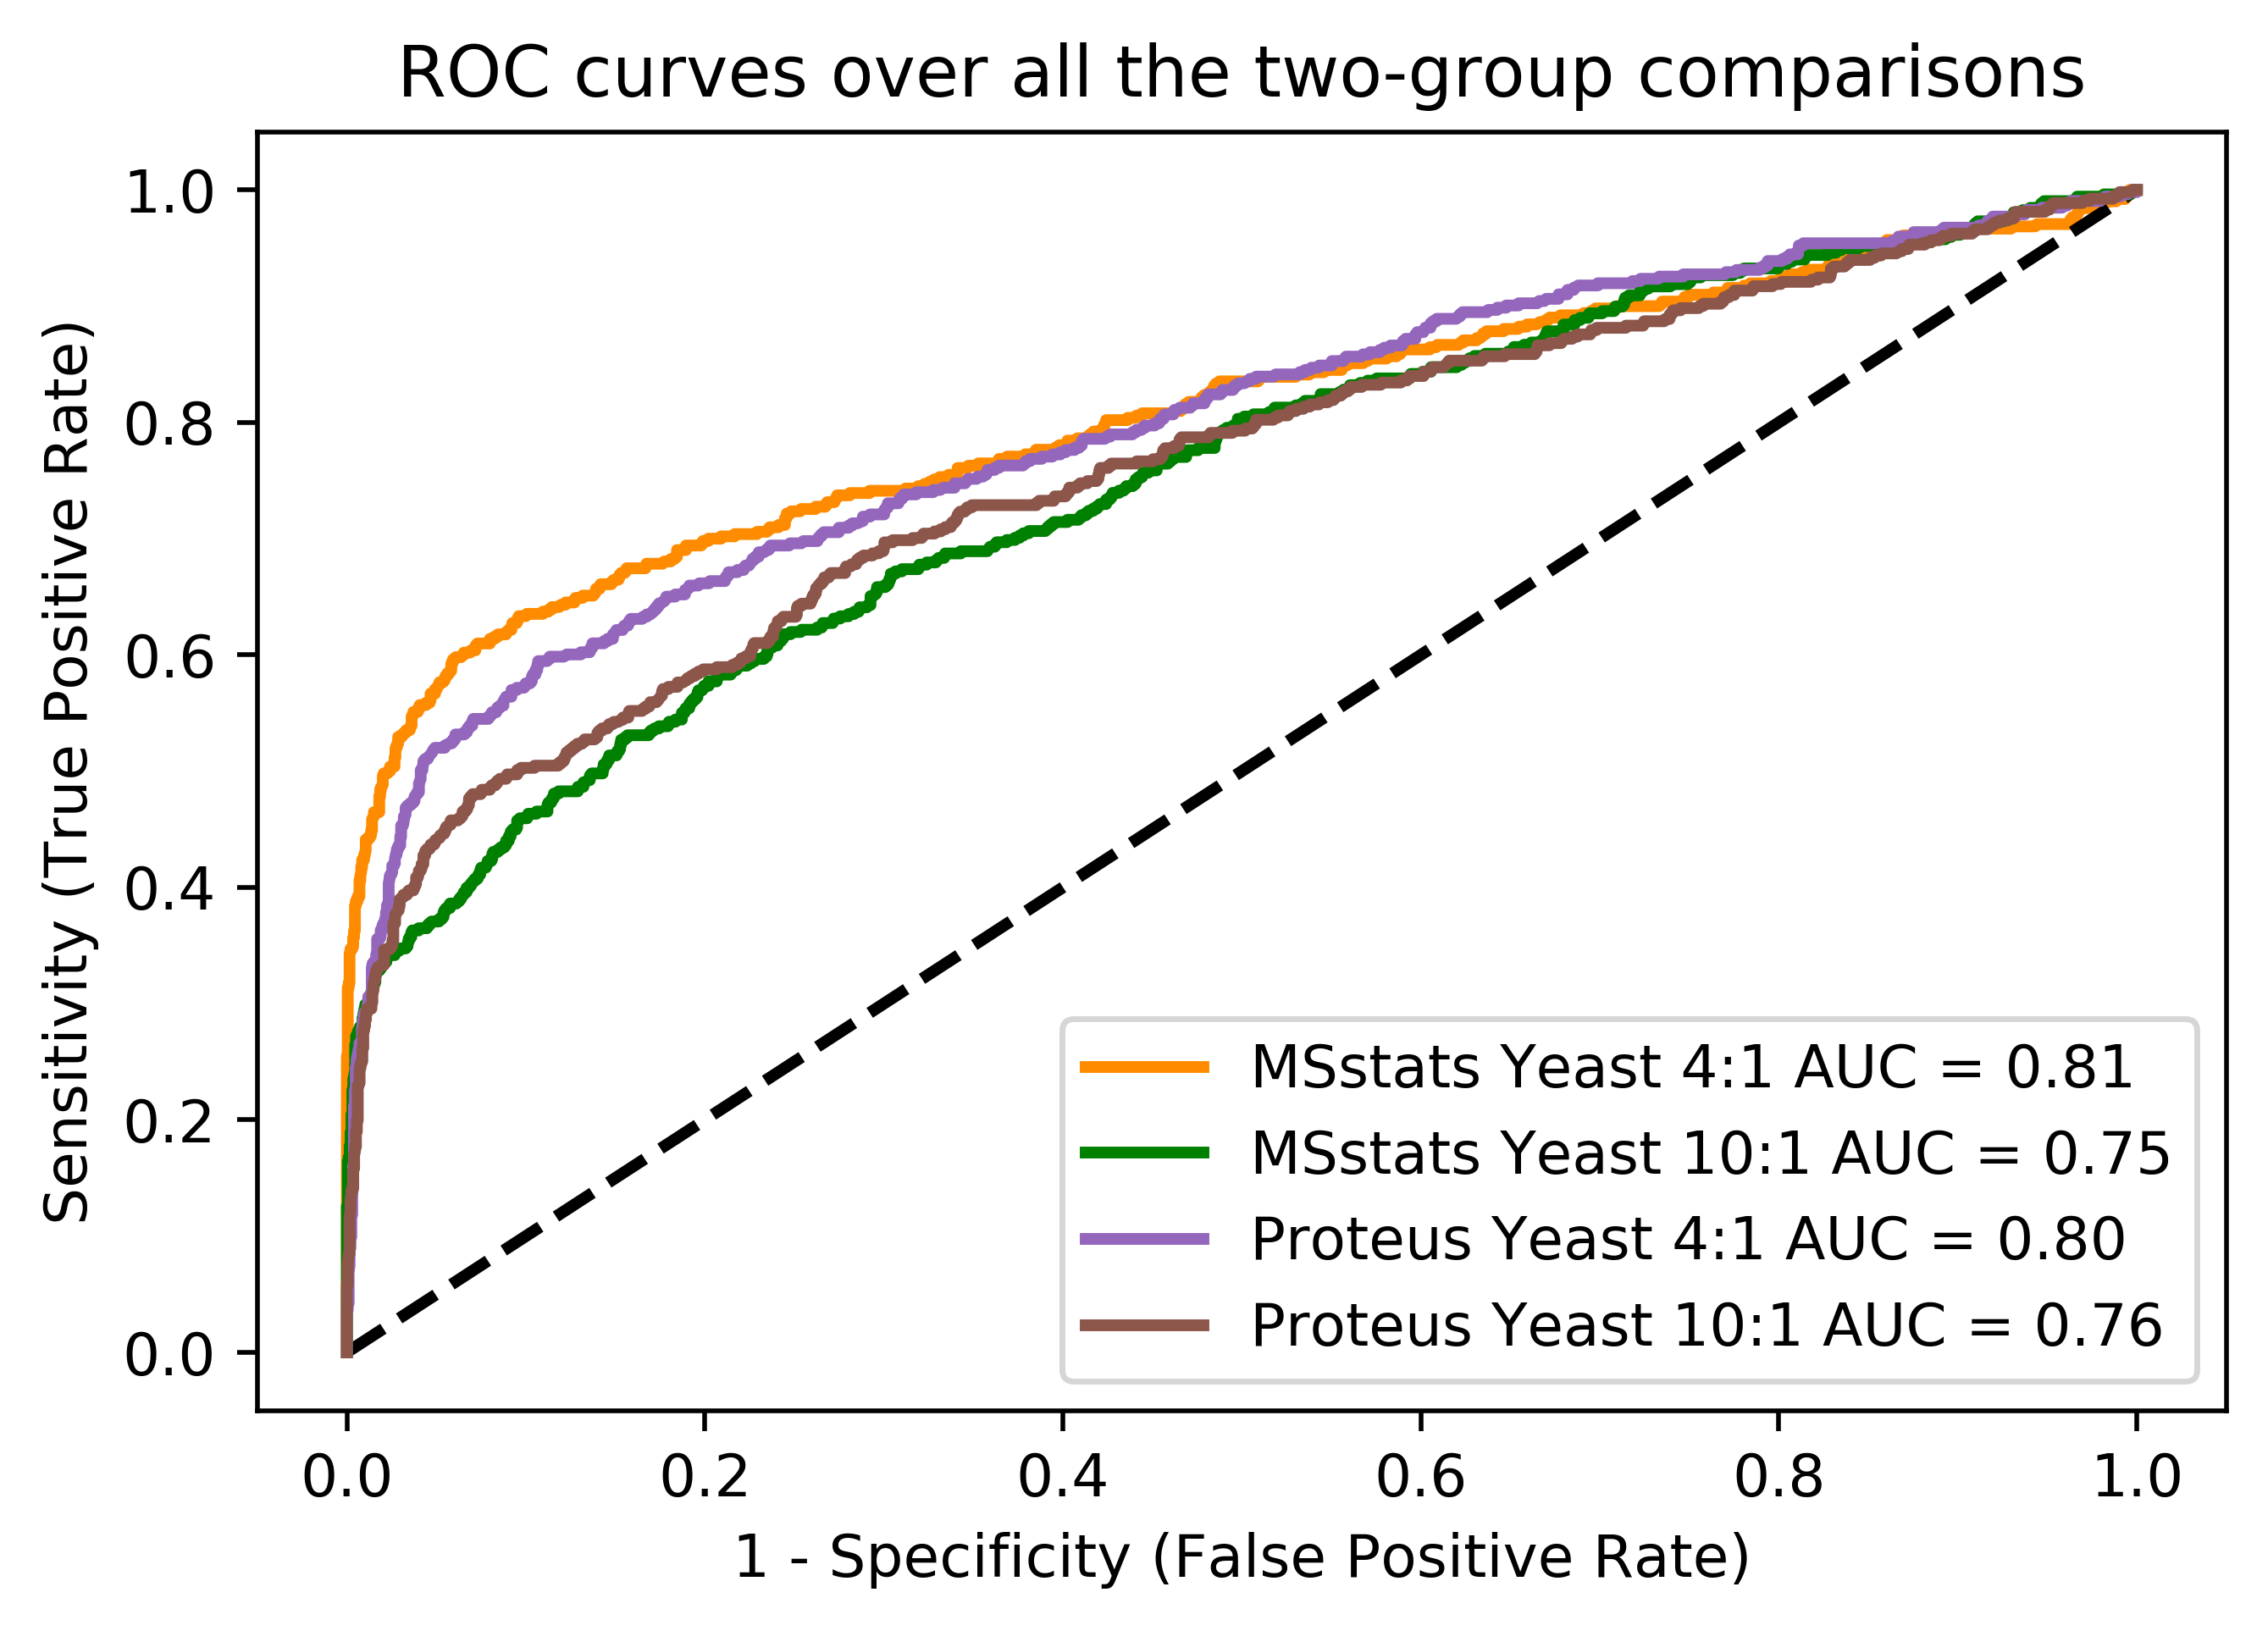

In [166]:
from sklearn import metrics

em_msstats_comparison['value'] = 1 - em_msstats_comparison['adj.pvalue']
em_msstats_comparison['y'] = em_msstats_comparison['Protein'].map(lambda x: ("YEAST" in x and 1) or ("YEAST" not in x and 0))
em_msstats_comparison_4 = em_msstats_comparison[em_msstats_comparison["Label"] == "4vs1"]
em_msstats_comparison_10 = em_msstats_comparison[em_msstats_comparison["Label"] == "10vs1"]

em_msstats_comparison_4 = em_msstats_comparison_4.sort_values(by="value", ascending=False)
em_msstats_comparison_4.head()

fpr, tpr, thresholds = metrics.roc_curve(em_msstats_comparison_4['y'].tolist(), em_msstats_comparison_4['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.figure(dpi=500)
plt.plot(fpr, tpr, color="darkorange", lw=2, label="MSstats Yeast 4:1 AUC = %0.2f" % auc)
plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")

fpr, tpr, thresholds = metrics.roc_curve(em_msstats_comparison_10['y'].tolist(), em_msstats_comparison_10['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color="green", lw=2, label="MSstats Yeast 10:1 AUC = %0.2f" % auc)
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

# Proteus
em_proteus_comparison_4 = em_proteus_comparison_4.dropna(subset=["P.Value"], how="any")
em_proteus_comparison_4['value'] = 1 - em_proteus_comparison_4['adj.P.Val']
em_proteus_comparison_4['y'] = em_proteus_comparison_4['protein'].map(lambda x: ("YEAST" in x and 1) or ("YEAST" not in x and 0))

fpr, tpr, thresholds = metrics.roc_curve(em_proteus_comparison_4['y'].tolist(), em_proteus_comparison_4['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, color="#9467BD", lw=2, label="Proteus Yeast 4:1 AUC = %0.2f" % auc)
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

em_proteus_comparison_10 = em_proteus_comparison_10.dropna(subset=["P.Value"], how="any")
em_proteus_comparison_10['value'] = 1 - em_proteus_comparison_10['adj.P.Val']
em_proteus_comparison_10['y'] = em_proteus_comparison_10['protein'].map(lambda x: ("YEAST" in x and 1) or ("YEAST" not in x and 0))

fpr, tpr, thresholds = metrics.roc_curve(em_proteus_comparison_10['y'].tolist(), em_proteus_comparison_10['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color="#8C564B", lw=2, label="Proteus Yeast 10:1 AUC = %0.2f" % auc)
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")


plt.title("ROC curves over all the two-group comparisons")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend(loc="lower right")

In [85]:
em_msstats_comparison.head()

Protein  Label    log2FC        SE     Tvalue    DF  \
1317  sp|P32457|CDC3_YEAST  10vs1  2.973171  0.058551  50.779006  14.0   
2771  sp|Q08245|ZEO1_YEAST  10vs1  3.113965  0.049149  63.357183  15.0   
2701  sp|Q06631|BFR2_YEAST  10vs1  3.402869  0.075359  45.155637  14.0   
2947  sp|Q12675|ATC4_YEAST  10vs1  2.828473  0.065072  43.466772  15.0   
2709  sp|Q06810|OPY2_YEAST  10vs1  2.774581  0.069131  40.134862  15.0   

      pvalue  adj.pvalue issue  MissingPercentage  ImputationPercentage  \
1317     0.0         0.0   NaN           0.380952              0.297619   
2771     0.0         0.0   NaN           0.333333              0.333333   
2701     0.0         0.0   NaN           0.458333              0.375000   
2947     0.0         0.0   NaN           0.375000              0.375000   
2709     0.0         0.0   NaN           0.000000              0.000000   

      value  y  
1317    1.0  1  
2771    1.0  1  
2701    1.0  1  
2947    1.0  1  
2709    1.0  1

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


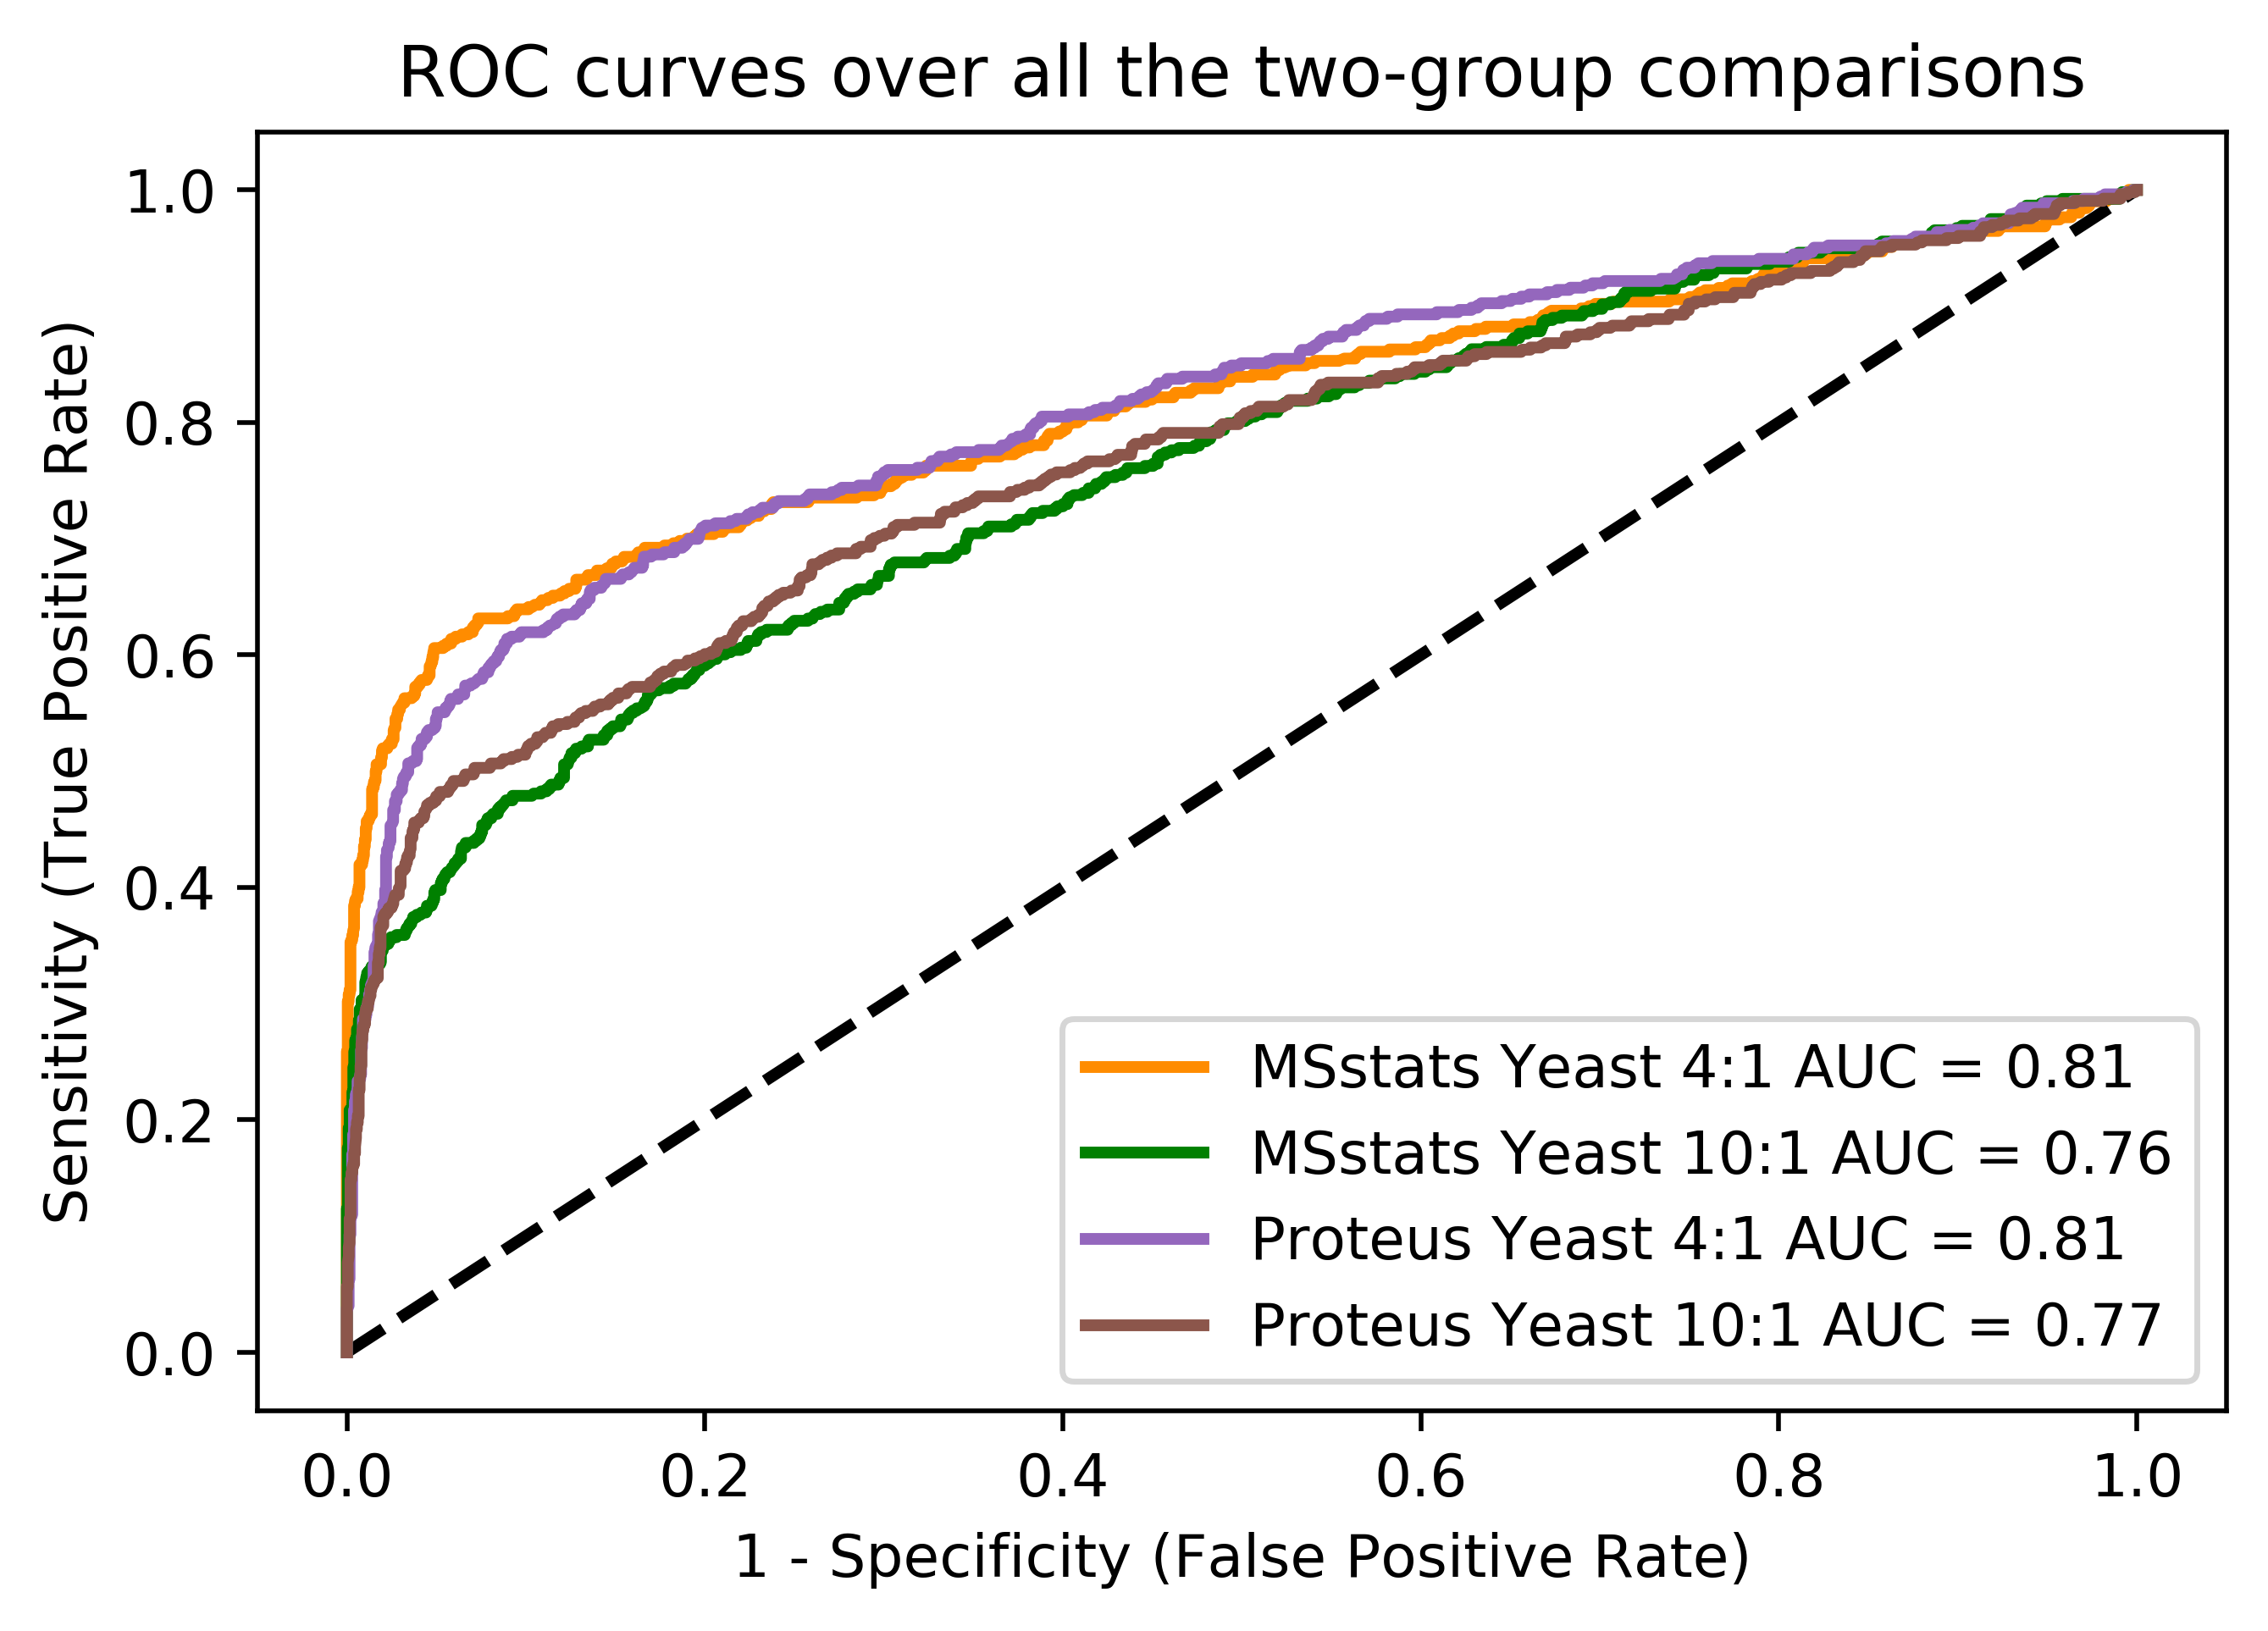

In [167]:

quantile_msstats_comparison['value'] = 1 - quantile_msstats_comparison['adj.pvalue']
quantile_msstats_comparison['y'] = quantile_msstats_comparison['Protein'].map(lambda x: ("YEAST" in x and 1) or ("YEAST" not in x and 0))
quantile_msstats_comparison_4 = quantile_msstats_comparison[quantile_msstats_comparison["Label"] == "4vs1"]
quantile_msstats_comparison_10 = quantile_msstats_comparison[quantile_msstats_comparison["Label"] == "10vs1"]

quantile_msstats_comparison_4 = quantile_msstats_comparison_4.sort_values(by="value", ascending=False)
quantile_msstats_comparison_4.head()

fpr, tpr, thresholds = metrics.roc_curve(quantile_msstats_comparison_4['y'].tolist(), quantile_msstats_comparison_4['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.figure(dpi=500)
plt.plot(fpr, tpr, color="darkorange", lw=2, label="MSstats Yeast 4:1 AUC = %0.2f" % auc)
plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")

fpr, tpr, thresholds = metrics.roc_curve(quantile_msstats_comparison_10['y'].tolist(), quantile_msstats_comparison_10['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color="green", lw=2, label="MSstats Yeast 10:1 AUC = %0.2f" % auc)
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

# Proteus
quantile_proteus_comparison_4 = quantile_proteus_comparison_4.dropna(subset=["P.Value"], how="any")
quantile_proteus_comparison_4['value'] = 1 - quantile_proteus_comparison_4['adj.P.Val']
quantile_proteus_comparison_4['y'] = quantile_proteus_comparison_4['protein'].map(lambda x: ("YEAST" in x and 1) or ("YEAST" not in x and 0))

fpr, tpr, thresholds = metrics.roc_curve(quantile_proteus_comparison_4['y'].tolist(), quantile_proteus_comparison_4['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, color="#9467BD", lw=2, label="Proteus Yeast 4:1 AUC = %0.2f" % auc)
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

quantile_proteus_comparison_10 = quantile_proteus_comparison_10.dropna(subset=["P.Value"], how="any")
quantile_proteus_comparison_10['value'] = 1 - quantile_proteus_comparison_10['adj.P.Val']
quantile_proteus_comparison_10['y'] = quantile_proteus_comparison_10['protein'].map(lambda x: ("YEAST" in x and 1) or ("YEAST" not in x and 0))

fpr, tpr, thresholds = metrics.roc_curve(quantile_proteus_comparison_10['y'].tolist(), quantile_proteus_comparison_10['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color="#8C564B", lw=2, label="Proteus Yeast 10:1 AUC = %0.2f" % auc)
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")


plt.title("ROC curves over all the two-group comparisons")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend(loc="lower right")

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


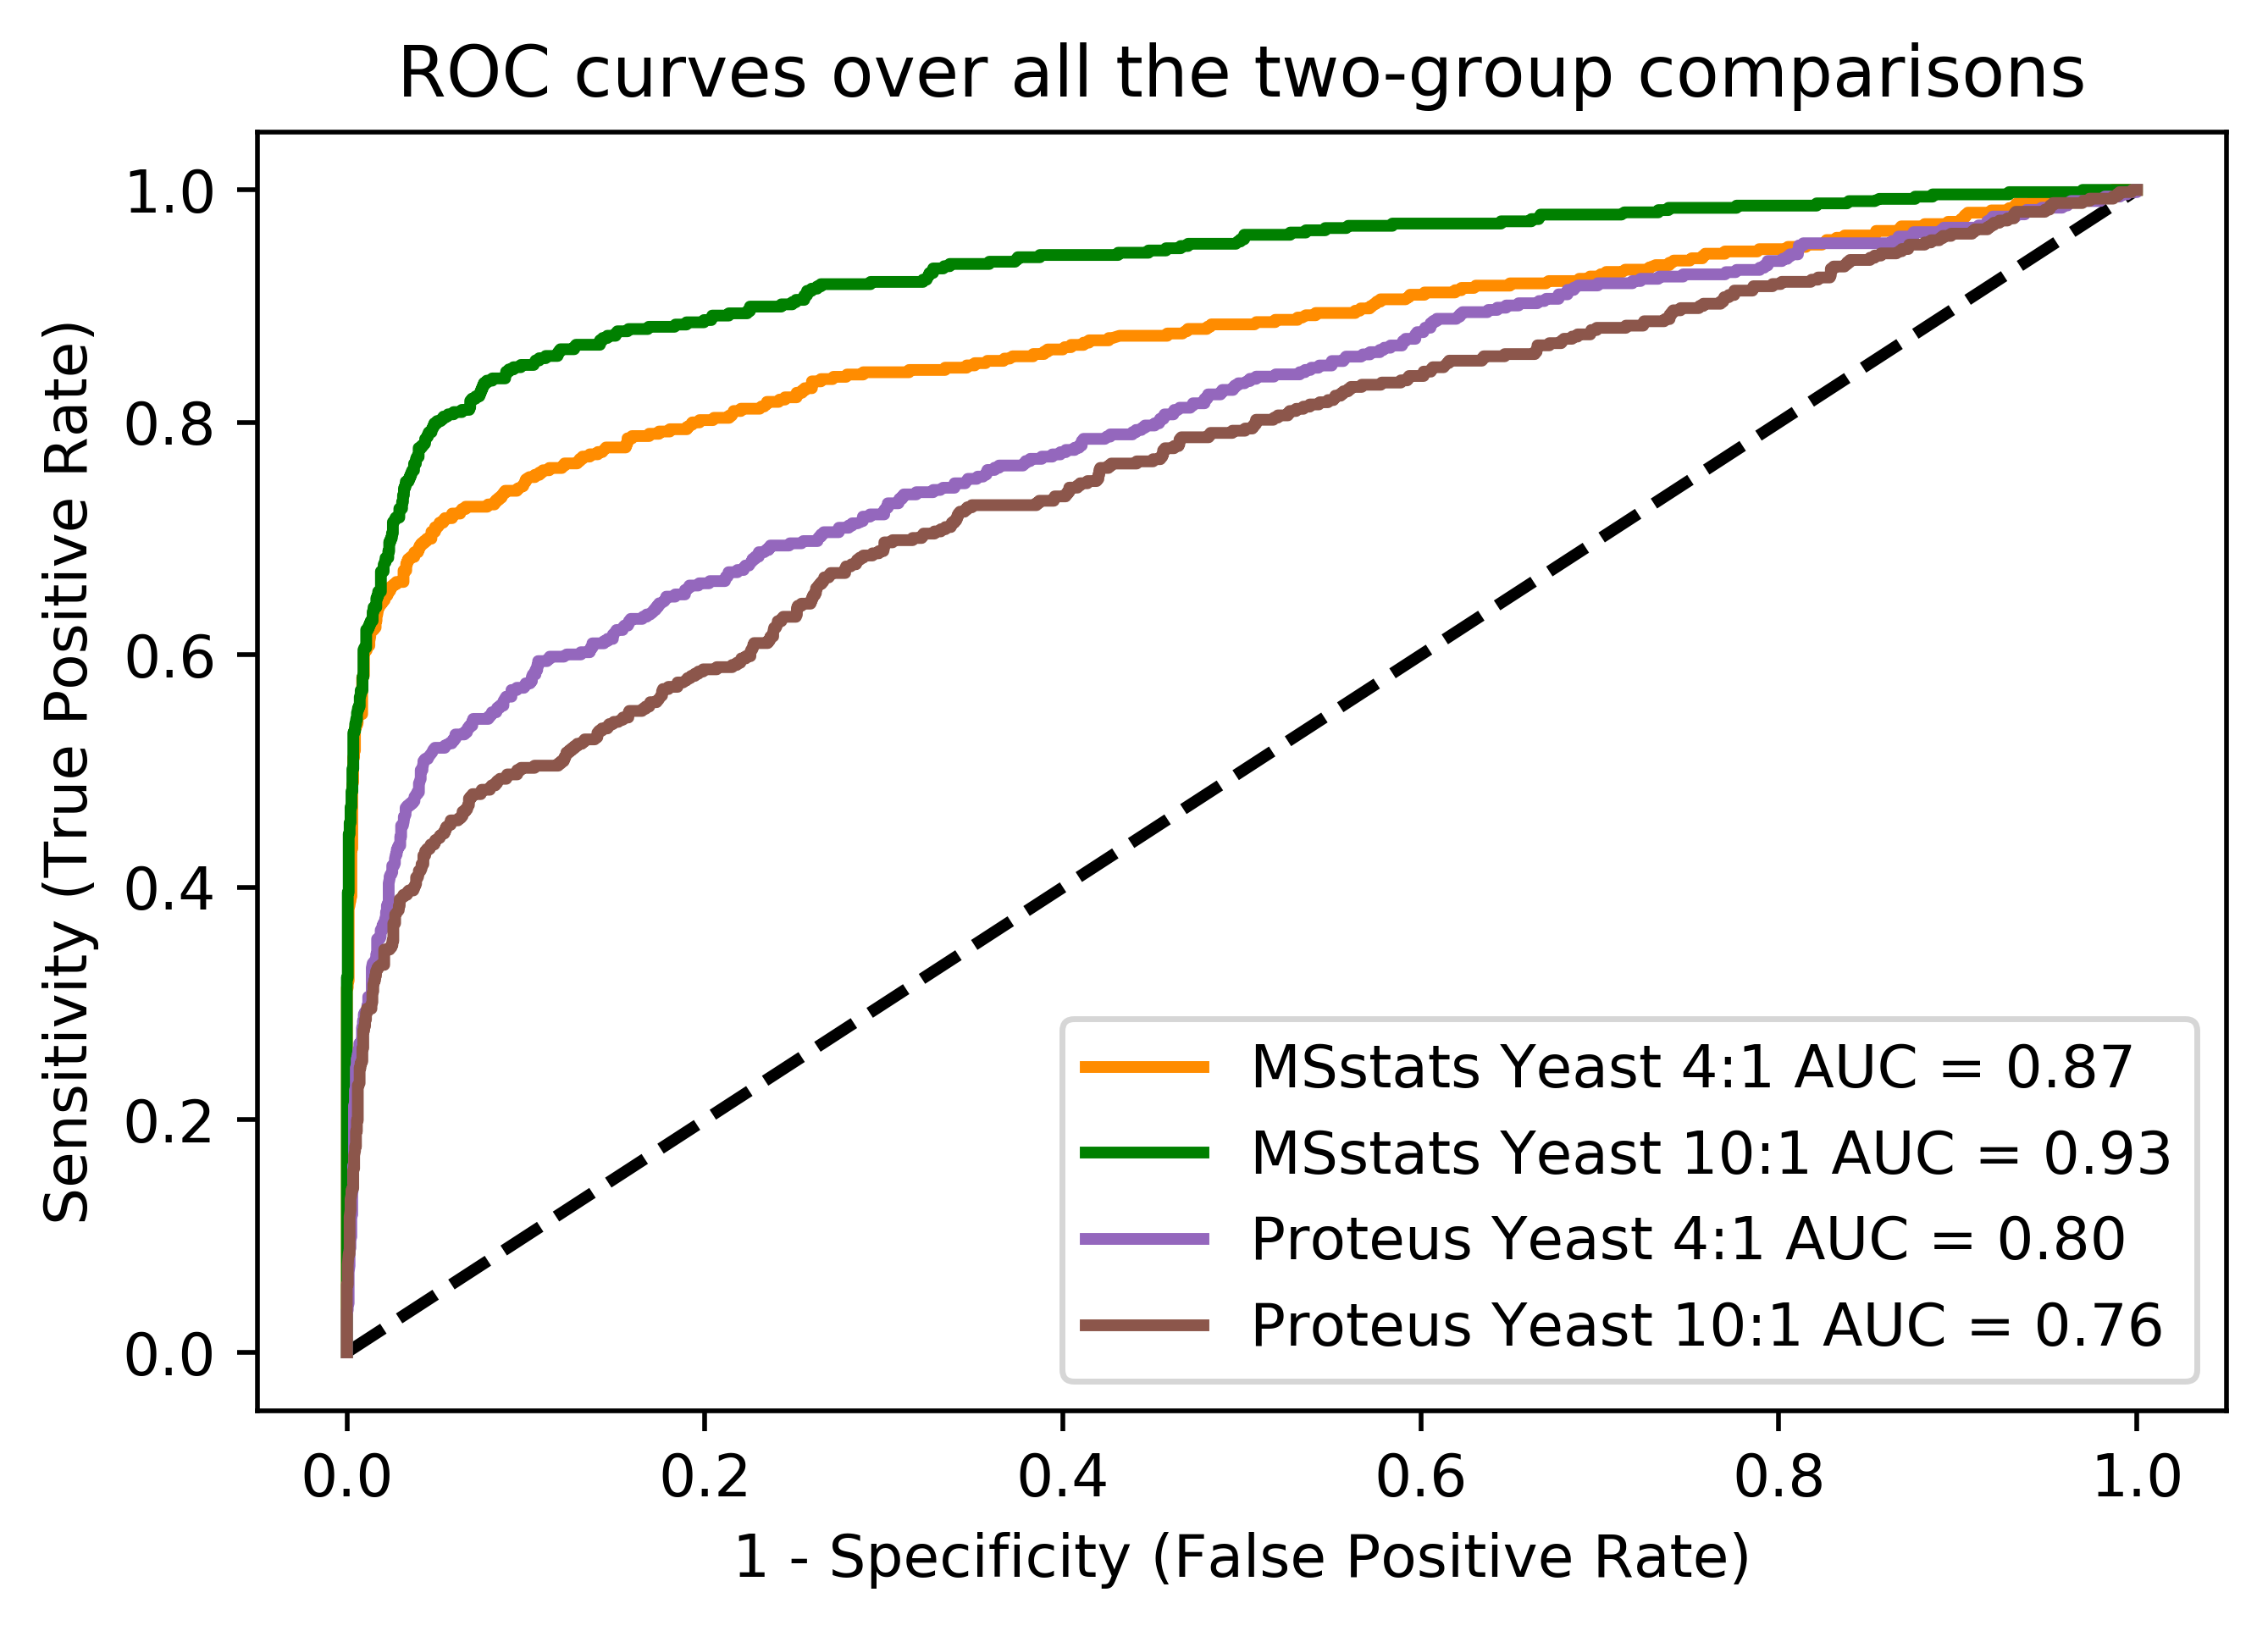

In [168]:

no_normalization_msstats_comparison['value'] = 1 - no_normalization_msstats_comparison['adj.pvalue']
no_normalization_msstats_comparison['y'] = no_normalization_msstats_comparison['Protein'].map(lambda x: ("YEAST" in x and 1) or ("YEAST" not in x and 0))
no_normalization_msstats_comparison_4 = no_normalization_msstats_comparison[no_normalization_msstats_comparison["Label"] == "4vs1"]
no_normalization_msstats_comparison_10 = no_normalization_msstats_comparison[no_normalization_msstats_comparison["Label"] == "10vs1"]

no_normalization_msstats_comparison_4 = no_normalization_msstats_comparison_4.sort_values(by="value", ascending=False)
no_normalization_msstats_comparison_4.head()

fpr, tpr, thresholds = metrics.roc_curve(no_normalization_msstats_comparison_4['y'].tolist(), no_normalization_msstats_comparison_4['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.figure(dpi=500)
plt.plot(fpr, tpr, color="darkorange", lw=2, label="MSstats Yeast 4:1 AUC = %0.2f" % auc)
plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")

fpr, tpr, thresholds = metrics.roc_curve(no_normalization_msstats_comparison_10['y'].tolist(), no_normalization_msstats_comparison_10['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color="green", lw=2, label="MSstats Yeast 10:1 AUC = %0.2f" % auc)
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")


# Proteus
no_normalization_proteus_comparison_4 = no_normalization_proteus_comparison_4.dropna(subset=["P.Value"], how="any")
no_normalization_proteus_comparison_4['value'] = 1 - no_normalization_proteus_comparison_4['adj.P.Val']
no_normalization_proteus_comparison_4['y'] = no_normalization_proteus_comparison_4['protein'].map(lambda x: ("YEAST" in x and 1) or ("YEAST" not in x and 0))

fpr, tpr, thresholds = metrics.roc_curve(no_normalization_proteus_comparison_4['y'].tolist(), no_normalization_proteus_comparison_4['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, color="#9467BD", lw=2, label="Proteus Yeast 4:1 AUC = %0.2f" % auc)
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

no_normalization_proteus_comparison_10 = no_normalization_proteus_comparison_10.dropna(subset=["P.Value"], how="any")
no_normalization_proteus_comparison_10['value'] = 1 - no_normalization_proteus_comparison_10['adj.P.Val']
no_normalization_proteus_comparison_10['y'] = no_normalization_proteus_comparison_10['protein'].map(lambda x: ("YEAST" in x and 1) or ("YEAST" not in x and 0))

fpr, tpr, thresholds = metrics.roc_curve(no_normalization_proteus_comparison_10['y'].tolist(), no_normalization_proteus_comparison_10['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color="#8C564B", lw=2, label="Proteus Yeast 10:1 AUC = %0.2f" % auc)
# plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")


plt.title("ROC curves over all the two-group comparisons")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend(loc="lower right")

In [208]:
c1 = em_msstats_comparison_4[em_msstats_comparison_4["adj.pvalue"] < 0.2]["Protein"]
c2 = quantile_msstats_comparison_4[quantile_msstats_comparison_4["adj.pvalue"] < 0.2]["Protein"]
c3 = no_normalization_msstats_comparison_4[no_normalization_msstats_comparison_4["adj.pvalue"] < 0.2]["Protein"]
c4 = em_proteus_comparison_4[em_proteus_comparison_4["adj.P.Val"] < 0.2]["protein"]
c5 = quantile_proteus_comparison_4[quantile_proteus_comparison_4["adj.P.Val"] < 0.2]["protein"]
c6 = no_normalization_proteus_comparison_4[no_normalization_proteus_comparison_4["adj.P.Val"] < 0.2]["protein"]
c = set(c1).intersection(set(c2))
c = c.intersection(set(c3))
c = c.intersection(set(c4))
c = c.intersection(set(c5))
c = c.intersection(set(c6))

c = [i for i in c if "HUMAN" not in i]
print(c)

['sp|P22147|XRN1_YEAST', 'sp|Q04958|NTE1_YEAST', 'sp|Q06704|IMH1_YEAST', 'sp|P53148|SP105_YEAST', 'sp|P53550|DCP2_YEAST', 'sp|P36421|SYYC_YEAST', 'sp|P53741|BRE5_YEAST', 'sp|P35845|OSH1_YEAST', 'sp|P23201|SPA2_YEAST', 'sp|P38112|MAK5_YEAST', 'sp|P16521|EF3A_YEAST', 'sp|Q08965|BMS1_YEAST', 'sp|Q03373|DIG2_YEAST', 'sp|P38013|AHP1_YEAST', 'sp|P53252|PIL1_YEAST', 'sp|P32497|EIF3C_YEAST', 'sp|P21304|PWP1_YEAST', 'sp|P53769|CWC24_YEAST', 'sp|P32386|YBT1_YEAST', 'sp|P43585|VTC2_YEAST', 'sp|P41920|YRB1_YEAST', 'sp|P25558|BUD3_YEAST', 'sp|Q12263|GIN4_YEAST', 'sp|P10080|SSBP1_YEAST', 'sp|P53112|PEX14_YEAST', 'sp|Q12159|YRA1_YEAST', 'sp|Q12434|GDIR_YEAST', 'sp|P14164|ABF1_YEAST', 'sp|P40021|ZRG8_YEAST', 'sp|Q06833|NVJ2_YEAST', 'sp|P33332|SEC3_YEAST', 'sp|P05750|RS3_YEAST', 'sp|Q06440|CORO_YEAST', 'sp|P25441|RPC4_YEAST', 'sp|Q04545|TDA9_YEAST', 'sp|P32449|AROG_YEAST', 'sp|P37370|VRP1_YEAST', 'sp|Q12136|SAS10_YEAST', 'sp|P38853|KEL1_YEAST', 'sp|P26321|RL5_YEAST', 'sp|P04786|TOP1_YEAST', 'sp|P39744|

0
305
326
338
342
348
351
354
357
361
362
364
365
367
368
372
372
373
373
375
375
375
376
376
378
379
379
382
384
385
386
388
388
388
388
388
388
389
389
390
391
391
391
392
392
392
393
393
393
393


(-0.01, 0.2)

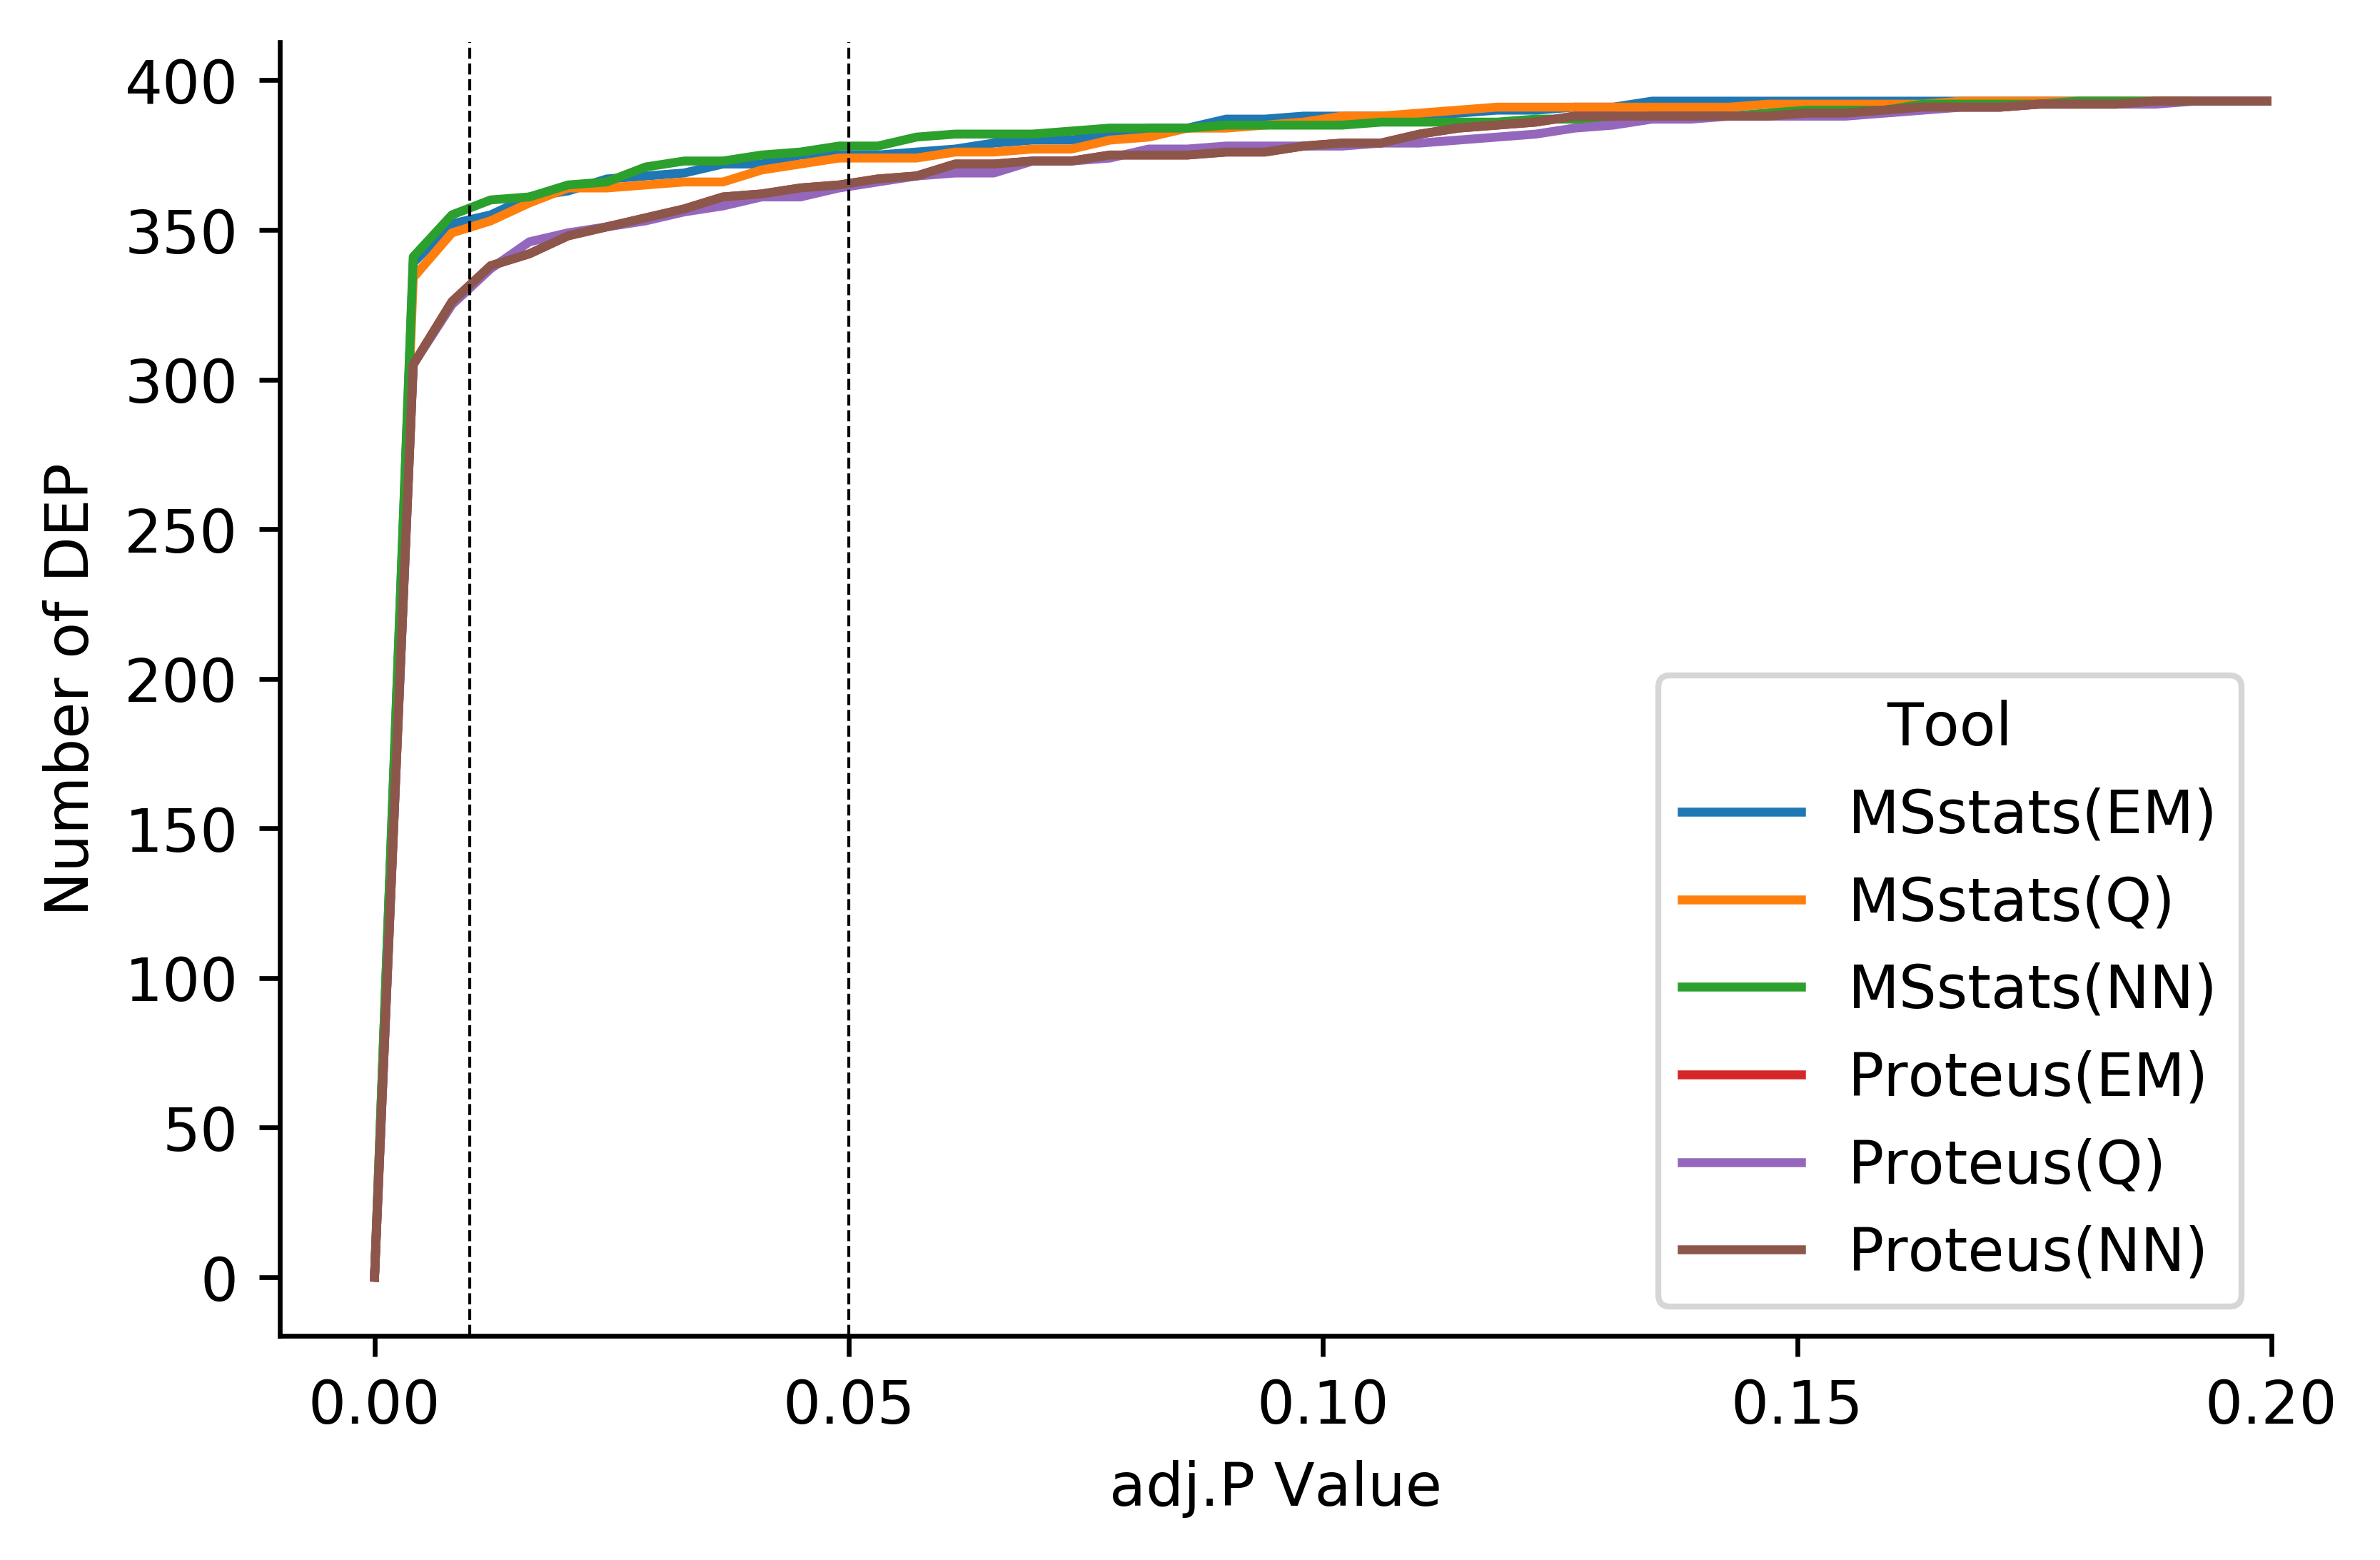

In [205]:
plot_number_adjpval = pd.DataFrame(columns=["x", "y", "Tool"])
x = np.linspace(0,0.2)

for i in x:
    tem = em_msstats_comparison_4[em_msstats_comparison_4["adj.pvalue"] < i]
    j= len(tem[(tem["Protein"].isin(c))])
    
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "MSstats(EM)"},ignore_index=True)
    
for i in x:
    tem = quantile_msstats_comparison_4[quantile_msstats_comparison_4["adj.pvalue"] < i]
    j= len(tem[(tem["Protein"].isin(c))])
    
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "MSstats(Q)"}, ignore_index=True)

for i in x:
    tem = no_normalization_msstats_comparison_4[no_normalization_msstats_comparison_4["adj.pvalue"] < i]
    j= len(tem[(tem["Protein"].isin(c))])
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "MSstats(NN)"}, ignore_index=True)

for i in x:
    tem = em_proteus_comparison_4[em_proteus_comparison_4["adj.P.Val"] < i]
    j= len(tem[(tem["protein"].isin(c))])
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "Proteus(EM)"}, ignore_index=True)
    
for i in x:
    tem = quantile_proteus_comparison_4[quantile_proteus_comparison_4["adj.P.Val"] < i]
    j= len(tem[(tem["protein"].isin(c))])
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "Proteus(Q)"}, ignore_index=True)
    
for i in x:
    tem = no_normalization_proteus_comparison_4[no_normalization_proteus_comparison_4["adj.P.Val"] < i]
    j= len(tem[(tem["protein"].isin(c))])
    print(j)
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "Proteus(NN)"}, ignore_index=True)
    
fig, ax = plt.subplots(dpi=600)

sns.lineplot(x="x", y="y", data=plot_number_adjpval, hue="Tool")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

x_major_locator= plt.MultipleLocator(0.05)
ax.xaxis.set_major_locator(x_major_locator)

ax.axvline(x=0.05, c="black", linewidth=0.5, ls="--")
ax.axvline(x=0.01, ymax=1000 ,c="black", linewidth=0.5, ls="--")

# ax.legend(loc="lower right", frameon=False)
plt.xlabel("adj.P Value")
plt.ylabel("Number of DEP")

plt.xlim(-0.01, 0.2)

In [211]:
tem = no_normalization_msstats_comparison_4[no_normalization_msstats_comparison_4["adj.pvalue"] < 0.01]
j= len(tem[(tem["Protein"].isin(c))])
print(j)

tem = no_normalization_proteus_comparison_4[no_normalization_proteus_comparison_4["adj.P.Val"] < 0.01]
j= len(tem[(tem["protein"].isin(c))])
print(j)

tem = no_normalization_msstats_comparison_4[no_normalization_msstats_comparison_4["adj.pvalue"] < 0.05]
j= len(tem[(tem["Protein"].isin(c))])
print(j)

tem = no_normalization_proteus_comparison_4[no_normalization_proteus_comparison_4["adj.P.Val"] < 0.05]
j= len(tem[(tem["protein"].isin(c))])
print(j)

357
332
378
365


In [212]:
c1 = em_msstats_comparison_10[em_msstats_comparison_10["adj.pvalue"] < 0.2]["Protein"]
c2 = quantile_msstats_comparison_10[quantile_msstats_comparison_10["adj.pvalue"] < 0.2]["Protein"]
c3 = no_normalization_msstats_comparison_10[no_normalization_msstats_comparison_10["adj.pvalue"] < 0.2]["Protein"]
c4 = em_proteus_comparison_10[em_proteus_comparison_10["adj.P.Val"] < 0.2]["protein"]
c5 = quantile_proteus_comparison_10[quantile_proteus_comparison_10["adj.P.Val"] < 0.2]["protein"]
c6 = no_normalization_proteus_comparison_10[no_normalization_proteus_comparison_10["adj.P.Val"] < 0.2]["protein"]
c = set(c1).intersection(set(c2))
c = c.intersection(set(c3))
c = c.intersection(set(c4))
c = c.intersection(set(c5))
c = c.intersection(set(c6))

c = [i for i in c if "HUMAN" not in i]
print(c)

['sp|P22147|XRN1_YEAST', 'sp|Q06704|IMH1_YEAST', 'sp|Q04958|NTE1_YEAST', 'sp|P53148|SP105_YEAST', 'sp|P53550|DCP2_YEAST', 'sp|P53741|BRE5_YEAST', 'sp|P36421|SYYC_YEAST', 'sp|P35845|OSH1_YEAST', 'sp|P23201|SPA2_YEAST', 'sp|P38112|MAK5_YEAST', 'sp|Q08965|BMS1_YEAST', 'sp|P16521|EF3A_YEAST', 'sp|Q03373|DIG2_YEAST', 'sp|P38013|AHP1_YEAST', 'sp|P18494|GLN3_YEAST', 'sp|P41940|MPG1_YEAST', 'sp|P53252|PIL1_YEAST', 'sp|P21304|PWP1_YEAST', 'sp|P53769|CWC24_YEAST', 'sp|P32386|YBT1_YEAST', 'sp|P43585|VTC2_YEAST', 'sp|P41920|YRB1_YEAST', 'sp|P25558|BUD3_YEAST', 'sp|Q12263|GIN4_YEAST', 'sp|P10080|SSBP1_YEAST', 'sp|P08678|CYAA_YEAST', 'sp|P53112|PEX14_YEAST', 'sp|Q12159|YRA1_YEAST', 'sp|P08018|PBS2_YEAST', 'sp|P14164|ABF1_YEAST', 'sp|Q12434|GDIR_YEAST', 'sp|P22082|SNF2_YEAST', 'sp|Q06833|NVJ2_YEAST', 'sp|P40021|ZRG8_YEAST', 'sp|P33332|SEC3_YEAST', 'sp|P05750|RS3_YEAST', 'sp|Q06440|CORO_YEAST', 'sp|P25441|RPC4_YEAST', 'sp|Q04545|TDA9_YEAST', 'sp|P32449|AROG_YEAST', 'sp|Q12136|SAS10_YEAST', 'sp|P37370|

(-0.01, 0.2)

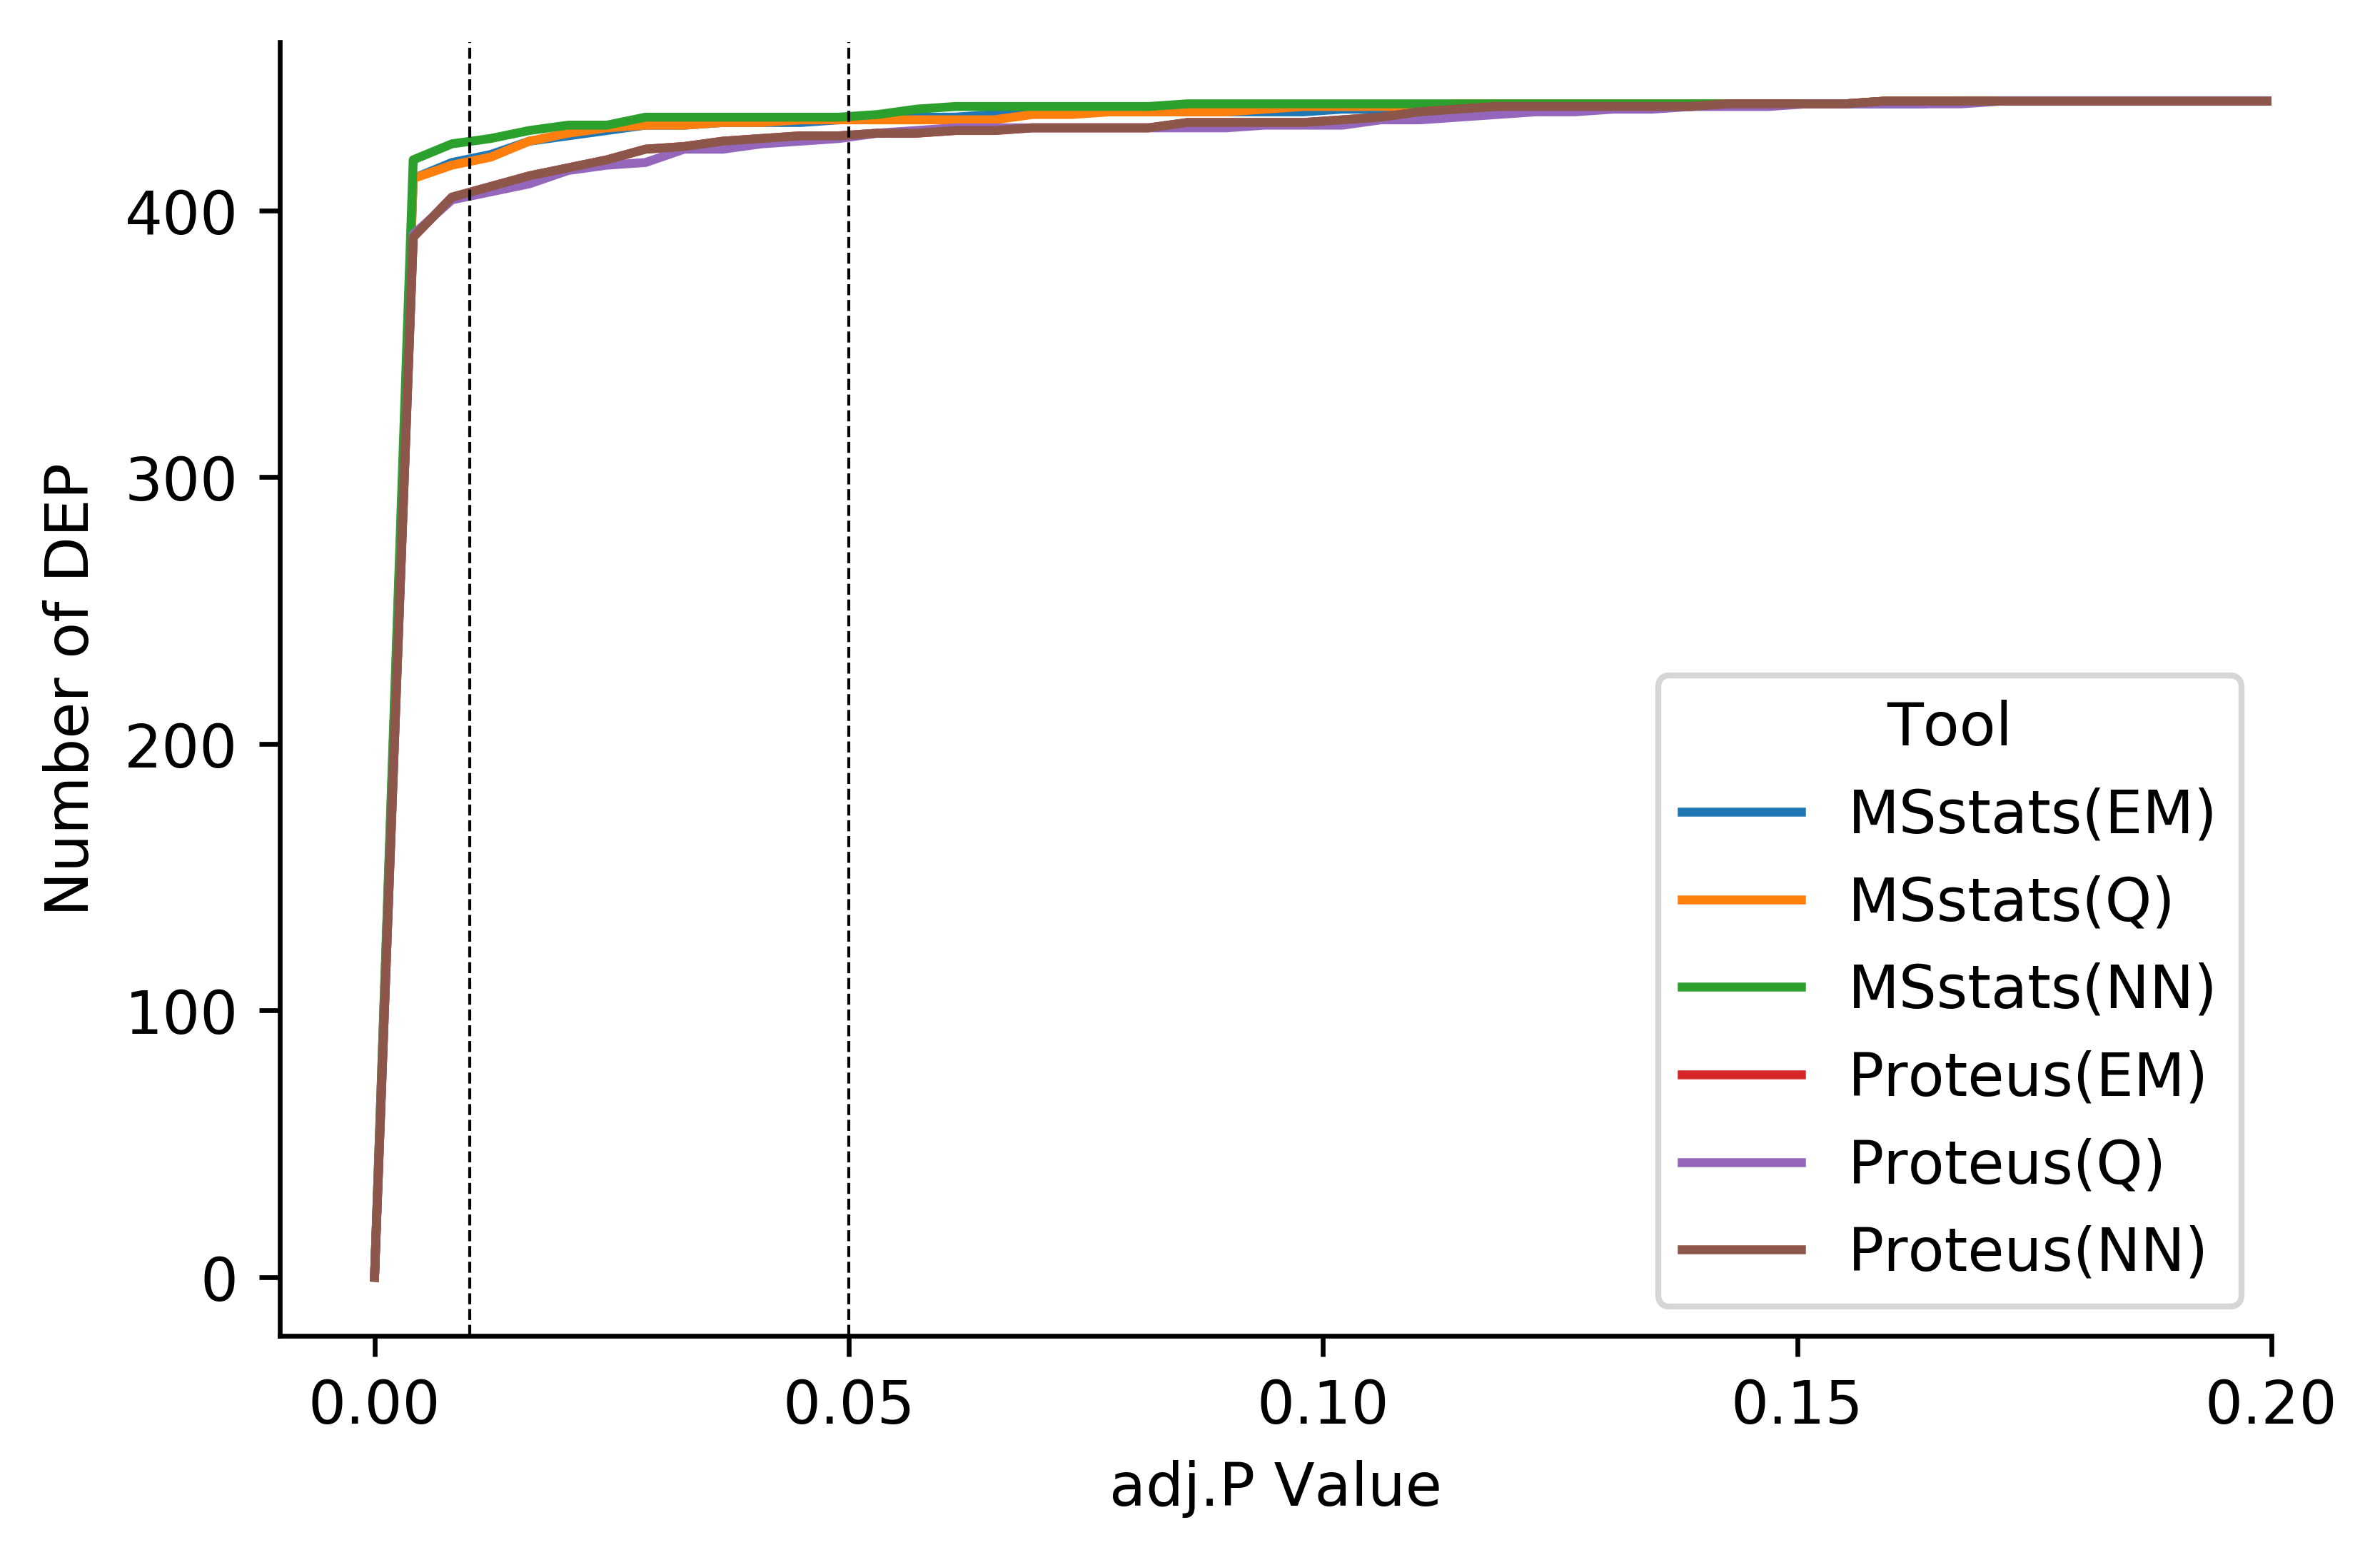

In [207]:
plot_number_adjpval = pd.DataFrame(columns=["x", "y", "Tool"])
x = np.linspace(0,0.2)

for i in x:
    tem = em_msstats_comparison_10[em_msstats_comparison_10["adj.pvalue"] < i]
    j= len(tem[(tem["Protein"].isin(c))])
    
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "MSstats(EM)"},ignore_index=True)
    
for i in x:
    tem = quantile_msstats_comparison_10[quantile_msstats_comparison_10["adj.pvalue"] < i]
    j= len(tem[(tem["Protein"].isin(c))])
    
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "MSstats(Q)"}, ignore_index=True)

for i in x:
    tem = no_normalization_msstats_comparison_10[no_normalization_msstats_comparison_10["adj.pvalue"] < i]
    j= len(tem[(tem["Protein"].isin(c))])
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "MSstats(NN)"}, ignore_index=True)

for i in x:
    tem = em_proteus_comparison_10[em_proteus_comparison_10["adj.P.Val"] < i]
    j= len(tem[(tem["protein"].isin(c))])
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "Proteus(EM)"}, ignore_index=True)
    
for i in x:
    tem = quantile_proteus_comparison_10[quantile_proteus_comparison_10["adj.P.Val"] < i]
    j= len(tem[(tem["protein"].isin(c))])
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "Proteus(Q)"}, ignore_index=True)
    
for i in x:
    tem = no_normalization_proteus_comparison_10[no_normalization_proteus_comparison_10["adj.P.Val"] < i]
    j= len(tem[(tem["protein"].isin(c))])
    plot_number_adjpval = plot_number_adjpval.append({"x": i, "y": j, "Tool": "Proteus(NN)"}, ignore_index=True)
    
fig, ax = plt.subplots(dpi=600)

sns.lineplot(x="x", y="y", data=plot_number_adjpval, hue="Tool")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

x_major_locator= plt.MultipleLocator(0.05)
ax.xaxis.set_major_locator(x_major_locator)

ax.axvline(x=0.05, c="black", linewidth=0.5, ls="--")
ax.axvline(x=0.01, ymax=1000 ,c="black", linewidth=0.5, ls="--")

# ax.legend(loc="lower right", frameon=False)
plt.xlabel("adj.P Value")
plt.ylabel("Number of DEP")

plt.xlim(-0.01, 0.2)

In [213]:
tem = no_normalization_msstats_comparison_10[no_normalization_msstats_comparison_10["adj.pvalue"] < 0.01]
j= len(tem[(tem["Protein"].isin(c))])
print(j)

tem = no_normalization_proteus_comparison_10[no_normalization_proteus_comparison_10["adj.P.Val"] < 0.01]
j= len(tem[(tem["protein"].isin(c))])
print(j)

tem = no_normalization_msstats_comparison_10[no_normalization_msstats_comparison_10["adj.pvalue"] < 0.05]
j= len(tem[(tem["Protein"].isin(c))])
print(j)

tem = no_normalization_proteus_comparison_10[no_normalization_proteus_comparison_10["adj.P.Val"] < 0.05]
j= len(tem[(tem["protein"].isin(c))])
print(j)

426
407
435
429
